In [1]:
import sys

# import seaborn as sns
import numpy as np
from scipy import stats, integrate
import os
import matplotlib as mpl
import matplotlib.ticker as tk
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import re
from copy import deepcopy
from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages
import datetime
import pandas as pd
import scipy.interpolate as interpolate
import json

plt.rcParams.update({'font.size': 18})
sys.path.append('/home/jtb34/GitHub/GACF/')
#sys.path.append('/home/jtb34/python27')
# print sys.path
from NGTS.NGTS_Field import return_field_from_object_directory, NGTSField
from NGTS.GACF_utils import TIME_CONVERSIONS
import NGTS.GACF_utils as utils

ROOT_DIR = '/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS'

/home/jtb34/GitHub/GACF/NGTS/NGTS_Field.py:11: UserWarning: ngtsio not imported
  warnings.warn("ngtsio not imported")
/home/jtb34/GitHub/GACF/NGTS/GACF_utils/ngtsio_utils.py:10: UserWarning: ngtsio not imported
  warnings.warn("ngtsio not imported")


In [2]:
from astropy.time import Time
from astropy.coordinates import get_moon, get_sun, SkyCoord, EarthLocation, AltAz
import astropy.units as u
def moon_phase_angle(time, ephemeris=None):
    """
    Calculate lunar orbital phase in radians.

    Parameters
    ----------
    time : `~astropy.time.Time`
        Time of observation

    ephemeris : str, optional
        Ephemeris to use.  If not given, use the one set with
        `~astropy.coordinates.solar_system_ephemeris` (which is
        set to 'builtin' by default).

    Returns
    -------
    i : float
        Phase angle of the moon [radians]
    """
    # TODO: cache these sun/moon SkyCoord objects

    sun = get_sun(time)
    moon = get_moon(time, ephemeris=ephemeris)
    elongation = sun.separation(moon)
    return np.arctan2(sun.distance*np.sin(elongation),
                      moon.distance - sun.distance*np.cos(elongation))

def moon_illumination(time, ephemeris=None):
    """
    Calculate fraction of the moon illuminated.

    Parameters
    ----------
    time : `~astropy.time.Time`
        Time of observation

    ephemeris : str, optional
        Ephemeris to use.  If not given, use the one set with
        `~astropy.coordinates.solar_system_ephemeris` (which is
        set to 'builtin' by default).

    Returns
    -------
    k : float
        Fraction of moon illuminated
    """
    i = moon_phase_angle(time, ephemeris=ephemeris)
    k = (1 + np.cos(i))/2.0
    return k.value

In [3]:
XMATCH_LOCATION = '/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS/{}/cross_match/'
XMATCH_FILE_NAME = 'Uncut_Final_{}.fits'
def load_gaia_params(field):
    xmatch_path = os.path.join(XMATCH_LOCATION.format(field.fieldname),
                               XMATCH_FILE_NAME.format(field.fieldname))
    if not os.path.exists(xmatch_path):
        print xmatch_path, 'does not exist'
        return field

    with fits.open(xmatch_path) as gfits:
        for i, obj in enumerate(gfits[1].data['Sequence_number']):
            if obj in field.objects:
                field[obj].Gaia_Teff = gfits[1].data['Gaia_Teff'][i]
                field[obj].Gaia_Radius = gfits[1].data['Gaia_Radius'][i]
                field[obj].Gaia_Lum = gfits[1].data['Gaia_Lum'][i]
                field[obj].Gaia_Parallax = gfits[1].data['Gaia_Parallax'][i]
                field[obj].TWOMASS_Hmag = gfits[1].data['2MASS_Hmag'][i]
                field[obj].TWOMASS_Kmag = gfits[1].data['2MASS_Kmag'][i]
                field[obj].APASS_Vmag = gfits[1].data['APASS_Vmag'][i]
                field[obj].APASS_Bmag = gfits[1].data['APASS_Bmag'][i]
                field[obj].Gaia_Gmag = gfits[1].data['Gaia_Gmag'][i]
                field[obj].NGTS_I_3 = gfits[1].data['NGTS_I_3'][i]
                field[obj].NGTS_I_4 = gfits[1].data['NGTS_I_4'][i]
                field[obj].NGTS_I_5 = gfits[1].data['NGTS_I_5'][i]
                field[obj].NGTS_I_6 = gfits[1].data['NGTS_I_6'][i]
                field[obj].BminusV = field[obj].APASS_Bmag - field[obj].APASS_Vmag
                field[obj].HminusK = field[obj].TWOMASS_Hmag - field[obj].TWOMASS_Kmag
                field[obj].GminusK = field[obj].Gaia_Gmag - field[obj].TWOMASS_Kmag
#         print gfits[1].header

    return field

def find_fits_file(directory=None):
    if directory is None:
         directory = os.getcwd()
    string_pattern = r'^(?P<fieldname>\w+?[+-]\w+?)_\d+_[\w\-/,]+_(?P<test>\w+).fits$'
    pattern = re.compile(string_pattern)
    for f in os.listdir(directory):
        match = re.match(pattern, f)
        if match is not None:
            return f if directory is None else os.path.join(directory, f), match.group('fieldname'), match.group('test')
        
    raise IOError('File not found in directory {}'.format(directory))
    
# field.load_from_fits(fits_file, obj_ids=object_list, method='fitsio')

In [4]:
now = Time.now()

In [ ]:
moon = get_moon(now)

In [6]:
moon

<SkyCoord (GCRS: obstime=2019-06-14 07:51:25.140516, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, km)
    (224.50005219, -12.08780431, 379244.70709355)>

In [68]:
# fieldname = 'NG2346-3633'
# fieldname = 'NG0535-0523'
# fieldname = 'NG2142+0826'
# field_position = '23:46 -36.33'
field_position = '21:42 +08.26'
NGTSFieldCentre = SkyCoord(field_position, unit=(u.hourangle, u.deg), frame='gcrs')
print NGTSFieldCentre

<SkyCoord (GCRS: obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec) in deg
    (325.5, 8.26)>


In [69]:
ra_rad = [m.ra.wrap_at(180 * u.deg).radian for m in moon_sep]
dec_rad = [m.dec.radian for m in moon_sep]
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111, projection='aitoff')
plt.title("Aitoff projection of moon")
plt.grid(True)
plt.plot(ra_rad, dec_rad, 'o', markersize=2, alpha=0.3)
plt.plot(NGTSFieldCentre.ra.wrap_at(180*u.deg).radian, NGTSFieldCentre.dec.radian, 'o', markersize=10, c='r')
plt.subplots_adjust(top=0.95,bottom=0.0)
plt.show()
# c = ax.scatter([m.deg for m in moon_sep], np.linspace(1,1,len(ts)),c=ts)
# plt.show()

NameError: name 'moon_sep' is not defined

In [ ]:
plt.plot(ts,[np.cos(m) for m in moon_sep])
plt.show()

In [ ]:
from GACF import find_correlation_from_lists_cpp
lt, c, _ = find_correlation_from_lists_cpp(ts, [float(np.cos(m)) for m in moon_sep])

In [ ]:
plt.plot(lt, c)
plt.axvline(x=28)
plt.show()

In [ ]:
NGTSFieldCentre.distance

In [ ]:

loc

In [ ]:
plt.scatter(ts, [m.arcminute for m in moon_sep])

In [5]:
# fieldname = 'NG1416-2518'
fieldname = 'NG2142+0826'
# fieldname = 'NG0004-2950'
object_pattern = re.compile(r'^(?P<obj>\d+)_VERSION_CYCLE1807$')
logfile = '{}_VERSION_CYCLE1807/peaks.log'
obj_list = []
for f in os.listdir(os.path.join(ROOT_DIR, fieldname)):
    match = re.match(object_pattern, f)
    if match is not None:
        obj_list.append(int(match.group('obj')))
obj_list = np.array(obj_list)
print 'Found {} objects'.format(len(obj_list))
logfiles = []
# obj_id = obj_list[np.random.randint(0, len(obj_list), size=50)]
obj_id = obj_list
for o in obj_id:
    path = os.path.join(*[ROOT_DIR, fieldname, logfile.format(o)])
    if os.path.exists(path):
        logfiles.append((o, path))
# print logfiles
# obj_id = [30]
print obj_id
# field = return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807', obj_ids=obj_id)
# obj = field[field.objects.keys()[0]]

Found 9228 objects
[26890 32302 15006 ...  5011 27917  3849]


In [6]:
moon_text_pattern = re.compile(r'Moon period removed: (\d+\.*\d*) days')
moon_p_range = np.zeros(len(logfiles)) + np.nan
moon_poss = np.zeros(len(logfiles))
moon_poss_pattern = re.compile(r'Most likely periods \[(\d+\.*\d*)\]')
period_list_pattern = re.compile(r'peak periods: \[(.*?)\]')
moon_periods = np.zeros(len(logfiles)) + np.nan
moon_objs = np.zeros(len(logfiles))
moon_up = np.zeros(len(logfiles))
bad_fft = np.zeros(len(logfiles))
possible_moon = np.zeros(len(logfiles))
successful_removal = np.zeros(len(logfiles))
n_not_moon = np.zeros(len(logfiles))
n_rounds = np.zeros(len(logfiles))
knn_ok = np.zeros(len(logfiles))
knn_bad = np.zeros(len(logfiles))
n_periods = np.zeros(len(logfiles))
empty_moon_bins = np.zeros(len(logfiles))
symmetry_check = np.zeros(len(logfiles))
turnover_check = np.zeros(len(logfiles))
rms_check = np.zeros(len(logfiles))
model_good = np.zeros(len(logfiles))
model_bad = np.zeros(len(logfiles))
for i, lf in enumerate(logfiles):
    with open(lf[1], 'r') as f:
        log = f.read()
        n_not_moon[i] = log.count('NOT MOON')
        n_rounds[i] = log.count('Lag Resolution')
        if 'peak periods' in log:
            ppstring = re.search(period_list_pattern, log).group(0)
            n_periods[i] = len(re.compile(r'\d+\.\d+').findall(ppstring))
        if 'BAD FFT' in log:
#             bad_fft.append(lf[0])
            bad_fft[i] = True
        else:
            bad_fft[i] = False
            if 'NOT MOON: Rejected on period range' not in log:
#                 possible_moon.append(lf[0])
                possible_moon[i] = True
            else:
                possible_moon[i] = False
                
        if 'Most likely periods' in log:
            match = re.search(moon_poss_pattern, log)
            if match:
#                 moon_periods.append(float(match.group(1)))
#                 moon_objs.append(lf[0])
                p = float(match.group(1))
                if (25 < p < 32):
                    moon_p_range[i] = p
                    moon_poss[i] = True
                else:
                    if 25 < 2*p < 32:
                        moon_p_range[i] = 2*p
                        moon_poss[i] = True
                    elif 25 < 0.5*p < 32:
                        moon_p_range[i] = 0.5*p
                        moon_poss[i] = True
                    else:
                        moon_poss[i] = False
        else:
            moon_poss[i] = False
        if 'Moon period removed' in log:
            match = re.search(moon_text_pattern, log)
            if match:
#                 moon_periods.append(float(match.group(1)))
#                 moon_objs.append(lf[0])
                moon_periods[i] = float(match.group(1))
                moon_objs[i] = True
            else:
                moon_objs[i] = False
#             if 'MOON SIGNAL LOWER' in log:
# #                 moon_up.append('LOWER')
#                 moon_up[i] = False
#             elif 'MOON SIGNAL HIGHER' in log:
# #                 moon_up.append('HIGHER')
#                 moon_up[i] = True
            if 'New best period detected after moon removal' in log:
                successful_removal[i] = True
            else:
                successful_removal[i] = False
#             else:
#                 moon_up.append(None)
#             print 'MOON REMOVED', log
            if 'MOON SIGNAL: Data missing at full moon' in log:
                empty_moon_bins[i] = True
            else:
                empty_moon_bins[i] = False
                symmatch = re.compile(r'RMS change after folding \(symmetry indicator\): (\d+\.*\d+)').search(log)
                rmsmatch = re.compile(r'RMS change after turnover: (\d+\.*\d+)').search(log)
                threshmatch = re.compile(r'\[turnover, h1, h2\]: \[(\d+\.*\d+)').search(log)
                symmetry_check[i] =  float(symmatch.group(1)) < 1.5
                rms_check[i] = float(rmsmatch.group(1)) > 1.0
                turnover_check[i] = 0.4 < float(threshmatch.group(1)) < 0.8
                if 'Model fit good' in log:
                    model_good[i] = True
                if 'Model fit bad' in log:
                    model_bad[i] = True
                    print '------------'
                    print log
                    print '------------'
                

        if 'Signal Threshold Exceeded' in log:
            knn_ok[i] = True
            knn_bad[i] = False
        elif 'Signal Below Threshold' in log:
            knn_bad[i] = True
            knn_ok[i] = False
        else:
            knn_ok[i] = knn_bad[i] = False
#     print log
# print moon_periods

------------
 ######      ###     ######  ######## 
##    ##    ## ##   ##    ## ##       
##         ##   ##  ##       ##       
##   #### ##     ## ##       ######   
##    ##  ######### ##       ##       
##    ##  ##     ## ##    ## ##       
 ######   ##     ##  ######  ##    
------------------------------
Number of Data Points: 1736
Number of Lag Timesteps: 10832
Lag Resolution: 0.0208333333333
------------------------------

Altered 30.5529137529 to 29.3620071685
Most likely periods [29.362]
Moon model fit parameters [turnover, h1, h2]: [0.60010893 0.99783326 1.01396173]
Moon model gradient: 0.040332171134 (no overlap)
RMS change after folding (symmetry indicator): 1.18946427476
RMS change after turnover: 1.53230924305
RMS of model vs. data: 1.29238237577
MOON SIGNAL: Model fit good
Moon period removed: 29.362 days
 ######      ###     ######  ######## 
##    ##    ## ##   ##    ## ##       
##         ##   ##  ##       ##       
##   #### ##     ## ##       ######   
##    ## 

------------
 ######      ###     ######  ######## 
##    ##    ## ##   ##    ## ##       
##         ##   ##  ##       ##       
##   #### ##     ## ##       ######   
##    ##  ######### ##       ##       
##    ##  ##     ## ##    ## ##       
 ######   ##     ##  ######  ##    
------------------------------
Number of Data Points: 1737
Number of Lag Timesteps: 10831
Lag Resolution: 0.0208333333333
------------------------------

Altered 29.5207207207 to 29.8433515483
Most likely periods [29.843]
Moon model fit parameters [turnover, h1, h2]: [0.48954999 1.00169712 0.9928644 ]
Moon model gradient: -0.0173037876898 (no overlap)
RMS change after folding (symmetry indicator): 1.0943728305
RMS change after turnover: 1.04883839686
RMS of model vs. data: 0.961164205142
MOON SIGNAL: Model fit good
Moon period removed: 29.843 days
 ######      ###     ######  ######## 
##    ##    ## ##   ##    ## ##       
##         ##   ##  ##       ##       
##   #### ##     ## ##       ######   
##    #

In [7]:
from scipy import special
import matplotlib.ticker as mtick

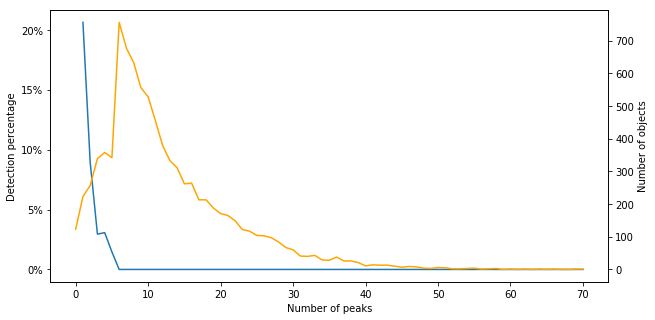

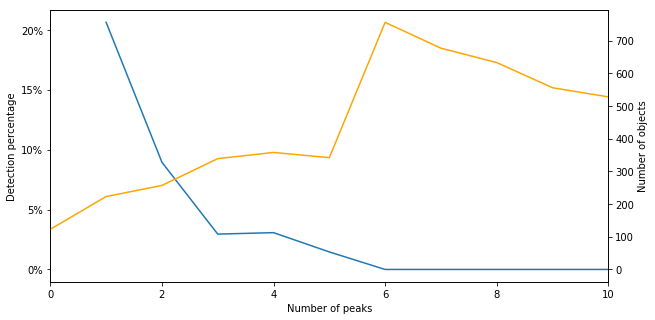

In [8]:
n_good_per_peaks = np.zeros(int(max(n_periods)) + 1)
n_per_peaks = np.zeros(int(max(n_periods)) + 1)
pct_per_peaks = np.zeros(int(max(n_periods)) + 1)

for i, n_p in enumerate(n_periods):
    if knn_ok[i]:
        n_good_per_peaks[int(n_p)] += 1
    n_per_peaks[int(n_p)] += 1
        
# print n_good_per_peaks
# print n_per_peaks

i = 0
for good, total in zip(n_good_per_peaks, n_per_peaks):
    if good > 0:
        pct_per_peaks[i] = (float(good) / float(total)) * 100
    i += 1

pct_per_peaks[0] = np.nan
# print pct_per_peaks

fig, ax = plt.subplots(figsize=(10,5))
ax1 = ax.twinx()

# nonzeros = [p for p in pct_per_peaks if p > 0]

# ax.plot(np.arange(1, len(nonzeros)+1, 1), nonzeros)
ax.plot(pct_per_peaks)
ax1.plot(n_per_peaks, c='orange')
x = np.arange(1, len(pct_per_peaks), 1).astype(float)
# a = 5
# y = x**(-a) / special.zetac(a)
# ax.plot(x, y)

ax.set_xlabel('Number of peaks')
ax.set_ylabel('Detection percentage')
ax1.set_ylabel('Number of objects')

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(xticks)

plt.show()

fig, ax = plt.subplots(figsize=(10,5))
ax1 = ax.twinx()

# nonzeros = [p for p in pct_per_peaks if p > 0]

# ax.plot(np.arange(1, len(nonzeros)+1, 1), nonzeros)
ax.plot(pct_per_peaks)
ax1.plot(n_per_peaks, c='orange')
x = np.arange(1, len(pct_per_peaks), 1).astype(float)
# a = 5
# y = x**(-a) / special.zetac(a)
# ax.plot(x, y)

ax.set_xlabel('Number of peaks')
ax.set_ylabel('Detection percentage')
ax1.set_ylabel('Number of objects')
ax.set_xlim([0, 10])

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(xticks)

plt.show()

In [10]:
total = float(len(logfiles))
print '{} total objects processed'.format(int(total))

removed_at_fft = 0
moon_found = 0
moon_removed_fft = 0
moon_again = 0
moon_new_period = 0
good = 0
poss_moon_period = 0
good_signal = 0
good_signal_moon = 0
moon_period_not_moon = 0
moon_period_not_moon_good = 0
moon_period_gap = 0
symm = 0
turn = 0
rms = 0

interest = []

for i in range(len(logfiles)):
    if model_bad[i]:
        pass
    if moon_poss[i]:
        poss_moon_period += 1
        if not moon_objs[i]:
            moon_period_not_moon += 1
            if knn_ok[i]:
                moon_period_not_moon_good += 1
    if moon_objs[i]:
        moon_found += 1
        interest.append(logfiles[i][0])
        if empty_moon_bins[i]:
            moon_period_gap += 1
        if rms_check[i]:
            rms += 1
        if symmetry_check[i]:
            rms += 1
        if turnover_check[i]:
            turn += 1
        if bad_fft[i]:
            moon_removed_fft += 1
        elif successful_removal[i]:
            moon_new_period += 1
            if knn_ok[i]:
                good_signal_moon += 1
                
        else:
            moon_again += 1
    else:
        if bad_fft[i]:
            removed_at_fft += 1
        else:
            good += 1
            if knn_ok[i]:
                good_signal += 1
            
# check numbers add up.

moon_sum = moon_removed_fft + moon_again + moon_new_period
count_moon = moon_found == moon_sum
if not count_moon:
    print moon_sum
total_sum = removed_at_fft + moon_removed_fft + moon_again + moon_new_period + good
count_total = total == total_sum
if not count_total:
    print total_sum
if not (count_moon and count_total):
    print 'Checks: MOON {}, TOTAL {}'.format(count_moon, count_total)
            
print '{} removed at FFT stage ({:.2f}%)'.format(removed_at_fft, (float(removed_at_fft) / total) * 100)
print '{} possible moon detections, moon removal attempted ({:.2f}%)'.format(moon_found, (float(moon_found) / total) * 100)
print '\t{} removals left noise ({:.2f}%)'.format(moon_removed_fft, (float(moon_removed_fft) / total) * 100)
print '\t{} removals left moon again ({:.2f}%)'.format(moon_again, (float(moon_again) / total) * 100)
print '\t{} removals found new period ({:.2f}% of total, {:.2f}% of moon) '.format(moon_new_period, (float(moon_new_period) / total) * 100, (float(moon_new_period) / float(moon_found)) * 100)
print '\t{} post moon removal passed k-NN check ({:.2f}% of total, {:.2f}% of moon) '.format(good_signal_moon, (float(good_signal_moon) / total) * 100, (float(good_signal_moon) / float(moon_found)) * 100)
print '\t{} flagged as not moon ({:.2f}% of total, {:.2f}% of moon) '.format(moon_period_not_moon, (float(moon_period_not_moon) / total) * 100, (float(moon_period_not_moon) / float(moon_found)) * 100)
print '\t\t{} not moon passed k-NN check ({:.2f}% of total, {:.2f}% of moon) '.format(moon_period_not_moon_good, (float(moon_period_not_moon_good) / total) * 100, (float(moon_period_not_moon_good) / float(moon_found)) * 100)
print '{} objects good from start ({:.2f}%)'.format(good, (float(good) / total) * 100)
print '\t{} good objects passed k-NN check ({:.2f}%)'.format(good_signal, (float(good_signal) / total) * 100)
print
print '{} periods outputted ({:.2f}%)'.format(good_signal + good_signal_moon, (float(good_signal + good_signal_moon) / total) * 100)

9067 total objects processed
5596 removed at FFT stage (61.72%)
2748 possible moon detections, moon removal attempted (30.31%)
	2477 removals left noise (27.32%)
	50 removals left moon again (0.55%)
	221 removals found new period (2.44% of total, 8.04% of moon) 
	3 post moon removal passed k-NN check (0.03% of total, 0.11% of moon) 
	203 flagged as not moon (2.24% of total, 7.39% of moon) 
		13 not moon passed k-NN check (0.14% of total, 0.47% of moon) 
723 objects good from start (7.97%)
	92 good objects passed k-NN check (1.01%)

95 periods outputted (1.05%)


In [11]:
len(np.nonzero(turnover_check)[0]) + len(np.nonzero(empty_moon_bins)[0])

2748

In [153]:
# good outputs
goodobjs = np.array(logfiles)[(knn_ok == True) * (bad_fft == False) * (moon_objs == False)]
# not real signal
medobjs = np.array(logfiles)[(knn_ok == False) * (bad_fft == False) * (moon_objs == False)]
# noise objects
badobjs = np.array(logfiles)[(bad_fft == True) * (n_rounds == 1)]

In [167]:
import random
obj_list = ([int(i[0]) for i in random.sample(goodobjs, 3)] +
 [int(i[0]) for i in random.sample(medobjs, 3)] +
 [int(i[0]) for i in random.sample(badobjs, 3)])
print obj_list

In [172]:
obj_list

[31335, 9559, 10600, 18051, 13258, 1456, 5397, 2442, 12785]

In [13]:
# for i, lf in enumerate(logfiles):
#     with open(lf[1], 'r') as f:
#         log = f.read()
#         if 'Most likely periods' in log:
#             match = re.search(moon_text_pattern, log)
#             if match:
# #                 moon_periods.append(float(match.group(1)))
# #                 moon_objs.append(lf[0])
#                 p = float(match.group(1))
#                 if (25 < p < 32):
#                     moon_p_range[i] = p
#                     moon_poss[i] = True
#                 else:
#                     if 25 < 2*p < 32:
#                         moon_p_range[i] = 2*p
#                         moon_poss[i] = True
#                     elif 25 < 0.5*p < 32:
#                         moon_p_range[i] = 0.5*p
#                         moon_poss[i] = True
#                     else:
#                         moon_poss[i] = False
#         else:
#             moon_poss[i] = False

In [14]:
obj_list = []
obj_periods = []
for i in range(len(logfiles)):
    if moon_poss[i] and np.isfinite(moon_p_range[i]):
        obj_list.append(logfiles[i][0])
        obj_periods.append(moon_p_range[i])
print '{} objects of interest'.format(len(obj_list))
obj_idxs = np.random.randint(0, len(obj_list), 100)
obj_periods = list(np.array(obj_periods)[obj_idxs])
obj_list = list(np.array(obj_list)[obj_idxs])
print obj_list

2951 objects of interest
[24410, 29595, 26427, 27832, 31143, 9726, 5106, 10075, 15237, 18029, 10545, 19733, 8032, 25099, 5046, 32290, 20874, 18591, 4821, 23983, 15782, 16775, 22967, 21065, 16798, 6260, 25232, 23103, 4271, 5212, 27445, 17163, 18291, 28738, 25791, 14964, 27655, 20269, 27426, 5883, 6076, 29218, 28065, 12714, 9074, 10158, 28227, 19533, 12189, 2149, 29416, 22476, 6759, 14388, 6894, 17221, 6805, 2638, 14398, 21213, 5716, 7460, 21666, 21253, 1914, 25404, 28061, 14037, 18988, 26763, 20664, 30354, 25791, 7273, 22196, 16867, 28597, 24250, 27122, 10917, 9965, 32689, 15523, 24448, 4719, 2433, 30052, 22128, 2332, 20809, 18477, 20540, 20415, 18395, 9578, 26705, 25298, 22361, 21865, 23095]


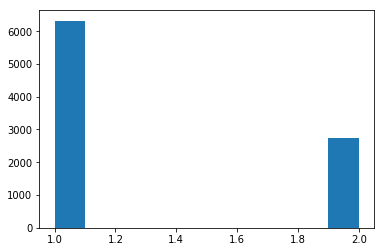

In [15]:
plt.hist(n_rounds)
plt.show()

In [36]:
# find dodgy objects
for i in range(len(logfiles)):
    if (moon_poss[i] and n_not_moon[i] >= 5 and n_rounds[i] == 2):
        print 'subl ~/rds/{}/{}_VERSION_CYCLE1807/peaks.log'.format(fieldname, logfiles[i][0])

subl ~/rds/NG2142+0826/31630_VERSION_CYCLE1807/peaks.log
subl ~/rds/NG2142+0826/18061_VERSION_CYCLE1807/peaks.log


In [6]:
import logging
logger = logging.getLogger()
sh = logging.StreamHandler()
sh.setFormatter(logging.Formatter())
logger.addHandler(sh)
logger.setLevel(logging.INFO)
logger.info('Yeet')
obj.logger = logger

Yeet


NameError: name 'obj' is not defined

In [7]:

# p = moon_periods[i]
# print obj_id, p
# fieldname = 'NG1416-2518'
fieldname = 'NG2142+0826'
# fieldname = 'NG0004-2950'
# fieldname = 'NG2346-3633'
# obj_id = [70, 7680, 11065]
obj_id = [31335, 9559, 10600, 18051, 13258, 1456, 5397, 2442, 12785]
field = return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807', obj_ids=obj_id)
field.logger = logger
for obj in field:
    obj.logger = logger
fits_file,_,_ = find_fits_file(directory=field.filename)
field.load_from_fits(fits_file, obj_ids=obj_id, method='fitsio', sparse_ids=True)
field = load_gaia_params(field)
print '{} loaded'.format(field)
# obj = field[field.objects.keys()[0]]
# fig, ax = plt.subplots(figsize=(10,5))
# ax.set_ylim([0.95, 1.03])
# # p = obj.cleaned_refined_periods[0]
# # p = obj.periods[0]
# # p = 27.723
# t = obj.timeseries_binned
# f = obj.flux_binned
# # new_moon_epoch = field.get_new_moon_epoch()
# new_moon_epoch = 827.4207774265543
# phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
# binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
# ax.scatter(phase_app, data_app)
# ax.set_title('Phase folded on {} days'.format(p))
# plt.show()

matched 9228 of 9239 files. Loaded 9 objects


Data loaded in 0.3496530056 seconds, cleaning...
Removed 0 objects: []
All data loaded and cleaned


NGTS Field NG2142+0826 loaded


In [15]:
print '\n'.join(map(str,zip(moon_objs, moon_periods)))

(0.0, nan)
(0.0, nan)
(1.0, 28.007)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(1.0, 28.593)
(0.0, nan)
(1.0, 29.843)
(0.0, nan)
(0.0, nan)
(1.0, 28.593)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(1.0, 28.593)
(0.0, nan)
(1.0, 29.05)
(0.0, nan)
(1.0, 29.681)
(0.0, nan)
(1.0, 28.297)
(1.0, 28.444)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(1.0, 29.05)
(1.0, 28.896)
(0.0, nan)
(0.0, nan)
(1.0, 28.593)
(1.0, 29.362)
(1.0, 29.843)
(0.0, nan)
(1.0, 29.362)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(1.0, 30.341)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(1.0, 31.387)
(0.0, nan)
(1.0, 29.681)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(1.0, 28.744)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(1.0, 27.307)
(1.0, 29.843)
(0.0, nan)
(0.0, nan)
(1.0, 28.896)
(0.0, nan)
(0.0, nan)
(1.0, 30.51)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(1.0, 28.896)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(0.0, nan)
(1.0, 30.341)
(0.0

In [24]:
len(moon_objs)

1145

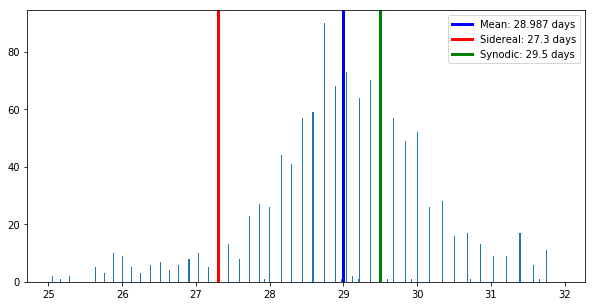

In [25]:
len(moon_periods)
bin_width = 20 * TIME_CONVERSIONS['m2d']
bin_edges = np.arange(min(moon_periods), max(moon_periods), bin_width)
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(moon_periods, bins=bin_edges)
ax.axvline(x=np.mean(moon_periods), c='b', lw=3, label='Mean: {:.3f} days'.format(np.mean(moon_periods)))
ax.axvline(x=27.3, c='r', lw=3, label='Sidereal: 27.3 days')
ax.axvline(x=29.5, c='g', lw=3, label='Synodic: 29.5 days')
plt.legend()
plt.show()

NGTS Object NG2142+0826_18051 (CYCLE1807)


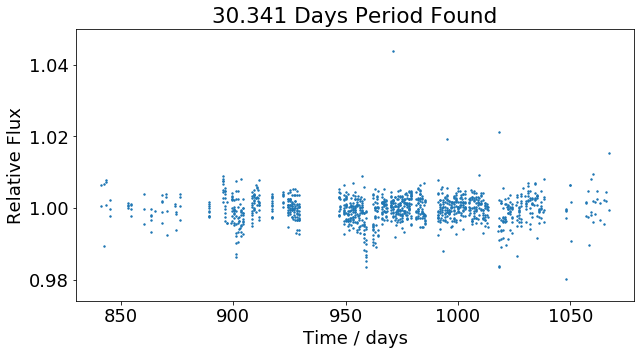

NGTS Object NG2142+0826_31335 (CYCLE1807)


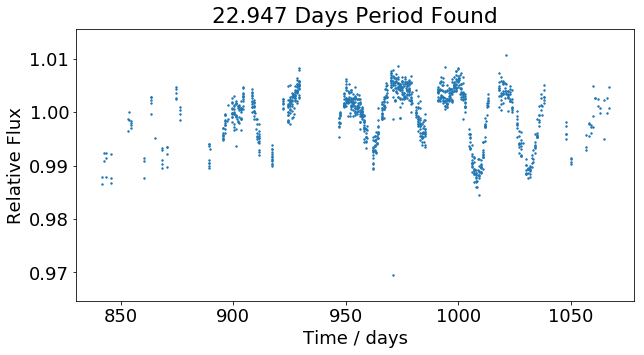

NGTS Object NG2142+0826_10600 (CYCLE1807)


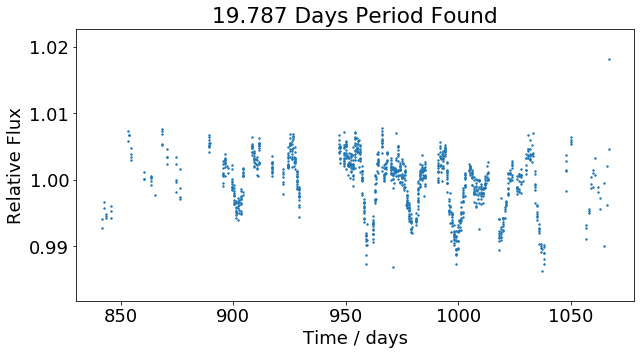

NGTS Object NG2142+0826_13258 (CYCLE1807)


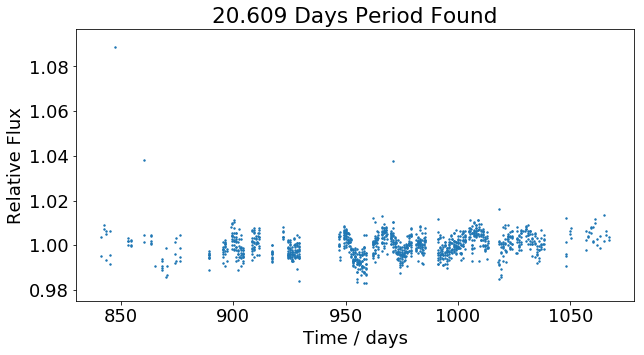

NGTS Object NG2142+0826_1456 (CYCLE1807)


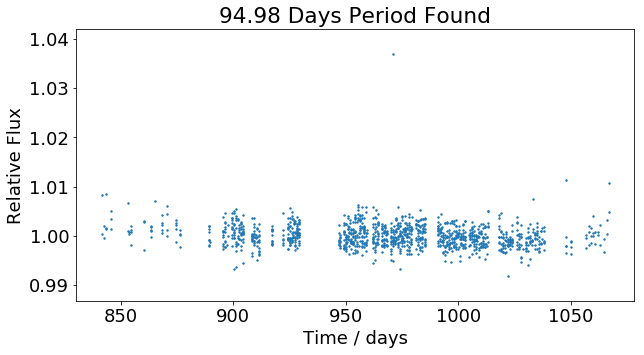

NGTS Object NG2142+0826_12785 (CYCLE1807)


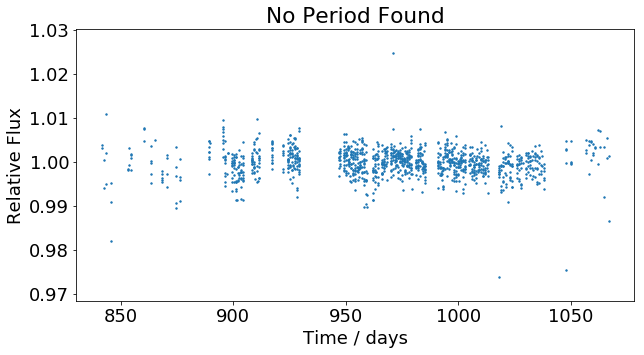

NGTS Object NG2142+0826_5397 (CYCLE1807)


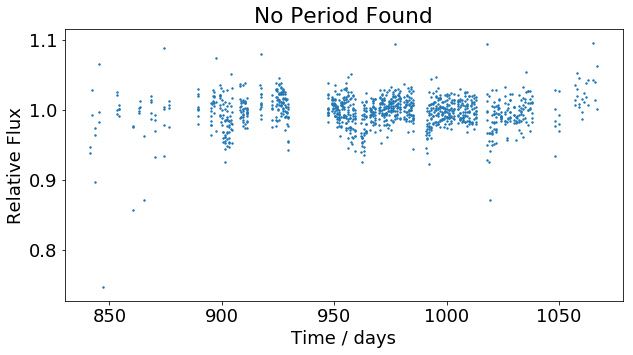

NGTS Object NG2142+0826_9559 (CYCLE1807)


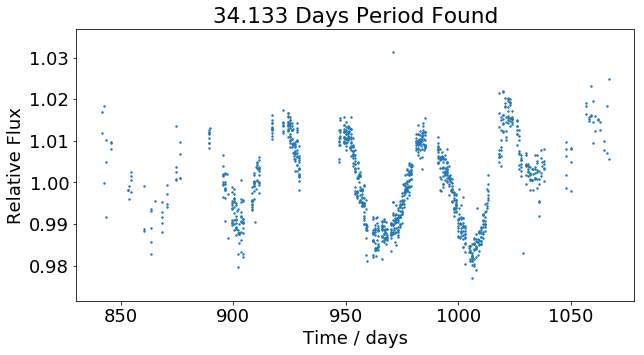

NGTS Object NG2142+0826_2442 (CYCLE1807)


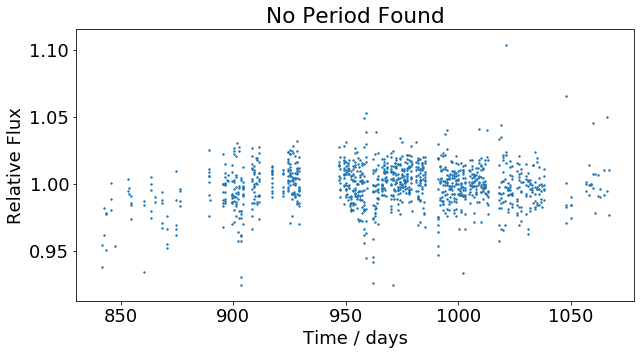

In [174]:
for obj in field:
    print obj
    fig, ax = plt.subplots(figsize=(10,5))
    if len(obj.cleaned_refined_periods) > 0:
        ax.set_title('{} Days Period Found'.format(obj.cleaned_refined_periods[0]))
    else:
        ax.set_title('No Period Found')
    ax.scatter(obj.timeseries_binned, obj.flux_binned, s=2)
    ax.set_xlabel('Time / days')
    ax.set_ylabel('Relative Flux')
    fig.savefig('{}.pdf'.format(str(obj)))
    plt.show()

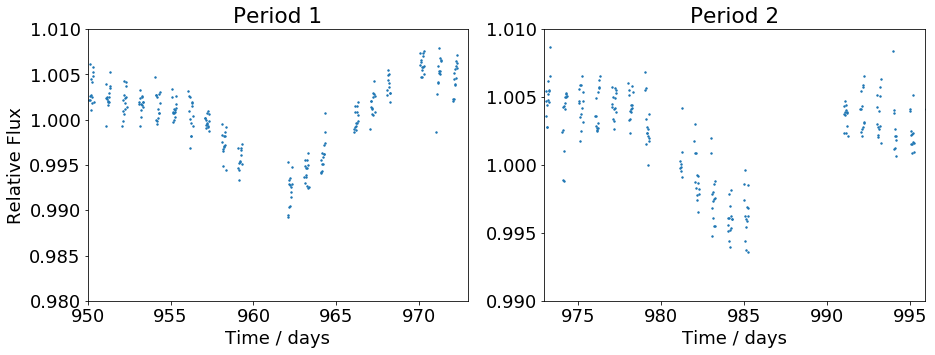

In [202]:
obj = field[31335]
p = obj.cleaned_refined_periods[0]
e = 950
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(15,5))
perc = np.nanpercentile(obj.flux_binned, [10, 90])
ax.scatter(obj.timeseries_binned, obj.flux_binned, s=2)
ax.set_xlabel('Time / days')
ax.set_ylabel('Relative Flux')
ax.set_ylim([0.98, 1.01])
ax.set_xlim([e, e+p])
ax.set_title('Period 1')

ax1.set_title('Period 2')
ax1.scatter(obj.timeseries_binned, obj.flux_binned, s=2)
ax1.set_xlabel('Time / days')
ax1.set_ylim([0.99, 1.01])
ax1.set_xlim(e+p, e+2*p)

plt.savefig('phase_signal_ratio.pdf')

plt.show()

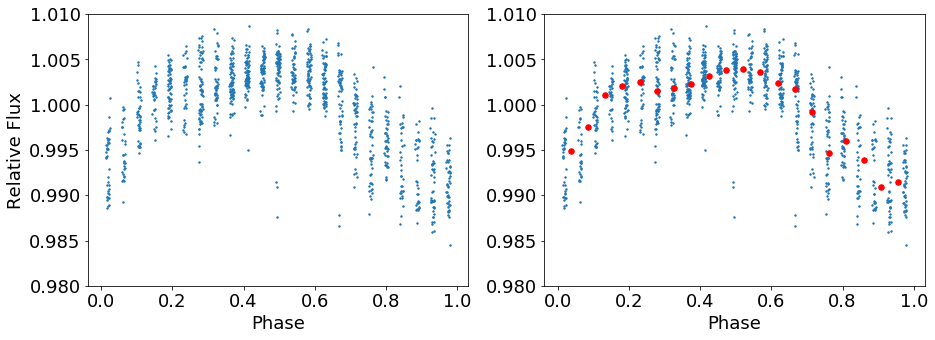

In [198]:
t = obj.timeseries_binned
f = obj.flux_binned
p = obj.cleaned_refined_periods[0]
new_moon_epoch = 0
phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(15,5))
ax.scatter(phase_app, data_app, s=2)
ax.set_xlabel('Phase')
ax.set_ylabel('Relative Flux')
ax.set_ylim([0.98, 1.01])

ax1.scatter(phase_app, data_app, s=2)
ax1.set_xlabel('Phase')
ax1.set_ylim([0.98, 1.01])
ax1.scatter(binned_phase_app, binned_data_app, s=30, c='r')

plt.savefig('phase_ratio.pdf')

plt.show()

In [70]:
obj = field[70]
loc = EarthLocation.of_site('Cerro Paranal')
tmed =  np.median(obj.timeseries_binned)
ts = np.linspace(min(obj.timeseries_binned), max(obj.timeseries_binned), 200)
# print loc
moon_sep = [get_moon(Time(t + utils.NGTS_EPOCH, format='jd'), location=loc).separation(NGTSFieldCentre) for t in ts]
moon_illum = [moon_illumination(Time(t + utils.NGTS_EPOCH, format='jd')) for t in ts]
# moon_sep2 = [get_moon(Time(t + utils.NGTS_EPOCH, format='jd')) for t in ts]
# print moon_sep
# print moon_sep2

In [71]:
# moon_illum = [moon_illumination(Time(t + utils.NGTS_EPOCH, format='jd')) for t in ts]

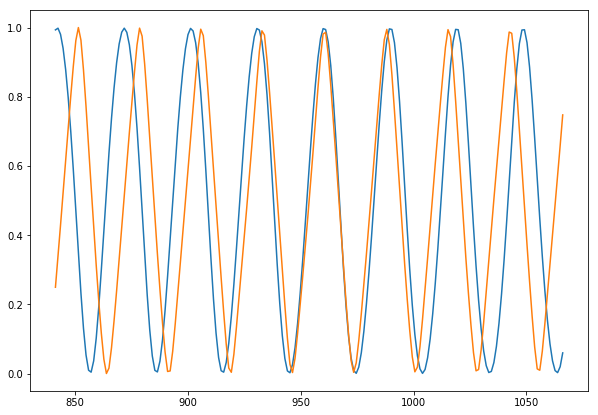

In [72]:
moon_sep_scaled = [m.radian for m in moon_sep]
moon_sep_scaled = ((np.array(moon_sep_scaled) - min(moon_sep_scaled)))
moon_sep_scaled = (moon_sep_scaled / max(moon_sep_scaled) - 1.0 )* -1.0
fig, ax = plt.subplots(figsize=(10,7))
# ax1 = ax.twinx()
# ax.scatter(obj.timeseries_binned, obj.flux_binned, s=0.2)
# ax1.plot(ts, [m.radian for m in moon_sep])
ax.plot(ts, moon_illum)
ax.plot(ts, moon_sep_scaled)
plt.show()

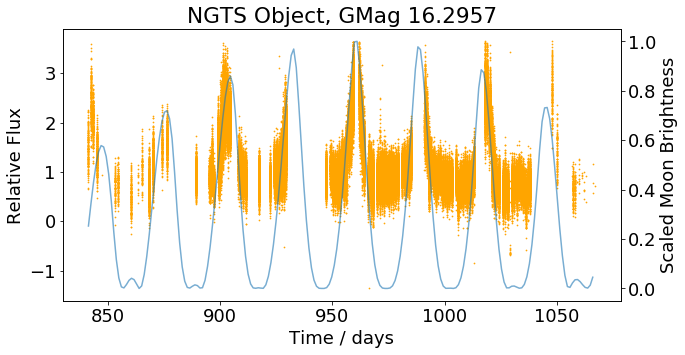

In [90]:
obj = field[70]
mpl.rcParams.update({'font.size': 18})
moonbright = [m[0] * m[1] for m in zip(moon_sep_scaled, moon_illum)]
mm = max(moonbright)
moonbright = [m/mm for m in moonbright]
fig, ax = plt.subplots(figsize=(10,5))
ax1 = ax.twinx()
# ax.set_ylim([0.8, 1.2])
ax1.plot(ts, moonbright, alpha=0.6)
ax.scatter(obj.timeseries, obj.flux, s=0.5, c='orange')
ax.set_xlabel('Time / days')
ax.set_ylabel('Relative Flux')
ax1.set_ylabel('Scaled Moon Brightness')
ax.set_title('NGTS Object, GMag {}'.format(obj.Gaia_Gmag))

plt.savefig('Moon_Brightness_Model.pdf')
# ax1.plot(ts, rads)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax1 = ax.twinx()
# ax.set_ylim([0.8, 1.2])
phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
ax.scatter(phase_app, data_app, s=0.5)
phase_app1, data_app1 = utils.append_to_phase(utils.create_phase(ts, p, new_moon_epoch), moonbright, 0)
ax1.scatter(phase_app1, data_app1, s=5, c='orange', alpha=0.5)
# ax1.plot(ts, rads)
plt.show()

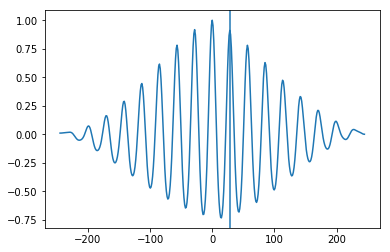

In [109]:
from GACF import find_correlation_from_lists_cpp
lt, c, _ = find_correlation_from_lists_cpp(ts, moonbright)
plt.plot(lt, c)
plt.axvline(x=28.5)
plt.show()

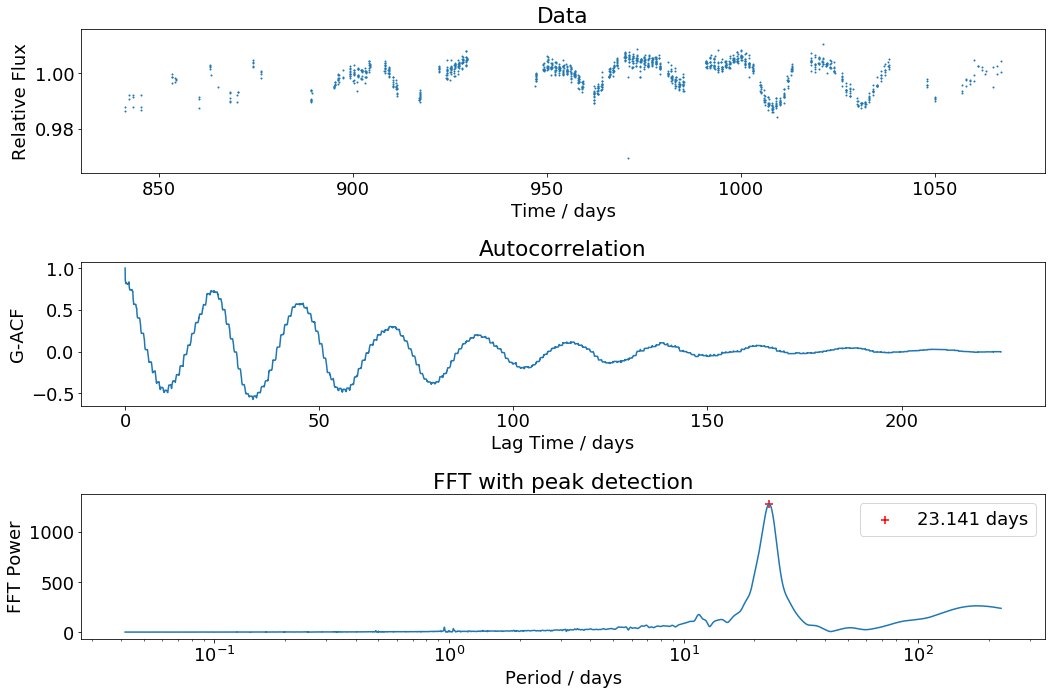

In [16]:
plt.rcParams.update({'font.size': 18})
obj = field[31335]
fig, axs = plt.subplots(3, 1, figsize=(15,10))
ax, ax1, ax2 = axs
ax.scatter(obj.timeseries_binned, obj.flux_binned, s=1)
ax.set_title('Data')
ax.set_ylabel('Relative Flux')
ax.set_xlabel('Time / days')
# ax.set_ylim([0.95, 1.05])

obj.min_lag = 0
obj.calculate_periods_from_autocorrelation()

ax1.plot(obj.lag_timeseries, obj.correlations)
ax1.set_xlabel('Lag Time / days')
ax1.set_ylabel('G-ACF')
ax1.set_title('Autocorrelation')

ax2.plot(obj.period_axis, obj.ft)
ax2.set_xlabel('Period / days')
ax2.set_ylabel('FFT Power')
ax2.set_title('FFT with peak detection')
ax2.set_xscale('log')

ax2.scatter(obj.period_axis[obj.peak_indexes], obj.ft[obj.peak_indexes], s=50, c='r', marker='+',
            label='{:.3f} days'.format(obj.periods[0]))
ax2.legend()

plt.tight_layout()

plt.savefig('Example_Clean_Object.pdf')
plt.show()

In [110]:
altaz = [AltAz(obstime=Time(t + utils.NGTS_EPOCH, format='jd'), location=loc) for t in ts]
moons = [get_moon(Time(t + utils.NGTS_EPOCH, format='jd')) for t in ts]
moonp = [moon.transform_to(altaz[i]) for i, moon in enumerate(moons)]

In [ ]:
rads = np.array([float(m.alt.radian) for m in moonp])
idx_ok = np.argwhere(np.array(moonp) > 0)
rads[idx_ok]

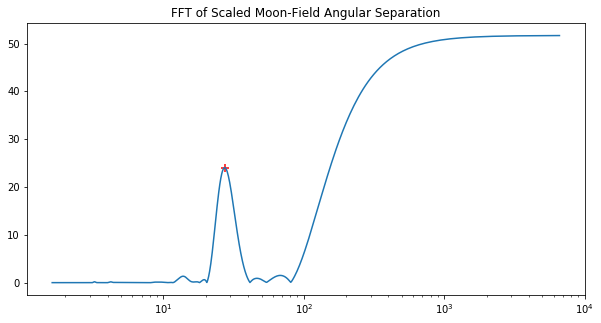

[27.32903053]


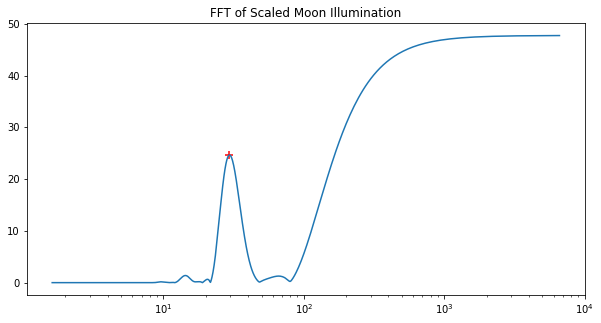

[29.52511334]


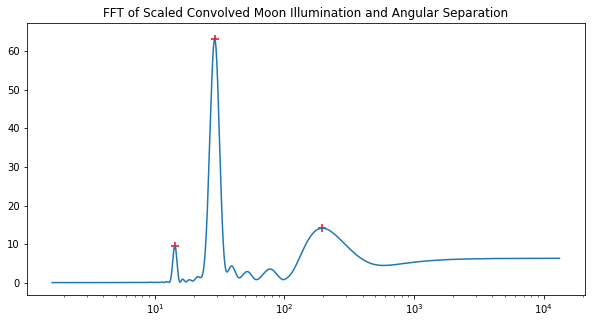

[194.51839377  28.94365597  14.2842881 ]


In [98]:
from scipy.signal import hann
ft1, p1, i1 = utils.fourier_transform_and_peaks(moon_sep_scaled * hann(len(ts)), ts)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(p1, ft1)
ax.set_xscale('log')
ax.set_title('FFT of Scaled Moon-Field Angular Separation')
# ax.set_xlim([0.01, 1000])
ax.scatter(p1[i1], ft1[i1], marker='+', c='r', s=50)
plt.show()
print p1[i1]

ft1, p1, i1 = utils.fourier_transform_and_peaks(moon_illum * hann(len(ts)), ts)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(p1, ft1)
ax.set_xscale('log')
ax.set_title('FFT of Scaled Moon Illumination')
# ax.set_xlim([0.01, 1000])
ax.scatter(p1[i1], ft1[i1], marker='+', c='r', s=50)
plt.show()
print p1[i1]

ft1, p1, i1 = utils.fourier_transform_and_peaks(c, lt)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(p1, ft1)
ax.set_xscale('log')
ax.set_title('FFT of Scaled Convolved Moon Illumination and Angular Separation')
# ax.set_xlim([0.01, 1000])
ax.scatter(p1[i1], ft1[i1], marker='+', c='r', s=50)
plt.show()
print p1[i1]

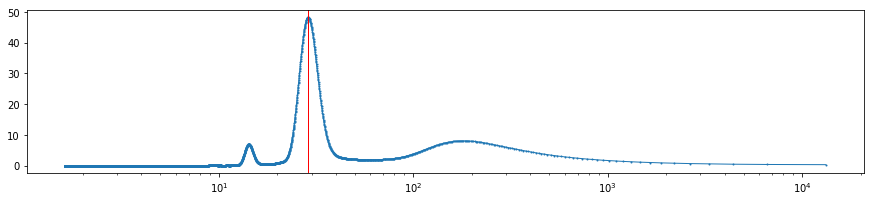

Out: [ 28.75489299 181.19521612  14.25350299]


28.754892992479324

In [113]:
refine_period(np.array(lt), np.array(c), 28.94365597)

In [111]:
def refine_period(t, x, p, n=5):
    idxs = np.where(np.abs(t) < n * p)[0]
    x2 = np.array(x)[idxs]
    t2 = np.array(t)[idxs]

    hm = np.hamming(len(x2))
    x2 = hm * x2

    ft2, p2, i2 = utils.fourier_transform_and_peaks(x2, t2)
    ps2 = np.array([pair[0] for pair in sorted([q for q in zip(p2[i2], ft2[i2])], key=lambda x: x[1], reverse=True)])
    pc = ps2[np.argmin(np.abs(ps2 - p))]

    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(p2, ft2, marker='o', ms=1, lw=1)
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.axvline(x=pc, lw=1, c='r')
    plt.show()
    print 'Out:', ps2

    return pc

In [13]:
fieldg = NGTSField(fieldname=fieldname, test='CYCLE1807', object_list=moon_objs)
fieldg = load_gaia_params(fieldg)
moonsup = []
moonsdown = []
for o, up in zip(moon_objs, moon_up):
    fieldg[o].moon_up = up
    if up == 'HIGHER':
        moonsup.append(fieldg[o].NGTS_I_3)
    elif up == 'LOWER':
        moonsdown.append(fieldg[o].NGTS_I_3)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1104 / length of dimension 1                          NAXIS2  =                 8957 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                  147 / number of table fields                         TTYPE1  = 'Sequence_number'                                                     TFORM1  = 'D       '                                                            TTYPE2  = 'RA_DEG  '                                                            TFORM2  = 'D       '                                                            TTYPE3  = 'DEC_DEG '                    

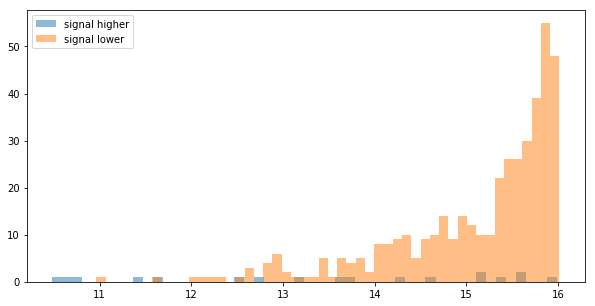

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(moonsup, bins=50, alpha=0.5, label='signal higher')
plt.hist(moonsdown, bins=50, alpha=0.5, label='signal lower')
plt.legend()
plt.show()

In [15]:
for obj in fieldg:
    try:
        print obj.moon_up
    except AttributeError:
        print 'YEET'

None
LOWER
LOWER
HIGHER
LOWER
LOWER
LOWER
LOWER
None
LOWER
None
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
HIGHER
LOWER
LOWER
None
LOWER
LOWER
None
HIGHER
LOWER
LOWER
HIGHER
LOWER
None
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
None
None
None
None
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
HIGHER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
None
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
None
None
LOWER
LOWER
LOWER
None
LOWER
None
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
HIGHER
LOWER
LOWER
None
None
LOWER
N

In [66]:
# load half moon periods
with open('/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS/NG2142+0826/NGTS_Field_NG2142+0826_pdic.json', 'r') as f:
    pdic = json.load(f)

pdic = {int(k):v for k,v in pdic.iteritems()}
# print pdic

print '{} periods found'.format(len(pdic))


95 periods found


In [8]:
def do_plots(obj):
    n=4
    fig, ax = plt.subplots(2,2, figsize=(10, 5))
    ax[0,0].scatter(obj.timeseries_binned, obj.flux_binned, s=0.5)
    ax[1,0].scatter(obj.lag_timeseries, obj.correlations, s=0.5)
    ft_max = max(obj.ft)
    ax[0,1].plot(obj.period_axis, obj.ft/ft_max, lw=0.5, marker='.', ms=0.5)
    ax[0,1].set_xscale('log')
    ax[0,1].set_xlim(right=100)
    ax[0,1].scatter(obj.period_axis[obj.peak_indexes], obj.ft[obj.peak_indexes]/ft_max, marker='+', s=40, c='r')
    peaks = obj.ft[obj.peak_indexes] / ft_max
    peaksplot = np.linspace(1, len(peaks), len(peaks))
    ax[1,1].scatter(peaksplot, peaks)
    ft_ave = np.mean(obj.ft) / ft_max
    peaks_ave = np.mean(peaks)
    ax[1,1].axhline(y=ft_ave, c='g', label='FT mean')
    ax[1,1].axhline(y=peaks_ave, c='r', label='Peaks mean')
    plt.show()
    p = obj.cleaned_refined_periods[0]
    t = obj.timeseries_binned
    f = obj.flux_binned
    phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
    binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    ndata = len(phase_app)
    idx = [i for i in range(1,ndata) if phase_app[i]<phase_app[i-1] ]
    idx.append(ndata-1)
    nidx = len(idx)
    colours = mpl.cm.rainbow(np.r_[0:1:nidx*1j])
    phases, fs = [], []
    j=0
    for k,i in enumerate(idx):
        phases.append( np.array(phase_app[j:i]) )
        fs.append( np.array(f[j:i]) )
        ax.scatter(phases[k], fs[k], marker='o', s=1, c=colours[k])
        j=i
    
#     ax.scatter(phase_app, data_app, s=0.1)
    ax.scatter(binned_phase_app, binned_data_app, marker='+', s=5, c='k')
    ax.axvline(x=0, lw=0.1, c='k', ls='--')
    ax.axvline(x=1, lw=0.1, c='k', ls='--')
    ax.set_title('Data phase folded on {} day period'.format(p))
    plt.show()

In [13]:
def get_new_moon_epoch(timeseries):
    med_time = np.median(timeseries)
    moon_time = np.linspace(med_time - 30, med_time + 30, 100)
    moons = [moon_illumination(Time(t + utils.NGTS_EPOCH, format='jd')) for t in moon_time]
    moon_epoch = Time(moon_time[np.argmin(moons)], format='jd').jd
#     fig, ax = plt.subplots(figsize=(10,5))
#     ax.plot(moon_time, moons)
#     ax.axvline(x=moon_time[np.argmin(moons)])
    return moon_epoch, moon_time, moons

new_moon_epoch, moon_time, moons = get_new_moon_epoch(field[field.objects.keys()[0]].timeseries_binned)

In [11]:
field = return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807', obj_ids=[o[0] for o in half_moon_objs])
field = load_gaia_params(field)


matched 8957 of 9346 files
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1104 / length of dimension 1                          NAXIS2  =                 8957 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                  147 / number of table fields                         TTYPE1  = 'Sequence_number'                                                     TFORM1  = 'D       '                                                            TTYPE2  = 'RA_DEG  '                                                            TFORM2  = 'D       '                                                            TTYPE3  = 'DE

TypeError: 'NoneType' object is not iterable

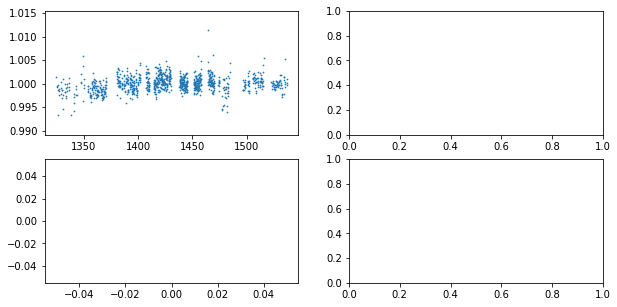

In [9]:
for obj in field:
    do_plots(obj)

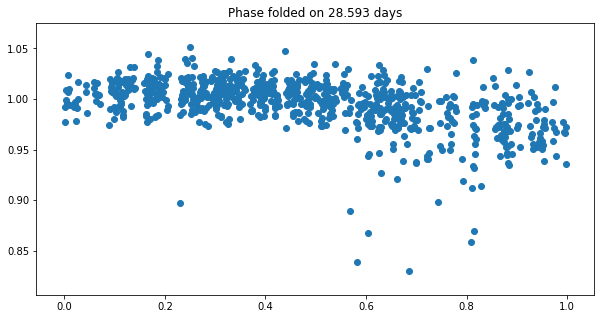

In [76]:
# new work June 2019 - based on Didier Skype. Phase fold on moon period, then in half again.
# 3 parameter model - flat line + slope with changepoint.

# calculate 3 points -> (0, median1), (X, median1), (1, median2). Fit for 3 values.

fig, ax = plt.subplots(figsize=(10,5))
t = obj.timeseries_binned
f = obj.flux_binned
# new_moon_epoch = field.get_new_moon_epoch()
new_moon_epoch = 827.4207774265543
phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
half_phase_app = fold_phase_in_half(phase_app)
# binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
ax.scatter(half_phase_app, data_app)
ax.set_title('Phase folded on {} days'.format(p))
plt.show()

In [13]:

from scipy.optimize import curve_fit
def half_phase(p):
    if 0.0 <= p <= 0.5:
        return 2.0 * p
    elif 0.5 < p <= 1.0:
        return 2.0 - (2 * p)
    else:
        return np.nan
        
def fold_phase_in_half(phase):
    return map(half_phase, phase)

def define_fit_function(phase, X, h1, h2):
    # 3 parameter fit. Straight line at h1 up to phase X, slope from h1 to h2 from X to 1.
    def funn(p, X, h1, h2):
        if 0 <= p <= X:
            return h1
        elif X < p <= 1.0:
            return np.interp(p, (X, 1), (h1, h2))
        else:
            return np.nan
    return [funn(p, X, h1, h2) for p in phase]

In [26]:
# test = np.random.rand(10)
# plt.scatter(test, fold_phase_in_half(test))
# plt.show()

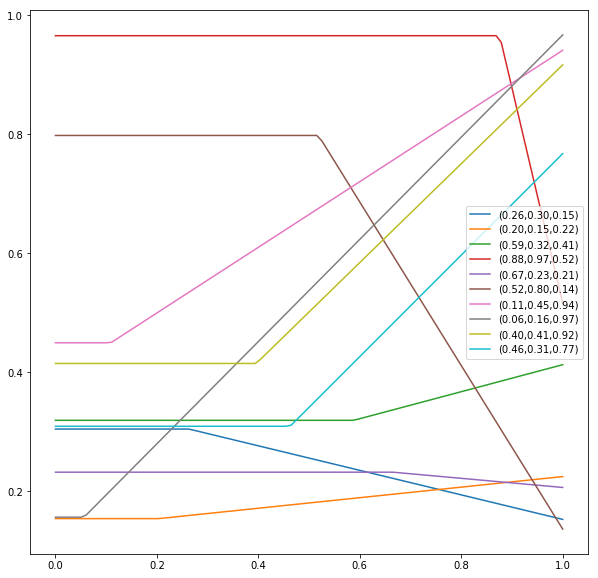

In [94]:
phase = np.linspace(0,1 , 100)
n = 10
X = np.random.rand(n)
h1 = np.random.rand(n)
h2 = np.random.rand(n)
fig = plt.figure(figsize=(10,10))
for i in range(n):
    plt.plot(phase, define_fit_function(phase, X[i], h1[i], h2[i]), label='({:.2f},{:.2f},{:.2f})'.format(X[i], h1[i], h2[i]))
plt.legend()
plt.show()

In [96]:

popt, pcov = curve_fit(define_fit_function, half_phase_app, data_app, [0.8, 1.05, 0.95])

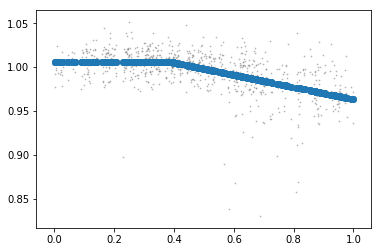

In [100]:
plt.scatter(half_phase_app, data_app, s=0.5, c='gray', alpha=0.5)
plt.scatter(half_phase_app, define_fit_function(half_phase_app, *popt), label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

[21352]
matched 8569 of 8927 files. Loaded 1 objects


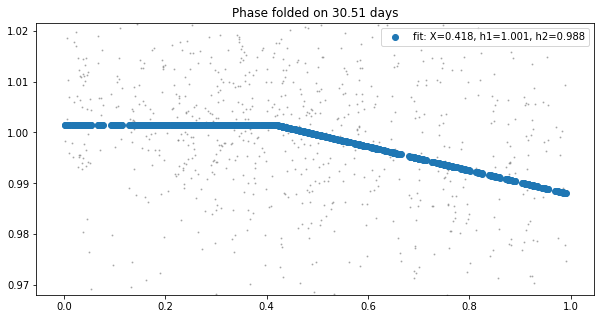

In [118]:
i = np.random.randint(0, len(moon_objs)-1)
obj_id = [moon_objs[i]]
p = moon_periods[i]
print obj_id
# obj_id = [19246]
field = return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807', obj_ids=obj_id)
fits_file,_,_ = find_fits_file(directory=field.filename)
field.load_from_fits(fits_file, obj_ids=obj_id, method='fitsio', sparse_ids=True)
field = load_gaia_params(field)
obj = field[field.objects.keys()[0]]
fig, ax = plt.subplots(figsize=(10,5))
t = obj.timeseries_binned
f = obj.flux_binned
new_moon_epoch = 827.4207774265543
phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
half_phase_app = fold_phase_in_half(phase_app)
ax.set_title('Phase folded on {} days'.format(p))
popt, pcov = curve_fit(define_fit_function, half_phase_app, data_app, [0.8, 1.05, 0.95])
ax.scatter(half_phase_app, data_app, s=1, c='gray', alpha=0.5)
ax.scatter(half_phase_app, define_fit_function(half_phase_app, *popt), label='fit: X=%5.3f, h1=%5.3f, h2=%5.3f' % tuple(popt))
limits=popt[1:]
ax.legend()
ax.set_ylim([min(limits) * 0.98, max(limits) * 1.02])

plt.show()

In [50]:
n = 400
obj_idx = np.random.randint(0, len(moon_objs)-1, n)
ps = list(np.array(moon_periods)[obj_idx])
obj_id = list(np.array(moon_objs)[obj_idx])
# obj_id = [19246]
field = return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807', obj_ids=obj_id)
fits_file,_,_ = find_fits_file(directory=field.filename)
field.load_from_fits(fits_file, obj_ids=obj_id, method='fitsio', sparse_ids=True)
print 'Loaded field', field
# field = load_gaia_params(field)

matched 8569 of 8927 files. Loaded 339 objects


In [14]:
def split_time_series(t, f, tref, dt):
    t = np.array(t)
    f = np.array(f)
    
    treg = np.concatenate([np.r_[tref: t.min(): -dt][::-1],
                           np.r_[tref + dt: t.max():  dt]])
    nreg = len(treg)
    if nreg == 0 and (np.min(t) + dt > np.max(t)):
        # take whole series as input
        treg = [np.min(t)]
        nreg = 1
    freg = np.zeros(nreg) + np.nan
    return treg, freg, nreg


def split_and_compute_rms(t, f, tref, dt):
    with np.errstate(divide='ignore', invalid='ignore'):
        fpn = []
        treg, freg, nreg = split_time_series(t,f, tref, dt)
        for j in np.arange(nreg):
                l = np.logical_and((t >= treg[j]), (t < treg[j] + dt))
                if l.any():
                    # compute
                    fsl = f[l]
                    fpn.append(np.std(fsl))
        fpn = np.array(fpn)
        #     spread = np.median(fpn[:,1]-fpn[:,0])
        #     spread = np.median(np.diff(fpn))
        rms = np.nanmedian(fpn)
    return rms

*****
NGTS Object NG2142+0826_7680 (CYCLE1807)
Ratio above RMS: 13.348 ❌
RMS ratio after turning point 1.068 ❌
RMS ratio when folding in half 0.865 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.12 -> 0.14) ✅
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.25
------
OBJECT MOON DETERMINATION: False ✅


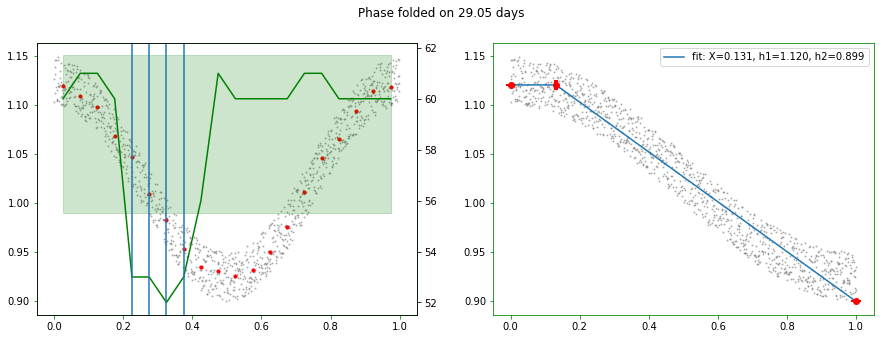

*****
NGTS Object NG2142+0826_8197 (CYCLE1807)
Ratio above RMS: 0.159 ✅
RMS ratio after turning point 0.973 ✅
RMS ratio when folding in half 1.022 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (-0.54 -> 0.74) ✅
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.00
------
OBJECT MOON DETERMINATION: False ✅


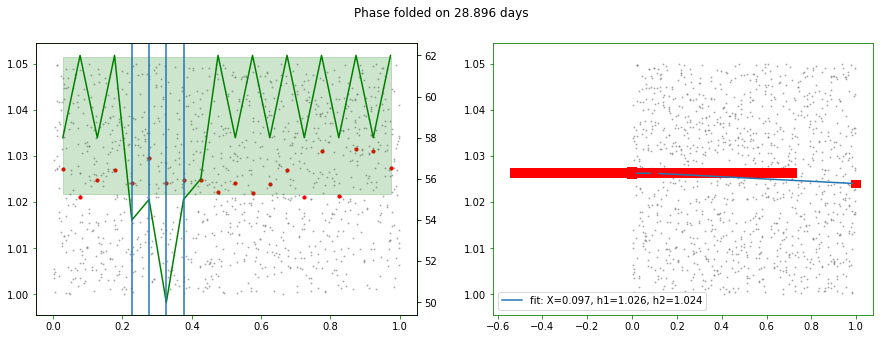

*****
NGTS Object NG2142+0826_31244 (CYCLE1807)
Ratio above RMS: 2.215 ❌
RMS ratio after turning point 1.703 ❌
RMS ratio when folding in half 1.088 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.61 -> 0.65) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.07
------
OBJECT MOON DETERMINATION: True ❌


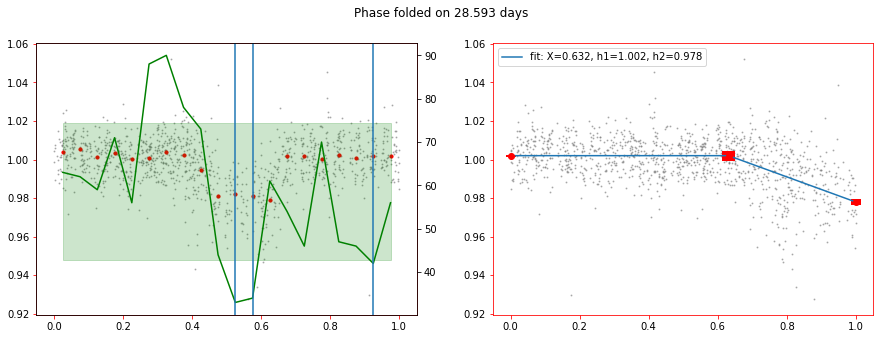

*****
NGTS Object NG2142+0826_23565 (CYCLE1807)
Ratio above RMS: 1.476 ❌
RMS ratio after turning point 1.172 ❌
RMS ratio when folding in half 1.072 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.44 -> 0.52) ❌
Empty bins around full moon: ❌
Data missing around full moon: ✅
Gradient -0.01
------
OBJECT MOON DETERMINATION: True ❌


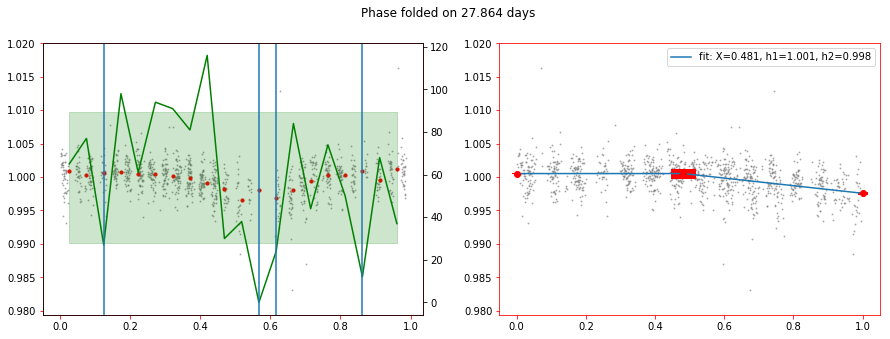

*****
NGTS Object NG2142+0826_14355 (CYCLE1807)
Ratio above RMS: 1.207 ❌
RMS ratio after turning point 1.233 ❌
RMS ratio when folding in half 0.959 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.30 -> 0.40) ✅
Empty bins around full moon: ❌
Data missing around full moon: ✅
Gradient -0.01
------
OBJECT MOON DETERMINATION: True ❌


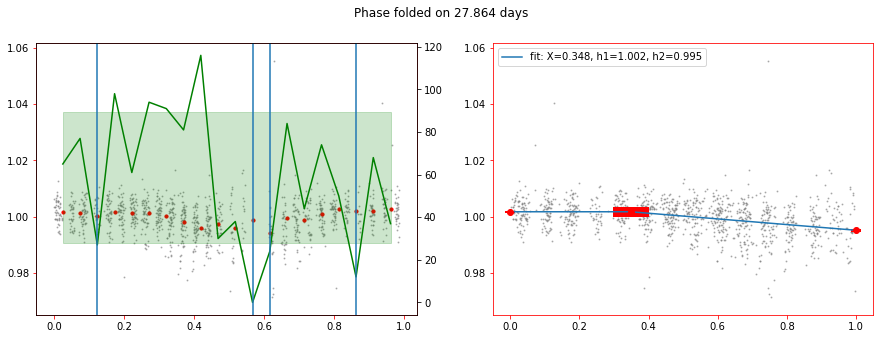

*****
NGTS Object NG2142+0826_18967 (CYCLE1807)
Ratio above RMS: 1.906 ❌
RMS ratio after turning point 1.512 ❌
RMS ratio when folding in half 1.077 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.61 -> 0.66) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.11
------
OBJECT MOON DETERMINATION: True ❌


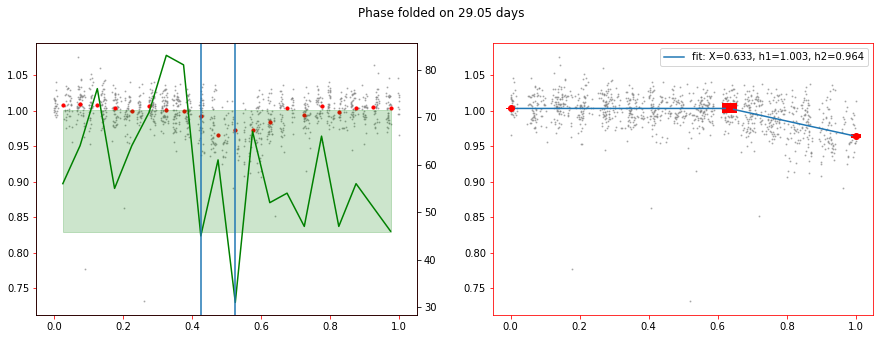

*****
NGTS Object NG2142+0826_22043 (CYCLE1807)
Ratio above RMS: 2.058 ❌
RMS ratio after turning point 1.671 ❌
RMS ratio when folding in half 1.137 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.63 -> 0.68) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.07
------
OBJECT MOON DETERMINATION: True ❌


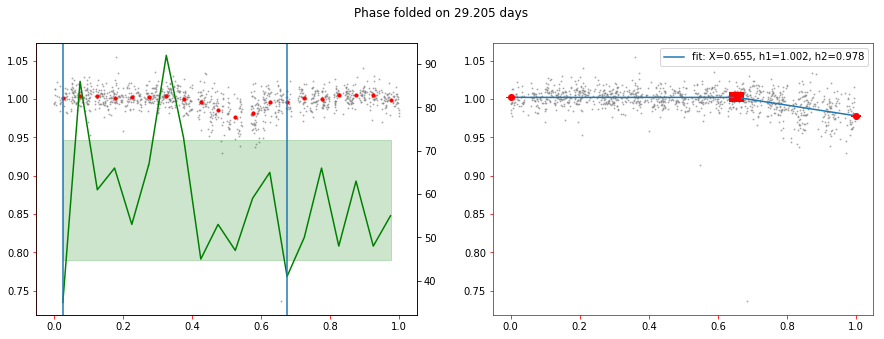

*****
NGTS Object NG2142+0826_31265 (CYCLE1807)
Ratio above RMS: 1.006 ❌
RMS ratio after turning point 1.510 ❌
RMS ratio when folding in half 1.150 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.60 -> 0.68) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.04
------
OBJECT MOON DETERMINATION: True ❌


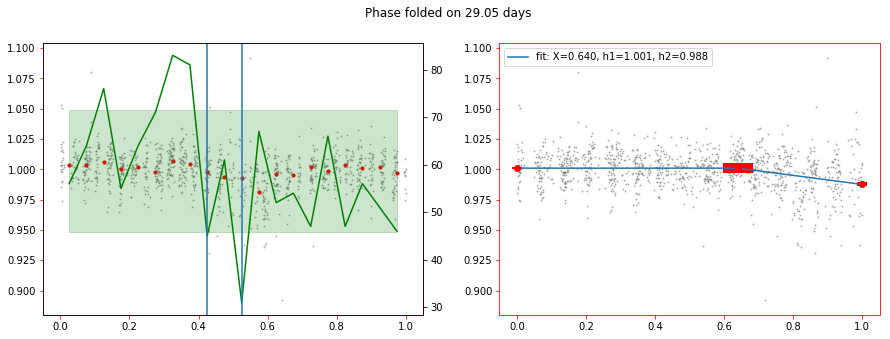

*****
NGTS Object NG2142+0826_29226 (CYCLE1807)
Ratio above RMS: 1.409 ❌
RMS ratio after turning point 1.722 ❌
RMS ratio when folding in half 1.288 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.63 -> 0.69) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.08
------
OBJECT MOON DETERMINATION: True ❌


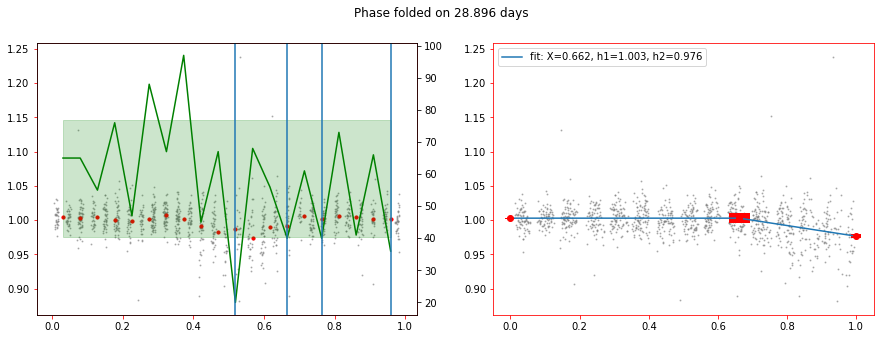

*****
NGTS Object NG2142+0826_25134 (CYCLE1807)
Ratio above RMS: 1.416 ❌
RMS ratio after turning point 1.264 ❌
RMS ratio when folding in half 1.010 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.66 -> 0.71) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.01
------
OBJECT MOON DETERMINATION: True ❌


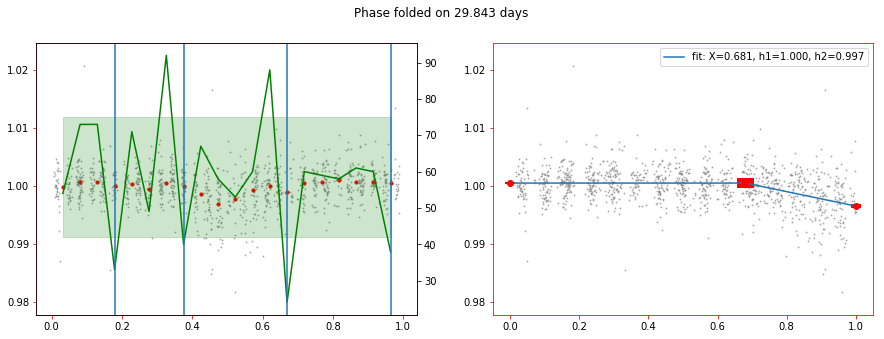

*****
NGTS Object NG2142+0826_28721 (CYCLE1807)
Ratio above RMS: 1.063 ❌
RMS ratio after turning point 1.185 ❌
RMS ratio when folding in half 1.056 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.72 -> 0.78) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.03
------
OBJECT MOON DETERMINATION: True ❌


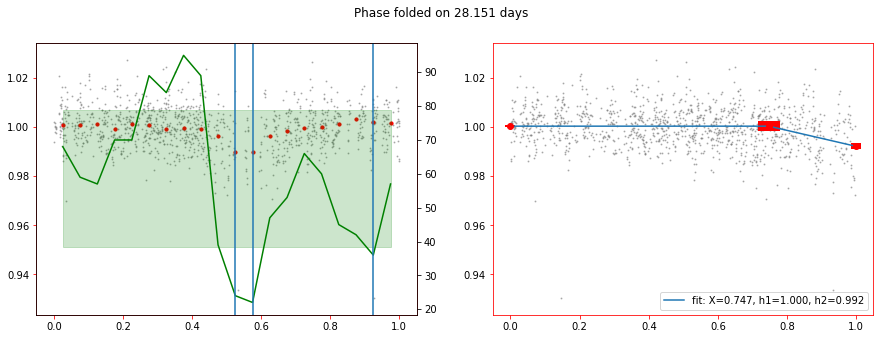

*****
NGTS Object NG2142+0826_21045 (CYCLE1807)
Ratio above RMS: 0.448 ✅
RMS ratio after turning point 1.225 ❌
RMS ratio when folding in half 0.948 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.13 -> 0.44) ✅
Empty bins around full moon: ❌
Data missing around full moon: ❌
Gradient -0.00
------
OBJECT MOON DETERMINATION: True ❌


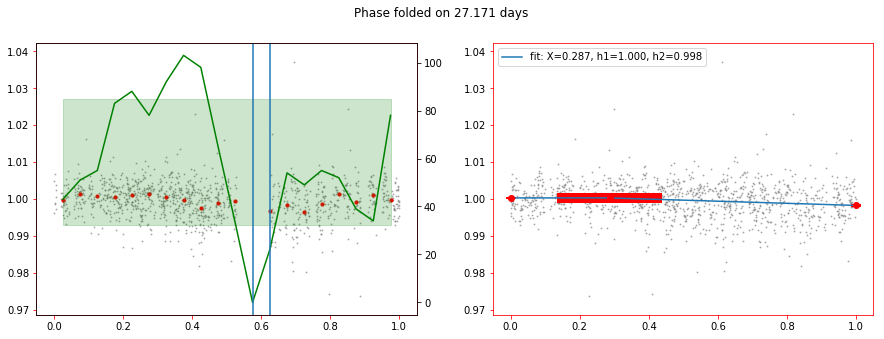

*****
NGTS Object NG2142+0826_27705 (CYCLE1807)
Ratio above RMS: 1.913 ❌
RMS ratio after turning point 1.648 ❌
RMS ratio when folding in half 1.247 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.63 -> 0.68) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.12
------
OBJECT MOON DETERMINATION: True ❌


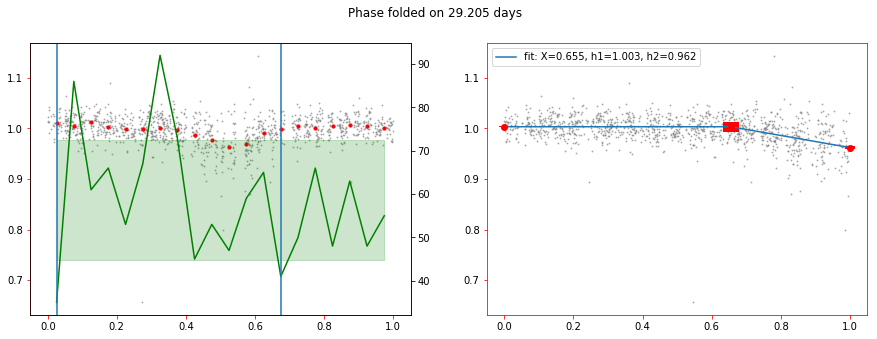

*****
NGTS Object NG2142+0826_23103 (CYCLE1807)
Ratio above RMS: 1.213 ❌
RMS ratio after turning point 1.326 ❌
RMS ratio when folding in half 1.012 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.54 -> 0.62) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.05
------
OBJECT MOON DETERMINATION: True ❌


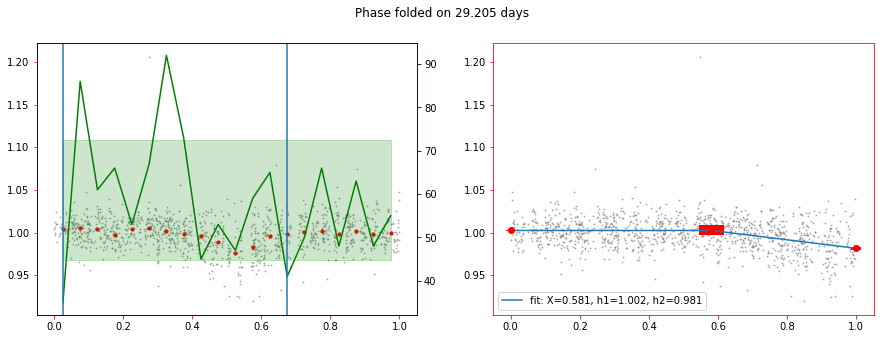

*****
NGTS Object NG2142+0826_30274 (CYCLE1807)
Ratio above RMS: 2.645 ❌
RMS ratio after turning point 2.245 ❌
RMS ratio when folding in half 1.333 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.64 -> 0.68) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.16
------
OBJECT MOON DETERMINATION: True ❌


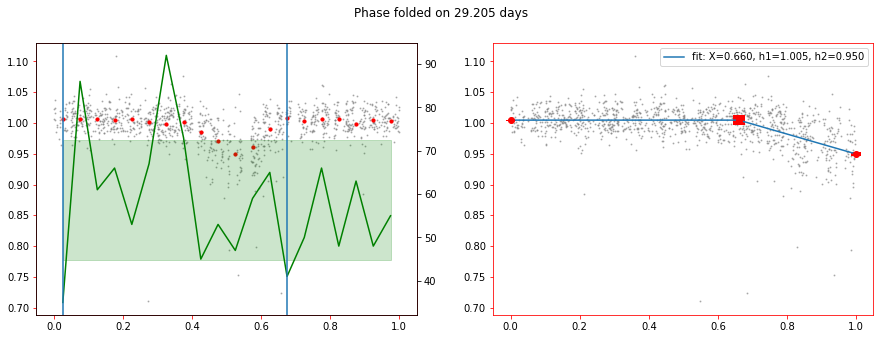

*****
NGTS Object NG2142+0826_70 (CYCLE1807)
Ratio above RMS: 6.754 ❌
RMS ratio after turning point 2.461 ❌
RMS ratio when folding in half 1.369 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.50 -> 0.52) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient 2.76
------
OBJECT MOON DETERMINATION: True ❌


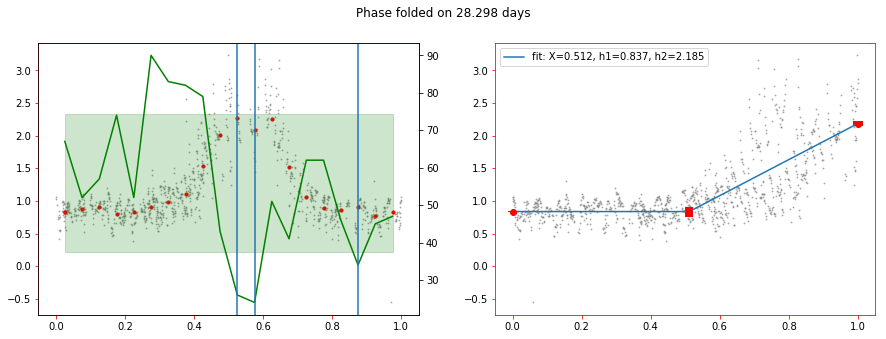

*****
NGTS Object NG2142+0826_5708 (CYCLE1807)
Ratio above RMS: 0.965 ✅
RMS ratio after turning point 1.479 ❌
RMS ratio when folding in half 1.168 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.77 -> 0.84) ✅
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.02
------
OBJECT MOON DETERMINATION: True ❌


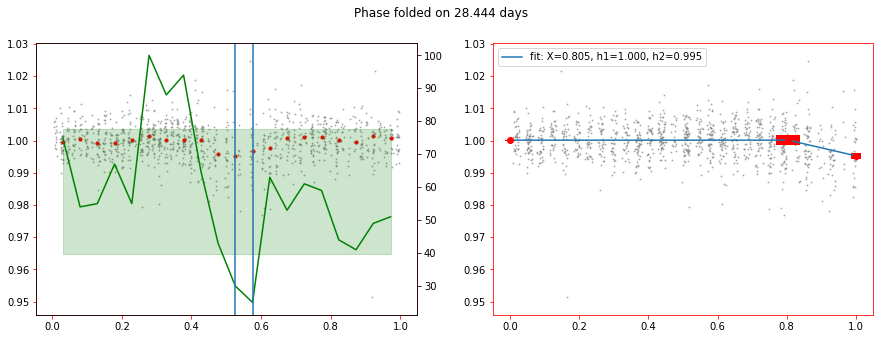

*****
NGTS Object NG2142+0826_26701 (CYCLE1807)
Ratio above RMS: 2.197 ❌
RMS ratio after turning point 1.559 ❌
RMS ratio when folding in half 1.173 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.60 -> 0.65) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.05
------
OBJECT MOON DETERMINATION: True ❌


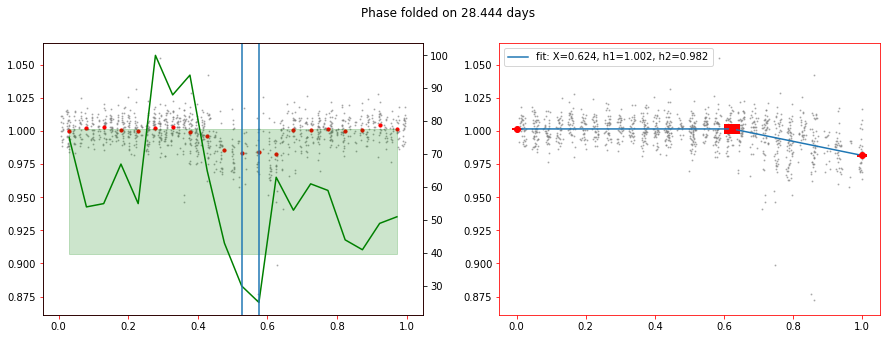

*****
NGTS Object NG2142+0826_32349 (CYCLE1807)
Ratio above RMS: 1.175 ❌
RMS ratio after turning point 1.457 ❌
RMS ratio when folding in half 0.992 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.61 -> 0.68) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.04
------
OBJECT MOON DETERMINATION: True ❌


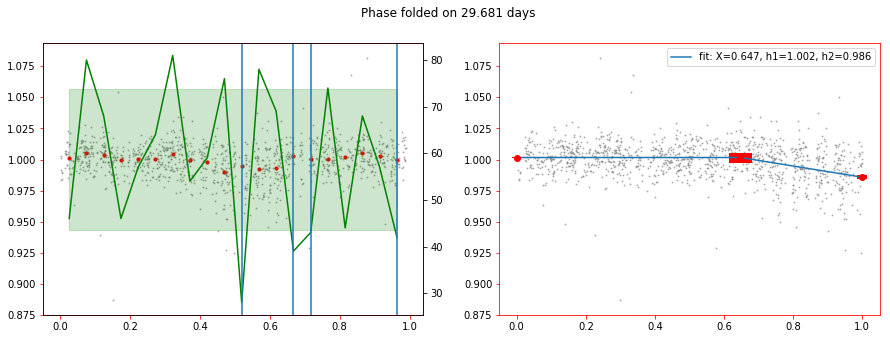

*****
NGTS Object NG2142+0826_13921 (CYCLE1807)
Ratio above RMS: 1.217 ❌
RMS ratio after turning point 1.234 ❌
RMS ratio when folding in half 1.035 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.58 -> 0.65) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.02
------
OBJECT MOON DETERMINATION: True ❌


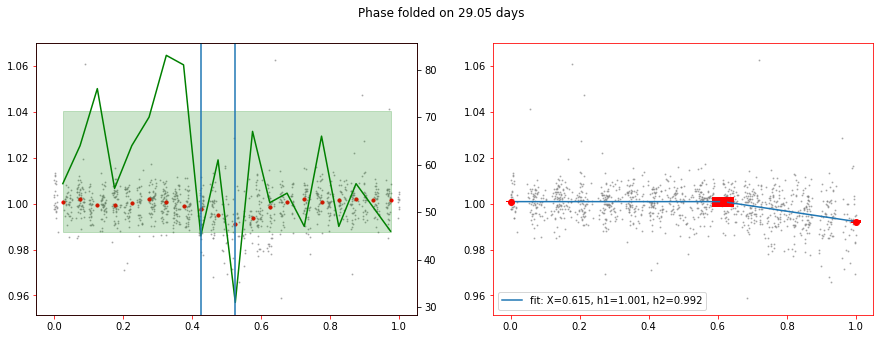

*****
NGTS Object NG2142+0826_10863 (CYCLE1807)
Ratio above RMS: 1.257 ❌
RMS ratio after turning point 1.176 ❌
RMS ratio when folding in half 1.065 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.62 -> 0.69) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.06
------
OBJECT MOON DETERMINATION: True ❌


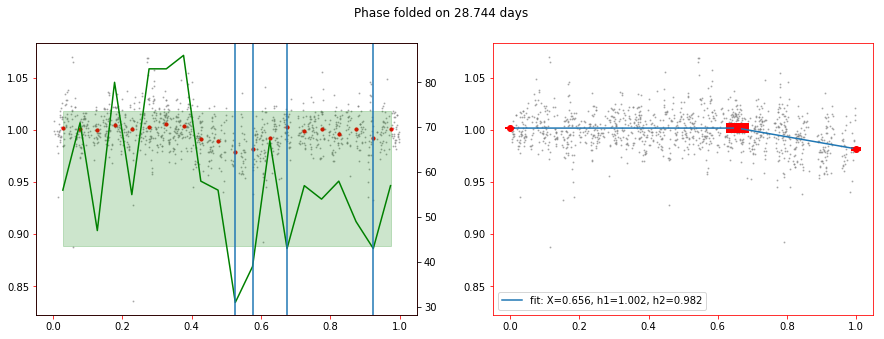

*****
NGTS Object NG2142+0826_17939 (CYCLE1807)
Ratio above RMS: 2.345 ❌
RMS ratio after turning point 1.518 ❌
RMS ratio when folding in half 1.070 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.64 -> 0.67) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.12
------
OBJECT MOON DETERMINATION: True ❌


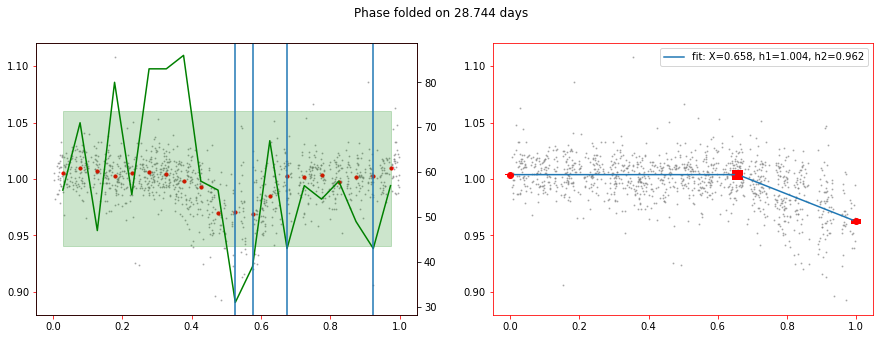

*****
NGTS Object NG2142+0826_11902 (CYCLE1807)
Ratio above RMS: 0.888 ✅
RMS ratio after turning point 1.282 ❌
RMS ratio when folding in half 1.007 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.32 -> 0.46) ✅
Empty bins around full moon: ❌
Data missing around full moon: ❌
Gradient -0.01
------
OBJECT MOON DETERMINATION: True ❌


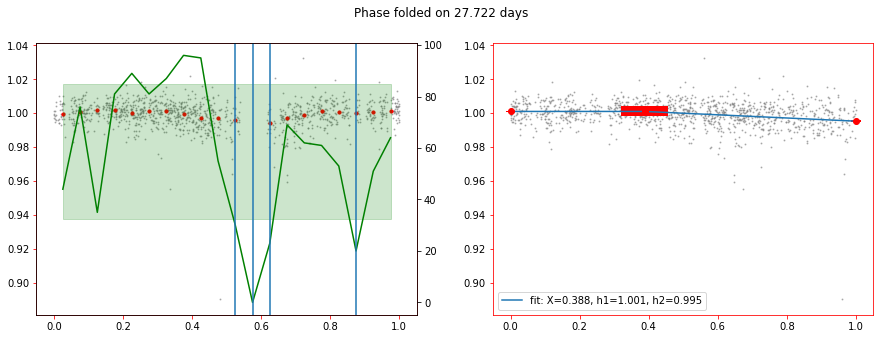

*****
NGTS Object NG2142+0826_18051 (CYCLE1807)
Ratio above RMS: 1.369 ❌
RMS ratio after turning point 1.265 ❌
RMS ratio when folding in half 1.050 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.60 -> 0.66) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.01
------
OBJECT MOON DETERMINATION: True ❌


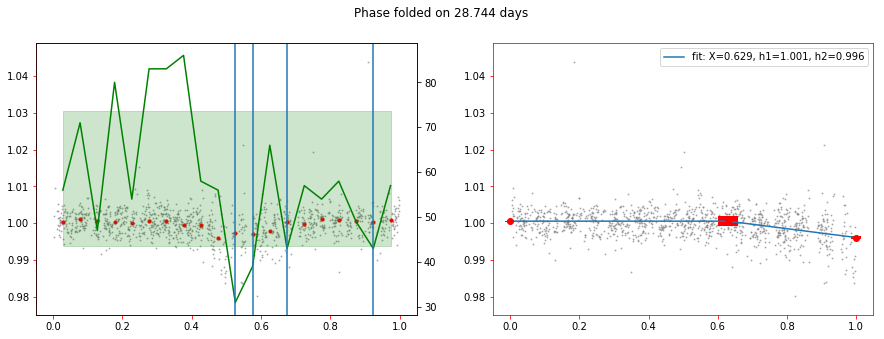

*****
NGTS Object NG2142+0826_6167 (CYCLE1807)
Ratio above RMS: 1.601 ❌
RMS ratio after turning point 1.672 ❌
RMS ratio when folding in half 1.033 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.63 -> 0.68) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.08
------
OBJECT MOON DETERMINATION: True ❌


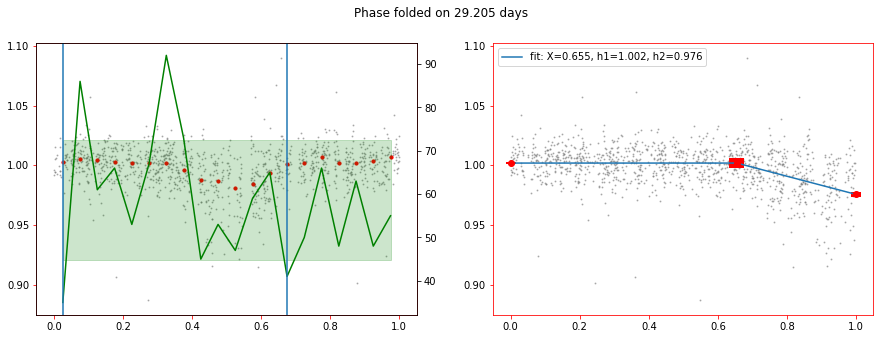

*****
NGTS Object NG2142+0826_31886 (CYCLE1807)
Ratio above RMS: 1.698 ❌
RMS ratio after turning point 1.409 ❌
RMS ratio when folding in half 1.129 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.67 -> 0.72) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.05
------
OBJECT MOON DETERMINATION: True ❌


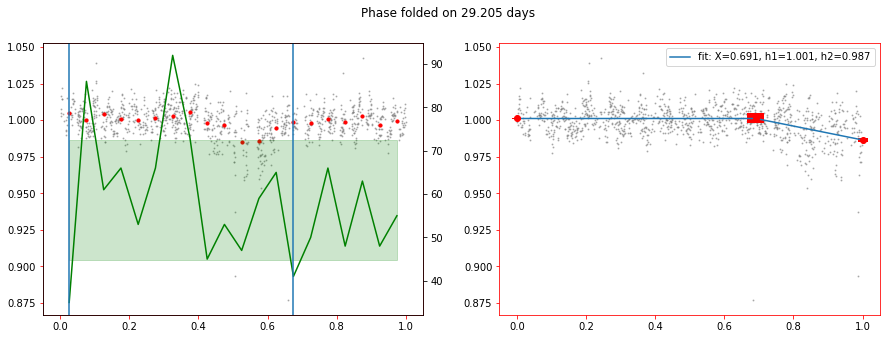

*****
NGTS Object NG2142+0826_7417 (CYCLE1807)
Ratio above RMS: 1.100 ❌
RMS ratio after turning point 1.231 ❌
RMS ratio when folding in half 0.975 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.39 -> 0.49) ✅
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.01
------
OBJECT MOON DETERMINATION: True ❌


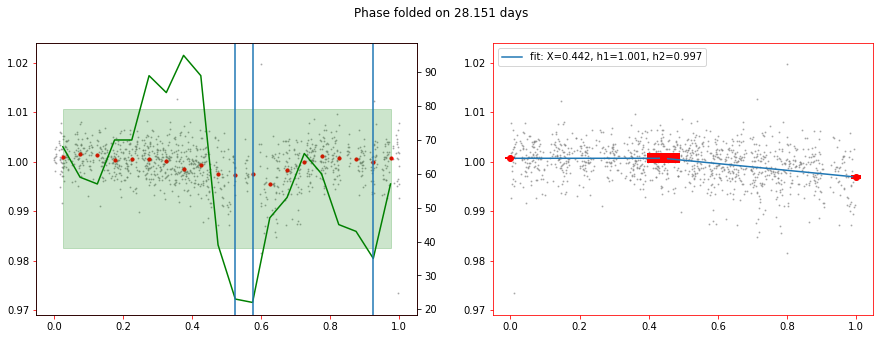

*****
NGTS Object NG2142+0826_6805 (CYCLE1807)
Ratio above RMS: 1.135 ❌
RMS ratio after turning point 1.681 ❌
RMS ratio when folding in half 1.045 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.56 -> 0.65) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.04
------
OBJECT MOON DETERMINATION: True ❌


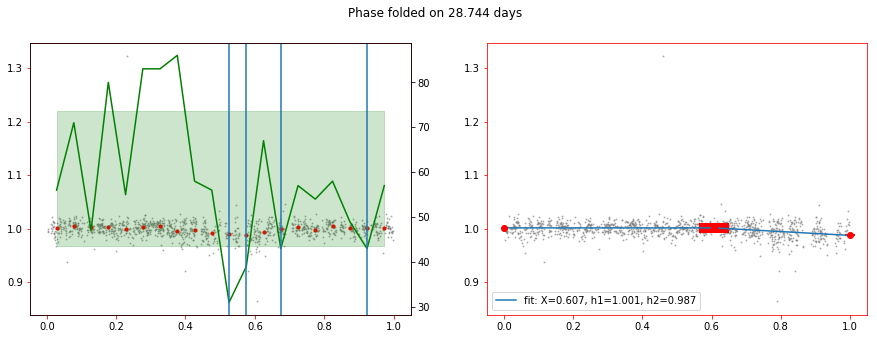

*****
NGTS Object NG2142+0826_30877 (CYCLE1807)
Ratio above RMS: 2.458 ❌
RMS ratio after turning point 1.669 ❌
RMS ratio when folding in half 1.138 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.59 -> 0.63) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.11
------
OBJECT MOON DETERMINATION: True ❌


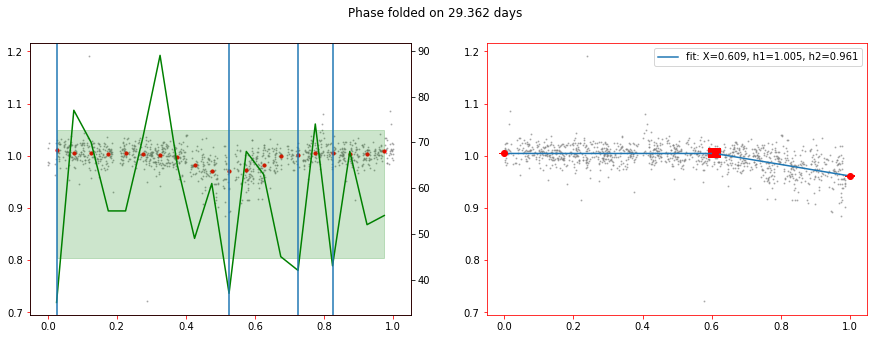

*****
NGTS Object NG2142+0826_19102 (CYCLE1807)
Ratio above RMS: 1.230 ❌
RMS ratio after turning point 1.163 ❌
RMS ratio when folding in half 1.093 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.52 -> 0.60) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.01
------
OBJECT MOON DETERMINATION: True ❌


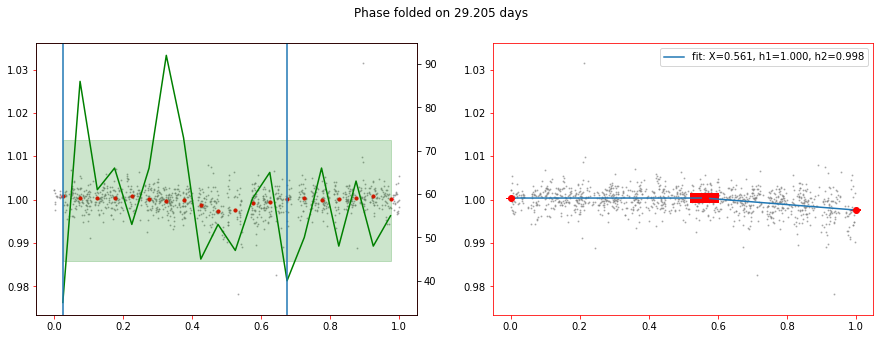

*****
NGTS Object NG2142+0826_22687 (CYCLE1807)
Ratio above RMS: 1.027 ❌
RMS ratio after turning point 1.077 ❌
RMS ratio when folding in half 1.019 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.53 -> 0.61) ❌
Empty bins around full moon: ❌
Data missing around full moon: ❌
Gradient -0.05
------
OBJECT MOON DETERMINATION: True ❌


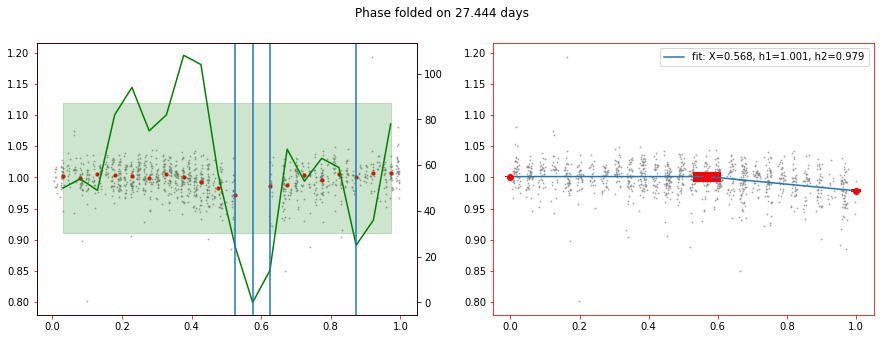

*****
NGTS Object NG2142+0826_5282 (CYCLE1807)
Ratio above RMS: 1.003 ❌
RMS ratio after turning point 1.251 ❌
RMS ratio when folding in half 0.981 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.58 -> 0.66) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.06
------
OBJECT MOON DETERMINATION: True ❌


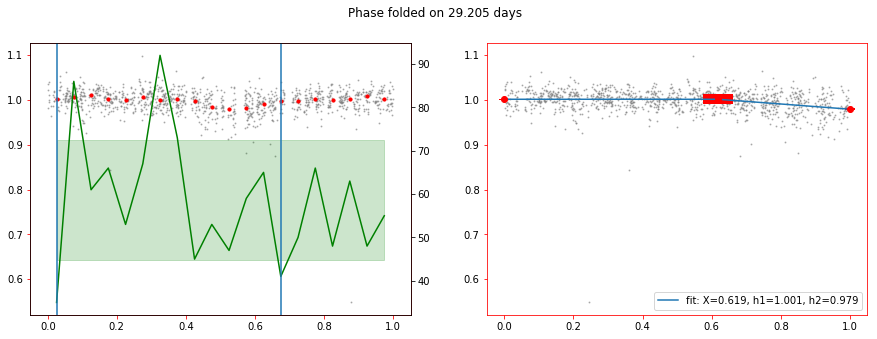

*****
NGTS Object NG2142+0826_31398 (CYCLE1807)
Ratio above RMS: 1.504 ❌
RMS ratio after turning point 1.491 ❌
RMS ratio when folding in half 1.081 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.61 -> 0.66) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.03
------
OBJECT MOON DETERMINATION: True ❌


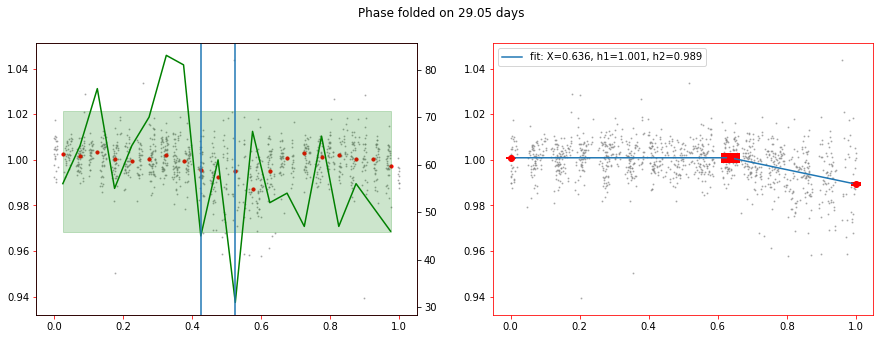

*****
NGTS Object NG2142+0826_27816 (CYCLE1807)
Ratio above RMS: 1.426 ❌
RMS ratio after turning point 1.668 ❌
RMS ratio when folding in half 1.058 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.63 -> 0.69) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.07
------
OBJECT MOON DETERMINATION: True ❌


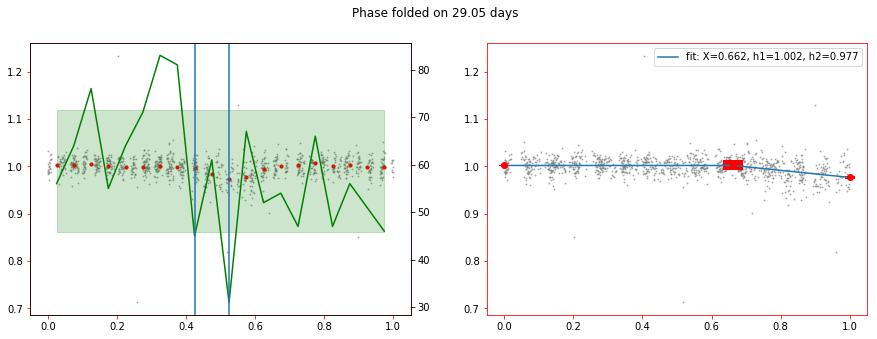

*****
NGTS Object NG2142+0826_15530 (CYCLE1807)
Ratio above RMS: 1.427 ❌
RMS ratio after turning point 1.293 ❌
RMS ratio when folding in half 1.129 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.80 -> 0.84) ✅
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.03
------
OBJECT MOON DETERMINATION: False ✅


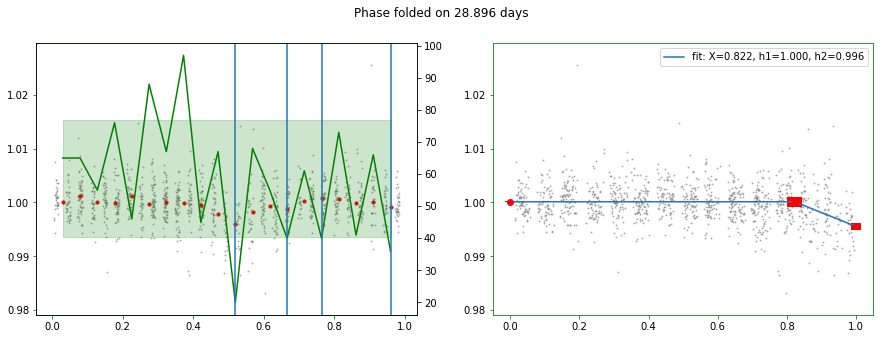

*****
NGTS Object NG2142+0826_3246 (CYCLE1807)
Ratio above RMS: 1.785 ❌
RMS ratio after turning point 1.292 ❌
RMS ratio when folding in half 1.060 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.53 -> 0.58) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.06
------
OBJECT MOON DETERMINATION: True ❌


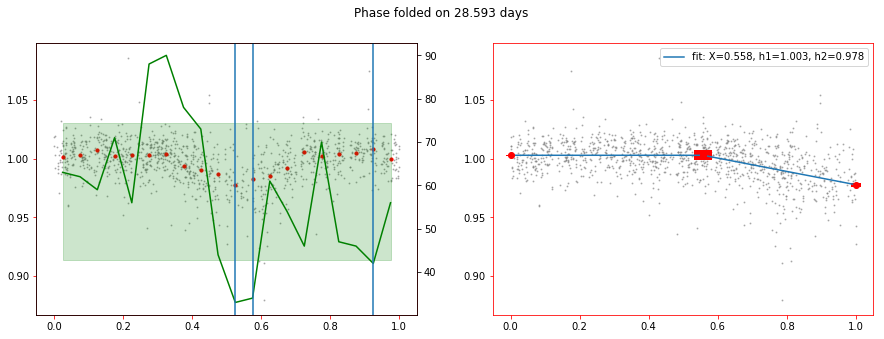

*****
NGTS Object NG2142+0826_17583 (CYCLE1807)
Ratio above RMS: 1.214 ❌
RMS ratio after turning point 1.471 ❌
RMS ratio when folding in half 1.123 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.63 -> 0.69) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.05
------
OBJECT MOON DETERMINATION: True ❌


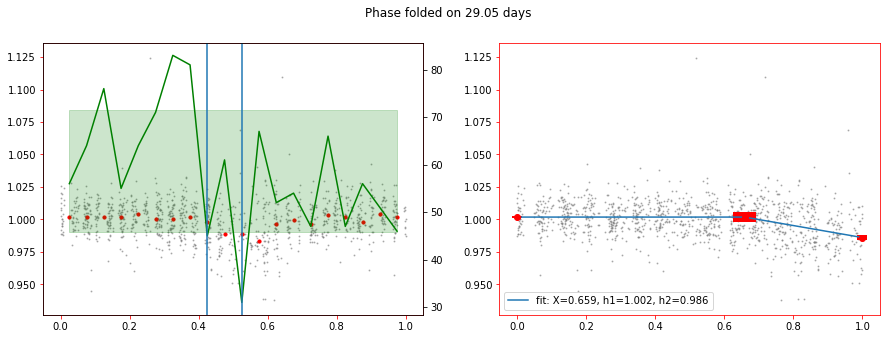

*****
NGTS Object NG2142+0826_20659 (CYCLE1807)
Ratio above RMS: 2.984 ❌
RMS ratio after turning point 1.668 ❌
RMS ratio when folding in half 1.186 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.62 -> 0.65) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.11
------
OBJECT MOON DETERMINATION: True ❌


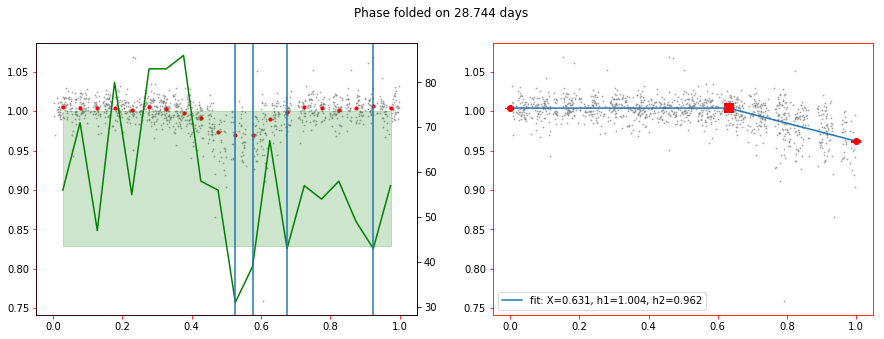

*****
NGTS Object NG2142+0826_22196 (CYCLE1807)
Ratio above RMS: 2.175 ❌
RMS ratio after turning point 1.533 ❌
RMS ratio when folding in half 1.148 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.66 -> 0.69) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.04
------
OBJECT MOON DETERMINATION: True ❌


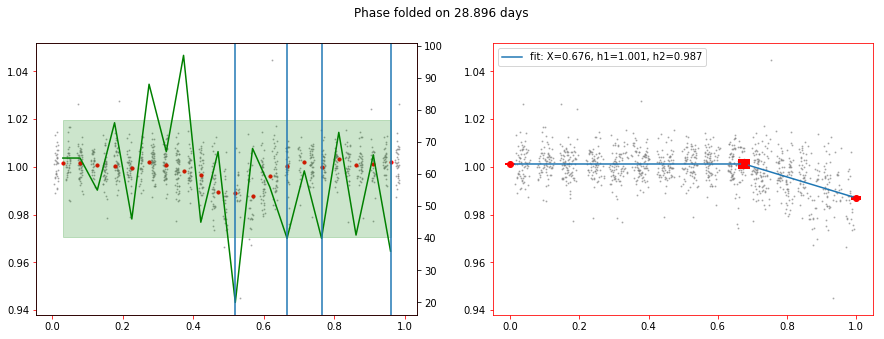

*****
NGTS Object NG2142+0826_25781 (CYCLE1807)
Ratio above RMS: 2.293 ❌
RMS ratio after turning point 1.634 ❌
RMS ratio when folding in half 1.233 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.67 -> 0.71) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.09
------
OBJECT MOON DETERMINATION: True ❌


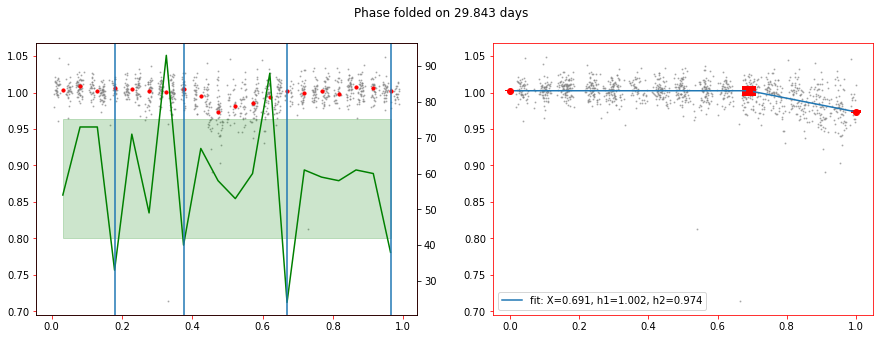

*****
NGTS Object NG2142+0826_30902 (CYCLE1807)
Ratio above RMS: 1.555 ❌
RMS ratio after turning point 1.257 ❌
RMS ratio when folding in half 1.056 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.59 -> 0.64) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.03
------
OBJECT MOON DETERMINATION: True ❌


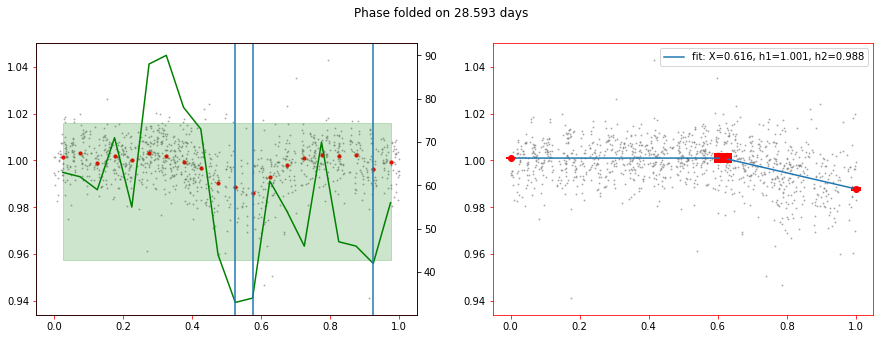

*****
NGTS Object NG2142+0826_18095 (CYCLE1807)
Ratio above RMS: 1.842 ❌
RMS ratio after turning point 1.412 ❌
RMS ratio when folding in half 1.202 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.67 -> 0.72) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.06
------
OBJECT MOON DETERMINATION: True ❌


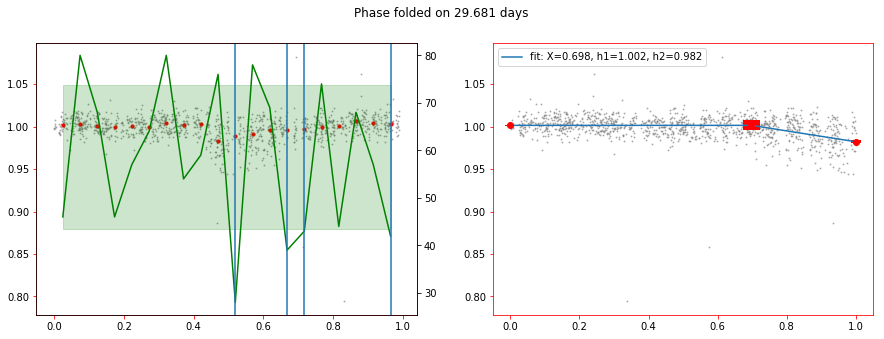

*****
NGTS Object NG2142+0826_24254 (CYCLE1807)
Ratio above RMS: 1.015 ❌
RMS ratio after turning point 1.312 ❌
RMS ratio when folding in half 1.007 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.64 -> 0.71) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.02
------
OBJECT MOON DETERMINATION: True ❌


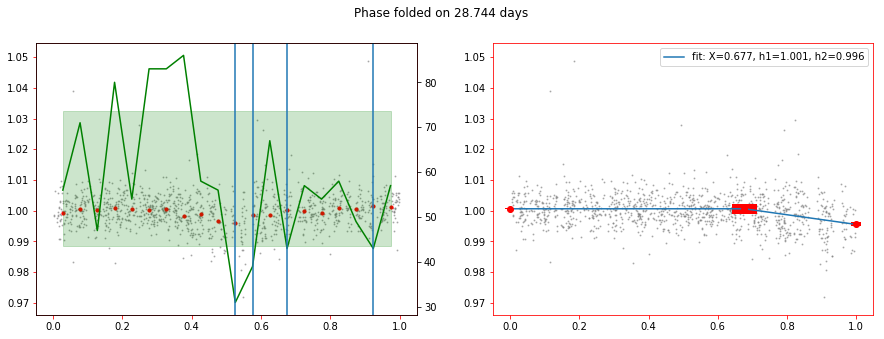

*****
NGTS Object NG2142+0826_19650 (CYCLE1807)
Ratio above RMS: 2.342 ❌
RMS ratio after turning point 1.607 ❌
RMS ratio when folding in half 1.152 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.65 -> 0.68) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.14
------
OBJECT MOON DETERMINATION: True ❌


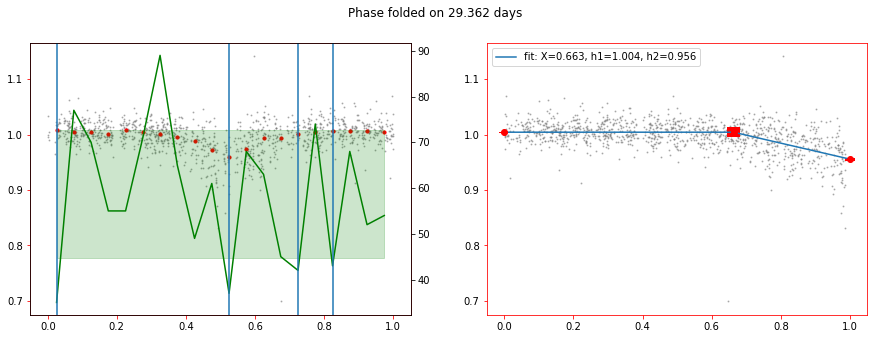

*****
NGTS Object NG2142+0826_715 (CYCLE1807)
Ratio above RMS: 1.024 ❌
RMS ratio after turning point 0.996 ✅
RMS ratio when folding in half 0.992 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.25 -> 0.40) ✅
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient 0.02
------
OBJECT MOON DETERMINATION: True ❌


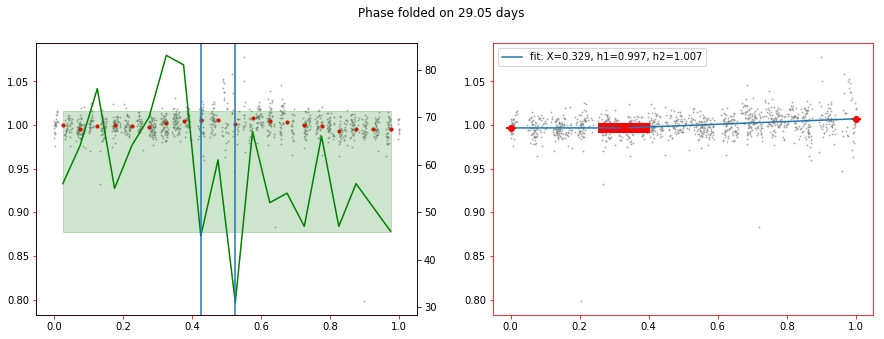

*****
NGTS Object NG2142+0826_11981 (CYCLE1807)
Ratio above RMS: 0.936 ✅
RMS ratio after turning point 1.135 ❌
RMS ratio when folding in half 1.066 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.46 -> 0.57) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.00
------
OBJECT MOON DETERMINATION: True ❌


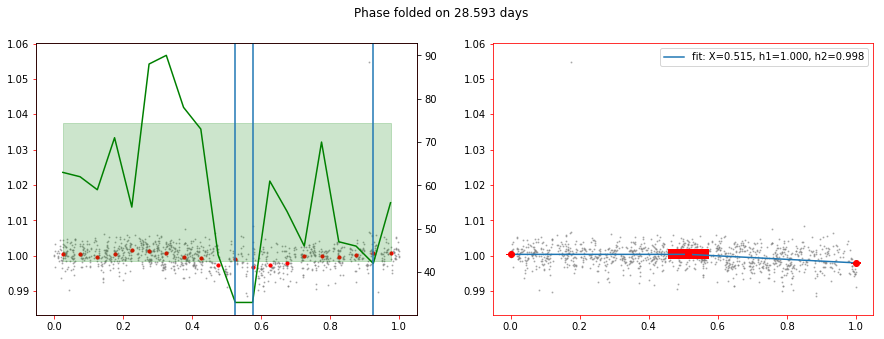

*****
NGTS Object NG2142+0826_11473 (CYCLE1807)
Ratio above RMS: 2.160 ❌
RMS ratio after turning point 1.618 ❌
RMS ratio when folding in half 1.218 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.52 -> 0.58) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.03
------
OBJECT MOON DETERMINATION: True ❌


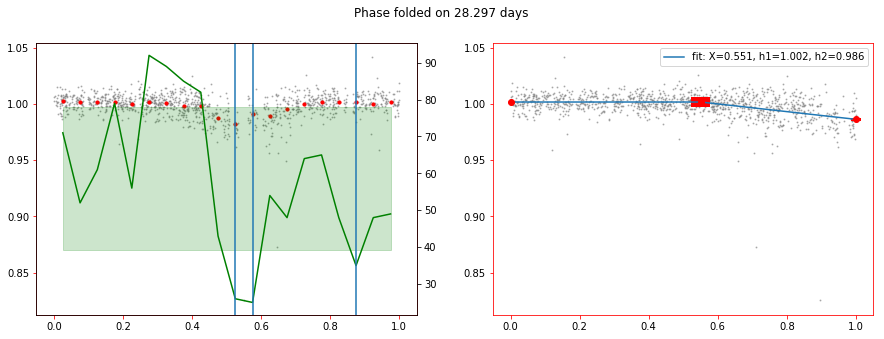

*****
NGTS Object NG2142+0826_211 (CYCLE1807)
Ratio above RMS: 1.553 ❌
RMS ratio after turning point 1.317 ❌
RMS ratio when folding in half 1.043 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.56 -> 0.62) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient 0.03
------
OBJECT MOON DETERMINATION: True ❌


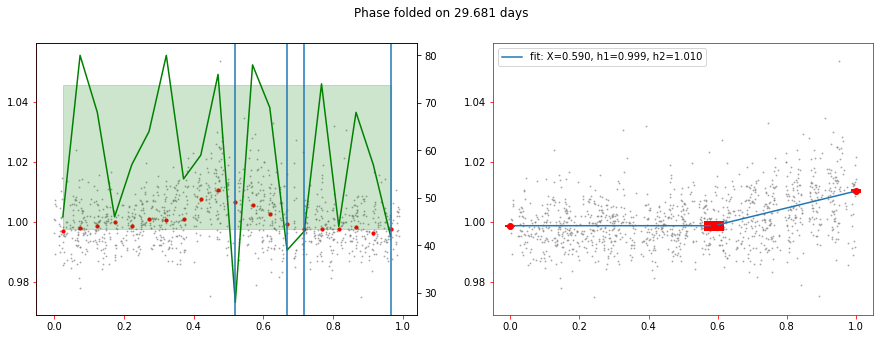

*****
NGTS Object NG2142+0826_30935 (CYCLE1807)
Ratio above RMS: 1.584 ❌
RMS ratio after turning point 0.573 ✅
RMS ratio when folding in half 0.859 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.96 -> 0.99) ✅
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.10
------
OBJECT MOON DETERMINATION: False ✅


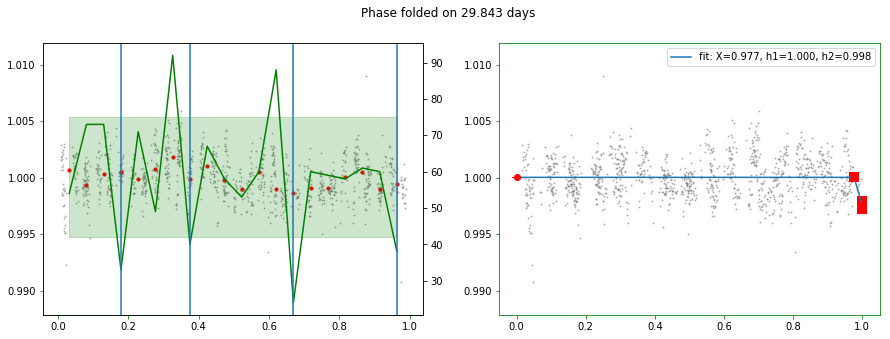

*****
NGTS Object NG2142+0826_2777 (CYCLE1807)
Ratio above RMS: 0.323 ✅
RMS ratio after turning point 1.083 ❌
RMS ratio when folding in half 0.979 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (-0.05 -> 0.47) ✅
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.00
------
OBJECT MOON DETERMINATION: True ❌


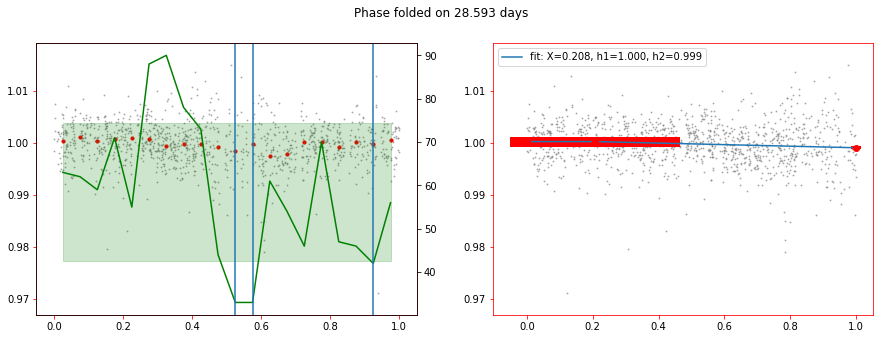

*****
NGTS Object NG2142+0826_2270 (CYCLE1807)
Ratio above RMS: 0.744 ✅
RMS ratio after turning point 1.190 ❌
RMS ratio when folding in half 1.041 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.52 -> 0.65) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.04
------
OBJECT MOON DETERMINATION: True ❌


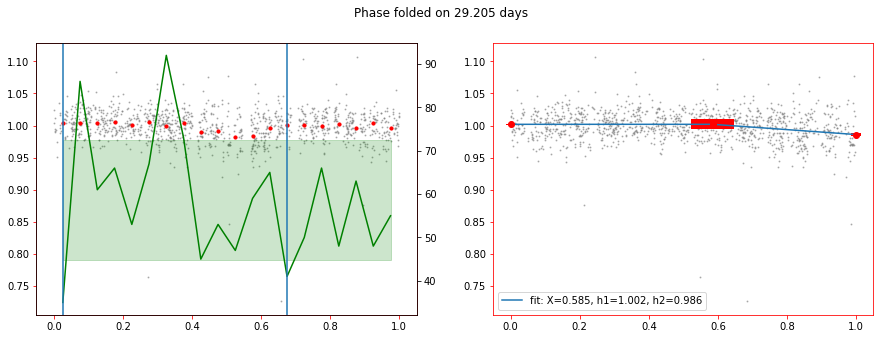

*****
NGTS Object NG2142+0826_20193 (CYCLE1807)
Ratio above RMS: 1.488 ❌
RMS ratio after turning point 1.406 ❌
RMS ratio when folding in half 1.037 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.54 -> 0.59) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.03
------
OBJECT MOON DETERMINATION: True ❌


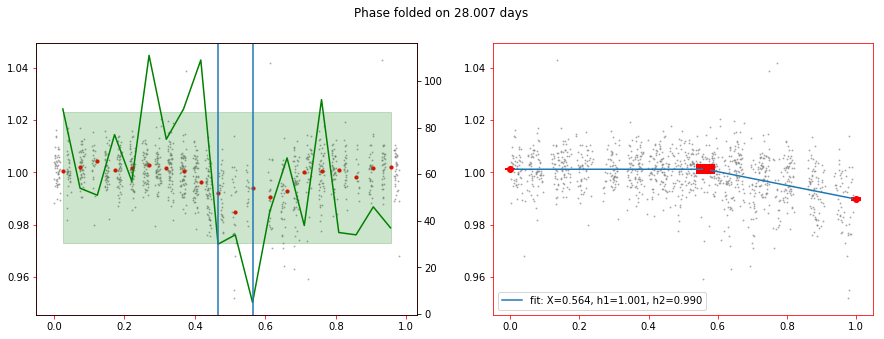

*****
NGTS Object NG2142+0826_30435 (CYCLE1807)
Ratio above RMS: 1.818 ❌
RMS ratio after turning point 1.046 ❌
RMS ratio when folding in half 1.028 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.56 -> 0.61) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient 0.01
------
OBJECT MOON DETERMINATION: True ❌


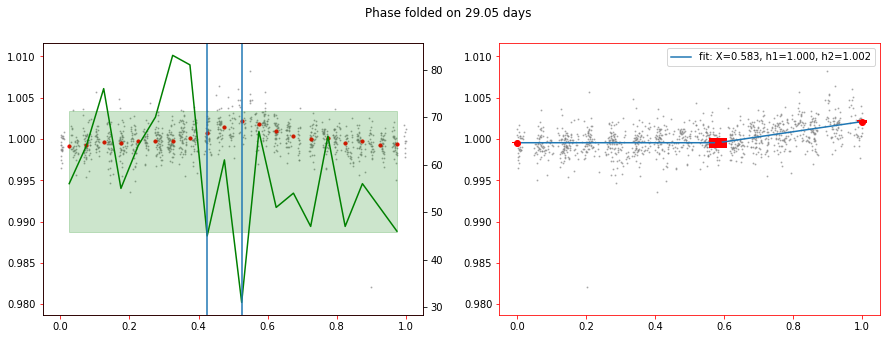

*****
NGTS Object NG2142+0826_15596 (CYCLE1807)
Ratio above RMS: 2.283 ❌
RMS ratio after turning point 1.306 ❌
RMS ratio when folding in half 1.050 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.53 -> 0.58) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.11
------
OBJECT MOON DETERMINATION: True ❌


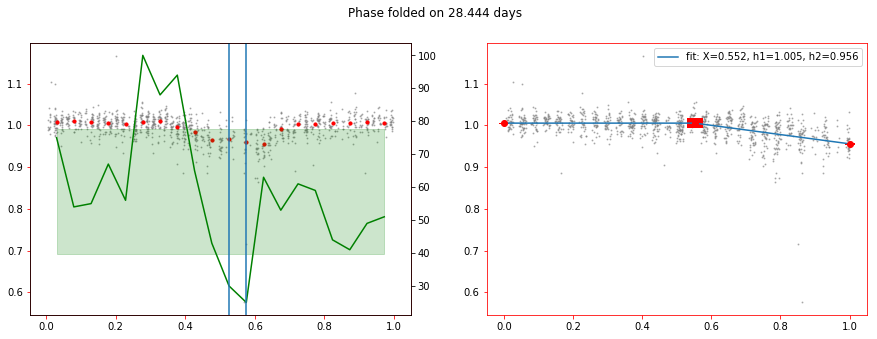

*****
NGTS Object NG2142+0826_13551 (CYCLE1807)
Ratio above RMS: 0.927 ✅
RMS ratio after turning point 1.316 ❌
RMS ratio when folding in half 1.086 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.42 -> 0.54) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.00
------
OBJECT MOON DETERMINATION: True ❌


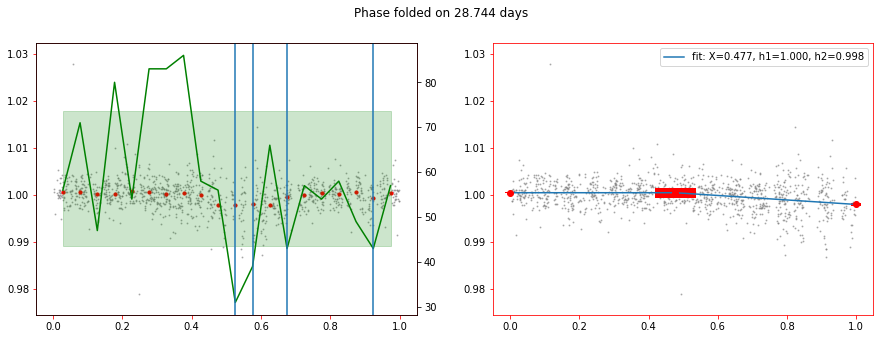

*****
NGTS Object NG2142+0826_24820 (CYCLE1807)
Ratio above RMS: 1.242 ❌
RMS ratio after turning point 1.702 ❌
RMS ratio when folding in half 1.176 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.68 -> 0.74) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.06
------
OBJECT MOON DETERMINATION: True ❌


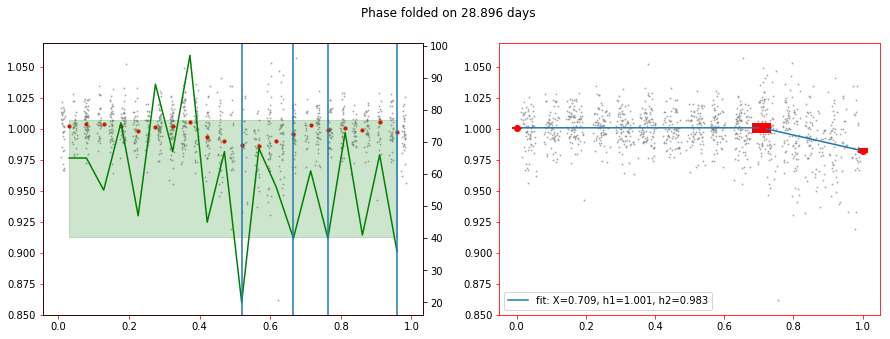

*****
NGTS Object NG2142+0826_27897 (CYCLE1807)
Ratio above RMS: 1.293 ❌
RMS ratio after turning point 1.380 ❌
RMS ratio when folding in half 1.162 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.65 -> 0.71) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.06
------
OBJECT MOON DETERMINATION: True ❌


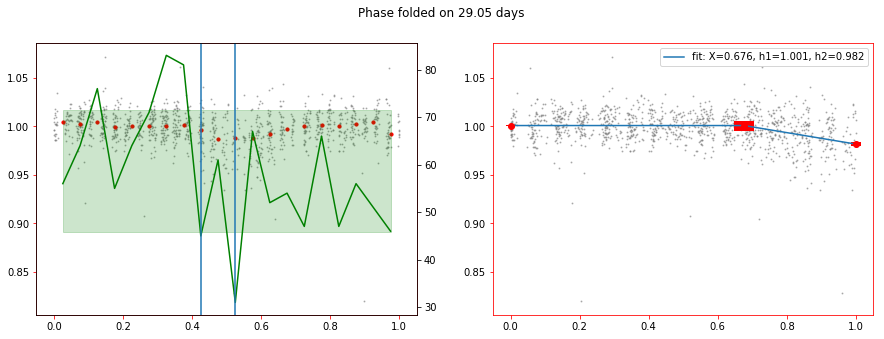

*****
NGTS Object NG2142+0826_4859 (CYCLE1807)
Ratio above RMS: 1.921 ❌
RMS ratio after turning point 1.082 ❌
RMS ratio when folding in half 1.027 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.57 -> 0.62) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.02
------
OBJECT MOON DETERMINATION: True ❌


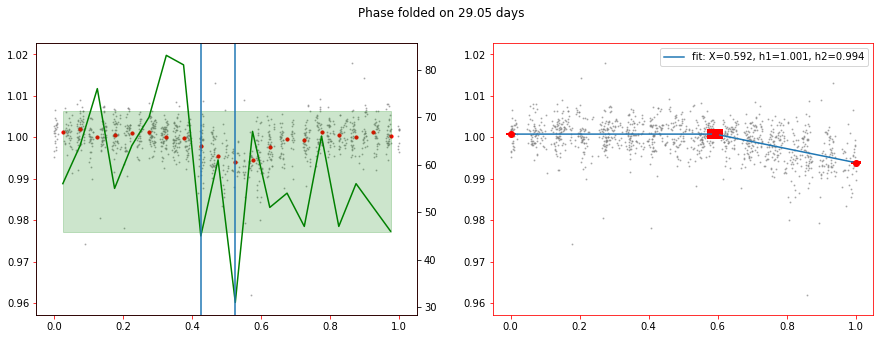

*****
NGTS Object NG2142+0826_16134 (CYCLE1807)
Ratio above RMS: 0.741 ✅
RMS ratio after turning point 4.975 ❌
RMS ratio when folding in half 0.589 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (-0.85 -> 0.86) ✅
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.01
------
OBJECT MOON DETERMINATION: False ✅


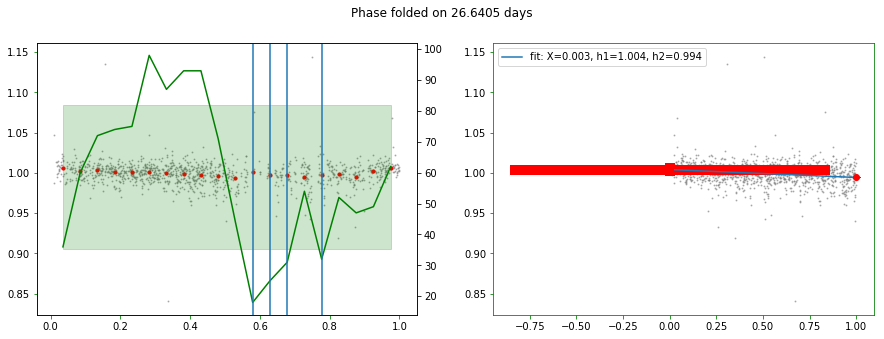

*****
NGTS Object NG2142+0826_20233 (CYCLE1807)
Ratio above RMS: 1.098 ❌
RMS ratio after turning point 1.514 ❌
RMS ratio when folding in half 0.891 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.16 -> 0.31) ✅
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.03
------
OBJECT MOON DETERMINATION: False ✅


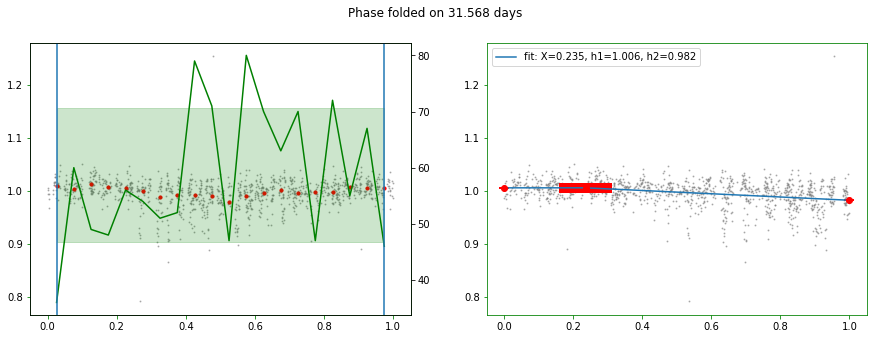

*****
NGTS Object NG2142+0826_26071 (CYCLE1807)
Ratio above RMS: 1.475 ❌
RMS ratio after turning point 1.472 ❌
RMS ratio when folding in half 1.060 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.62 -> 0.67) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.03
------
OBJECT MOON DETERMINATION: True ❌


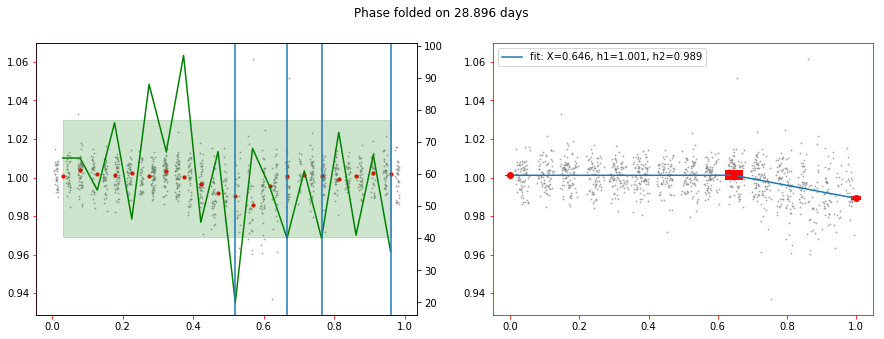

*****
NGTS Object NG2142+0826_26892 (CYCLE1807)
Ratio above RMS: 1.863 ❌
RMS ratio after turning point 1.327 ❌
RMS ratio when folding in half 1.009 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.57 -> 0.62) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.08
------
OBJECT MOON DETERMINATION: True ❌


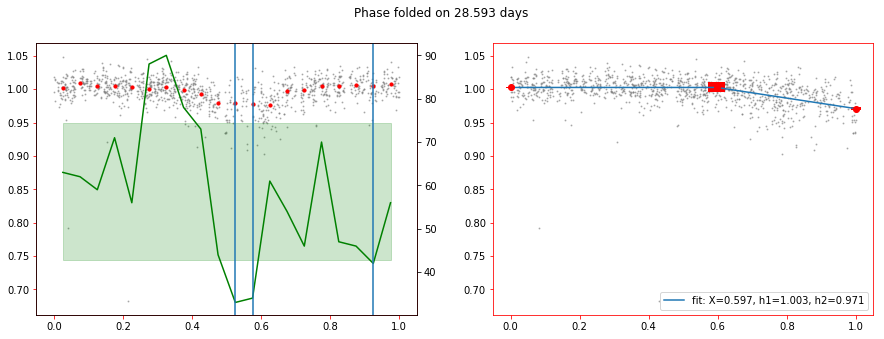

*****
NGTS Object NG2142+0826_17683 (CYCLE1807)
Ratio above RMS: 1.514 ❌
RMS ratio after turning point 1.466 ❌
RMS ratio when folding in half 1.018 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.51 -> 0.58) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.03
------
OBJECT MOON DETERMINATION: True ❌


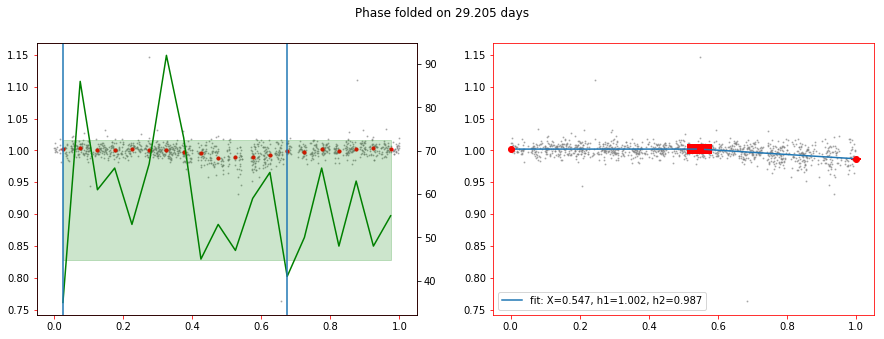

*****
NGTS Object NG2142+0826_31006 (CYCLE1807)
Ratio above RMS: 1.467 ❌
RMS ratio after turning point 1.186 ❌
RMS ratio when folding in half 1.025 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.43 -> 0.51) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.06
------
OBJECT MOON DETERMINATION: True ❌


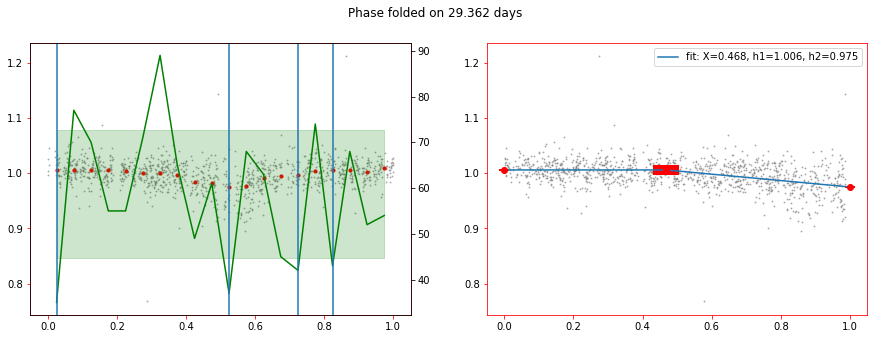

*****
NGTS Object NG2142+0826_20261 (CYCLE1807)
Ratio above RMS: 1.071 ❌
RMS ratio after turning point 1.373 ❌
RMS ratio when folding in half 1.013 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.49 -> 0.58) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.01
------
OBJECT MOON DETERMINATION: True ❌


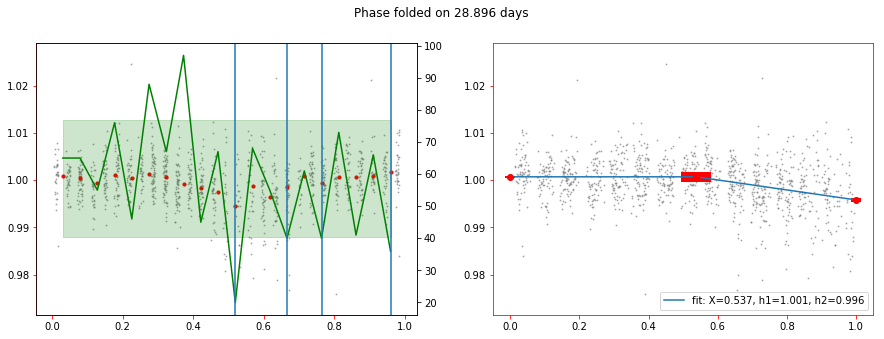

*****
NGTS Object NG2142+0826_6620 (CYCLE1807)
Ratio above RMS: 1.644 ❌
RMS ratio after turning point 1.465 ❌
RMS ratio when folding in half 0.982 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.53 -> 0.59) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.04
------
OBJECT MOON DETERMINATION: True ❌


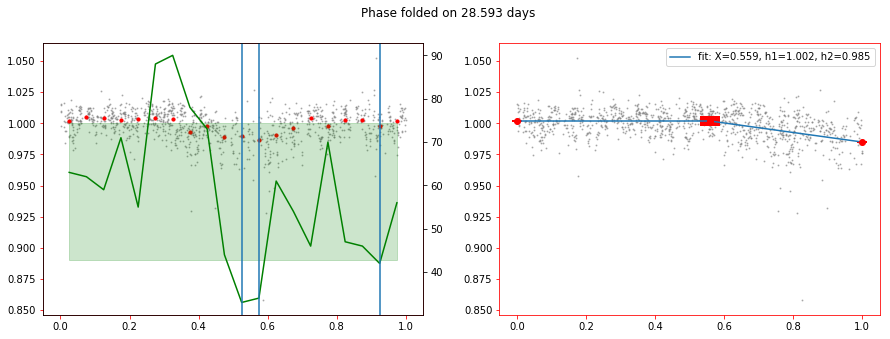

*****
NGTS Object NG2142+0826_2356 (CYCLE1807)
Ratio above RMS: 1.786 ❌
RMS ratio after turning point 1.481 ❌
RMS ratio when folding in half 1.053 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.65 -> 0.70) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.08
------
OBJECT MOON DETERMINATION: True ❌


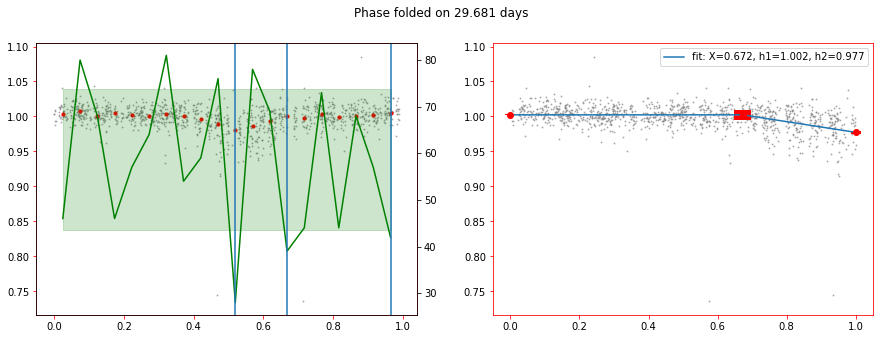

*****
NGTS Object NG2142+0826_23093 (CYCLE1807)
Ratio above RMS: 1.175 ❌
RMS ratio after turning point 1.402 ❌
RMS ratio when folding in half 1.044 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.64 -> 0.71) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.02
------
OBJECT MOON DETERMINATION: True ❌


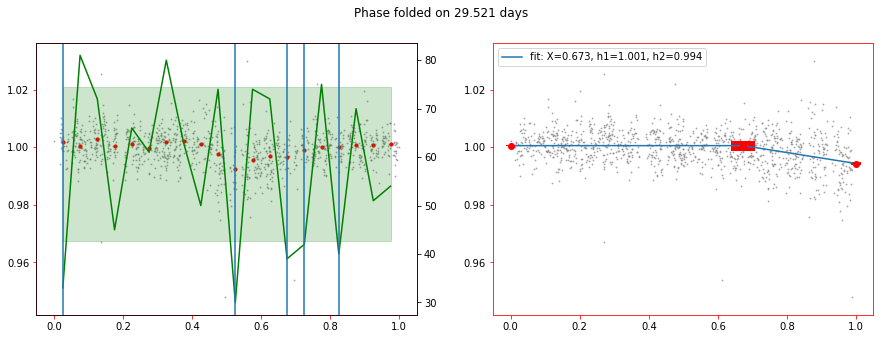

*****
NGTS Object NG2142+0826_9537 (CYCLE1807)
Ratio above RMS: 1.123 ❌
RMS ratio after turning point 1.292 ❌
RMS ratio when folding in half 0.987 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.39 -> 0.48) ✅
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.00
------
OBJECT MOON DETERMINATION: True ❌


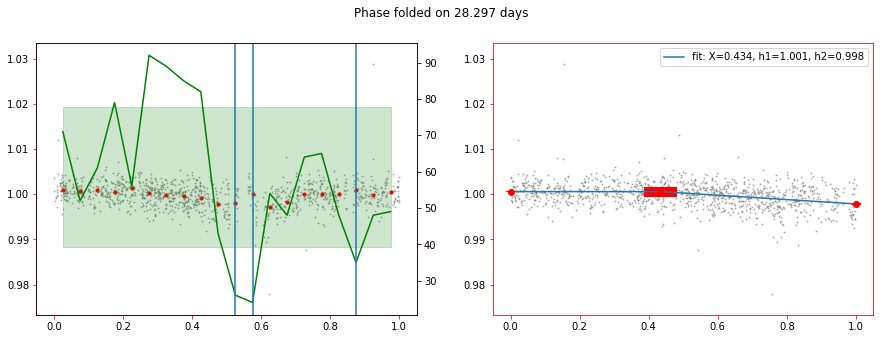

*****
NGTS Object NG2142+0826_6466 (CYCLE1807)
Ratio above RMS: 1.066 ❌
RMS ratio after turning point 1.244 ❌
RMS ratio when folding in half 1.046 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.42 -> 0.52) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.01
------
OBJECT MOON DETERMINATION: True ❌


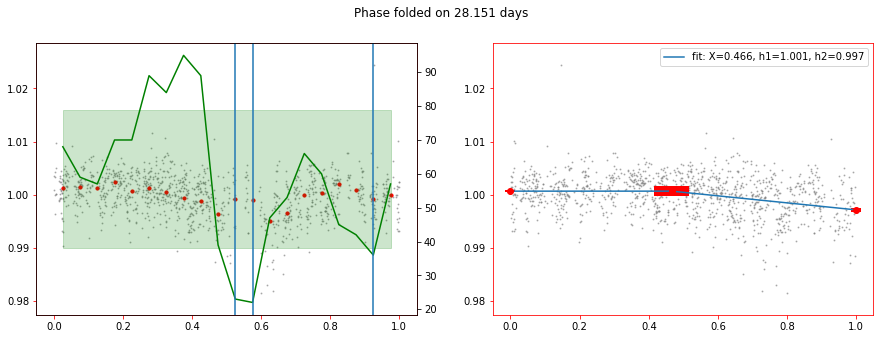

*****
NGTS Object NG2142+0826_32594 (CYCLE1807)
Ratio above RMS: 2.707 ❌
RMS ratio after turning point 1.813 ❌
RMS ratio when folding in half 1.234 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.63 -> 0.66) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.16
------
OBJECT MOON DETERMINATION: True ❌


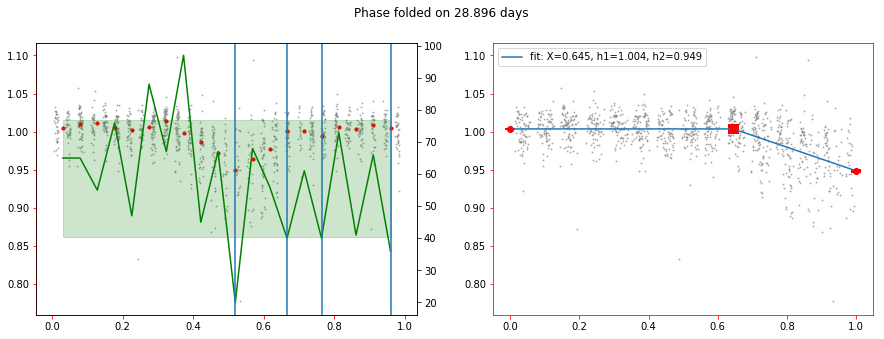

*****
NGTS Object NG2142+0826_12764 (CYCLE1807)
Ratio above RMS: 1.916 ❌
RMS ratio after turning point 1.249 ❌
RMS ratio when folding in half 1.056 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.66 -> 0.70) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.07
------
OBJECT MOON DETERMINATION: True ❌


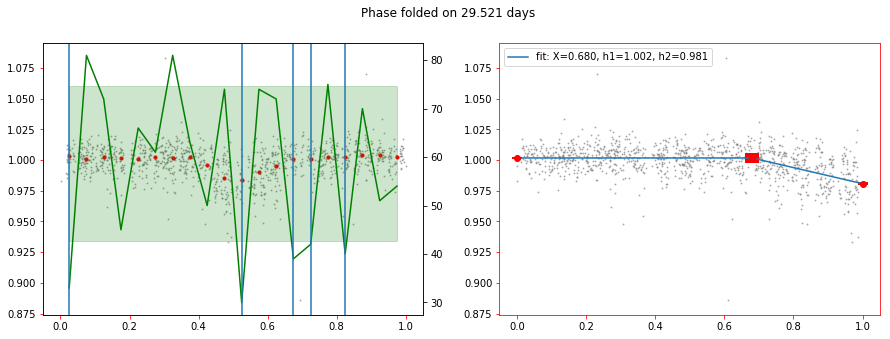

*****
NGTS Object NG2142+0826_25438 (CYCLE1807)
Ratio above RMS: 1.676 ❌
RMS ratio after turning point 1.581 ❌
RMS ratio when folding in half 1.137 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.60 -> 0.65) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.06
------
OBJECT MOON DETERMINATION: True ❌


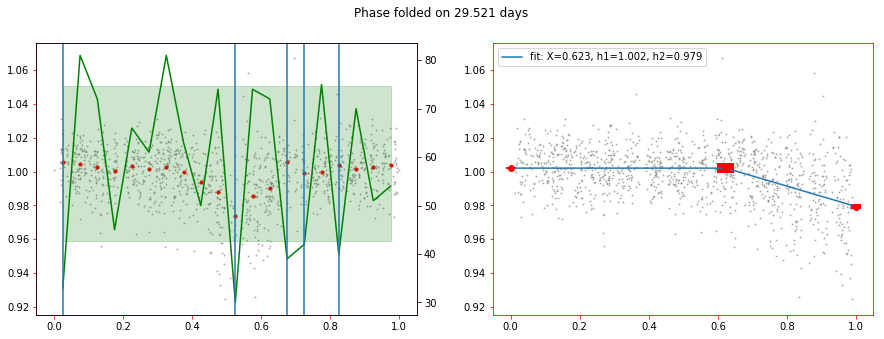

*****
NGTS Object NG2142+0826_5476 (CYCLE1807)
Ratio above RMS: 0.681 ✅
RMS ratio after turning point 0.991 ✅
RMS ratio when folding in half 1.021 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.45 -> 0.59) ❌
Empty bins around full moon: ❌
Data missing around full moon: ❌
Gradient 0.00
------
OBJECT MOON DETERMINATION: True ❌


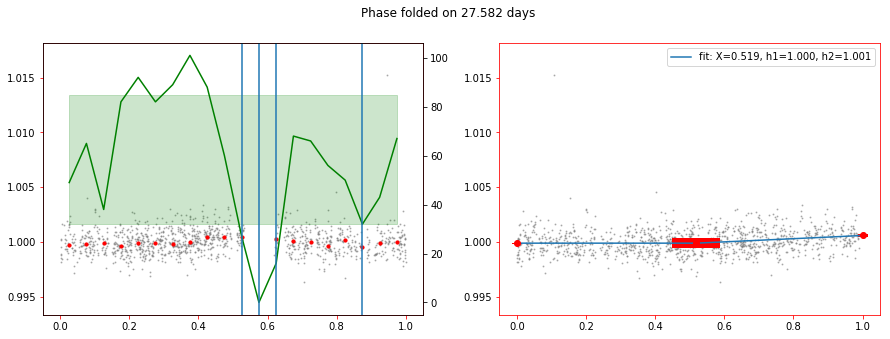

*****
NGTS Object NG2142+0826_12134 (CYCLE1807)
Ratio above RMS: 0.877 ✅
RMS ratio after turning point 1.589 ❌
RMS ratio when folding in half 1.143 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.66 -> 0.74) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.03
------
OBJECT MOON DETERMINATION: True ❌


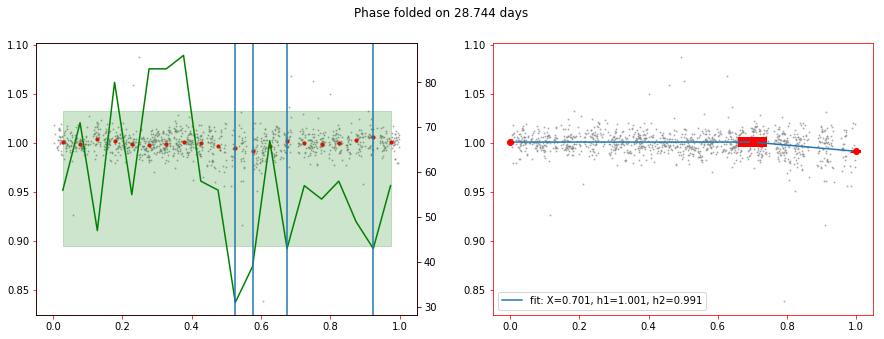

*****
NGTS Object NG2142+0826_32115 (CYCLE1807)
Ratio above RMS: 0.839 ✅
RMS ratio after turning point 1.376 ❌
RMS ratio when folding in half 1.142 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.53 -> 0.64) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.02
------
OBJECT MOON DETERMINATION: True ❌


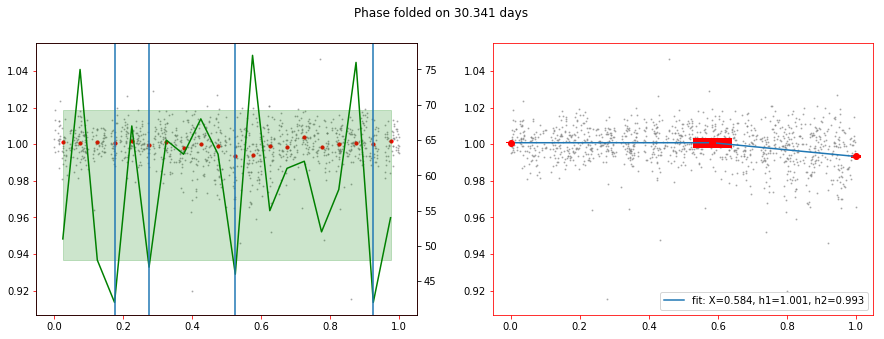

*****
NGTS Object NG2142+0826_16245 (CYCLE1807)
Ratio above RMS: 1.034 ❌
RMS ratio after turning point 1.423 ❌
RMS ratio when folding in half 1.063 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.60 -> 0.68) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.03
------
OBJECT MOON DETERMINATION: True ❌


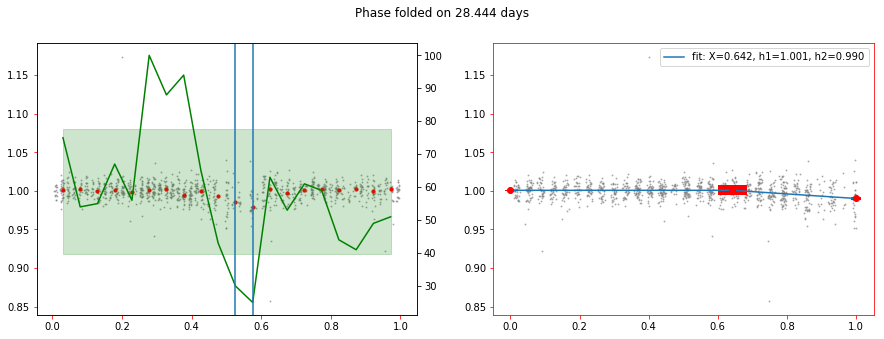

*****
NGTS Object NG2142+0826_15224 (CYCLE1807)
Ratio above RMS: 1.337 ❌
RMS ratio after turning point 1.393 ❌
RMS ratio when folding in half 0.978 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.52 -> 0.59) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.05
------
OBJECT MOON DETERMINATION: True ❌


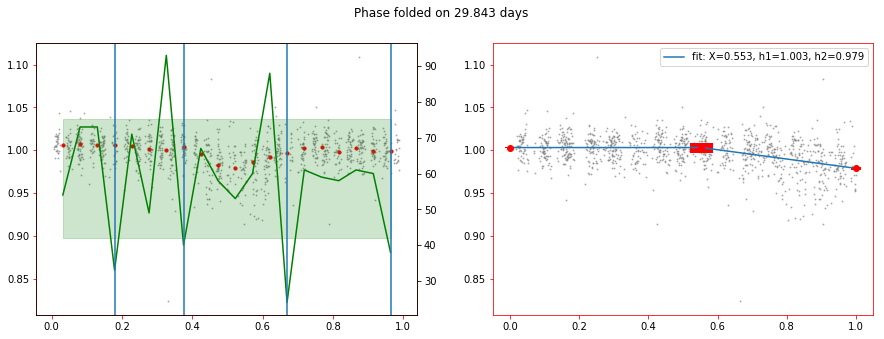

*****
NGTS Object NG2142+0826_27003 (CYCLE1807)
Ratio above RMS: 0.792 ✅
RMS ratio after turning point 1.652 ❌
RMS ratio when folding in half 0.840 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (-0.04 -> 0.25) ✅
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient 0.01
------
OBJECT MOON DETERMINATION: False ✅


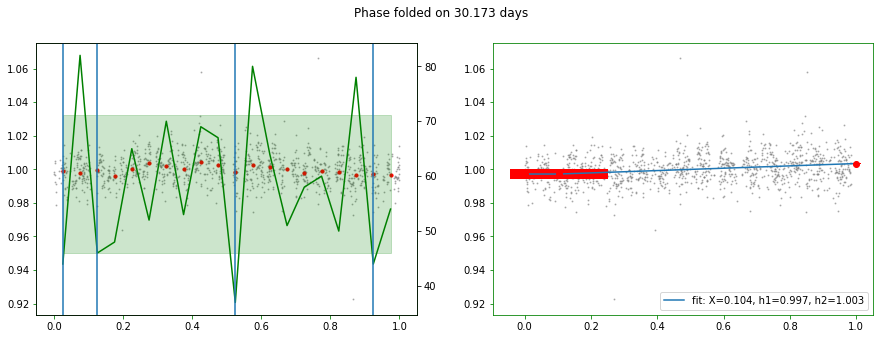

*****
NGTS Object NG2142+0826_32134 (CYCLE1807)
Ratio above RMS: 1.322 ❌
RMS ratio after turning point 1.274 ❌
RMS ratio when folding in half 1.096 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.41 -> 0.50) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.01
------
OBJECT MOON DETERMINATION: True ❌


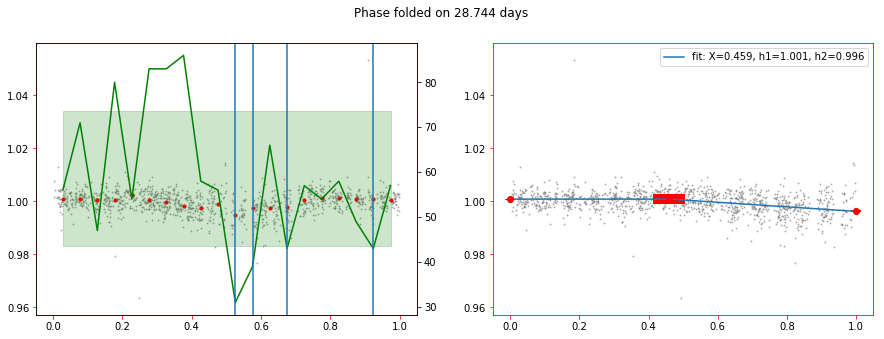

*****
NGTS Object NG2142+0826_12682 (CYCLE1807)
Ratio above RMS: 1.702 ❌
RMS ratio after turning point 1.603 ❌
RMS ratio when folding in half 1.144 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.62 -> 0.66) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.05
------
OBJECT MOON DETERMINATION: True ❌


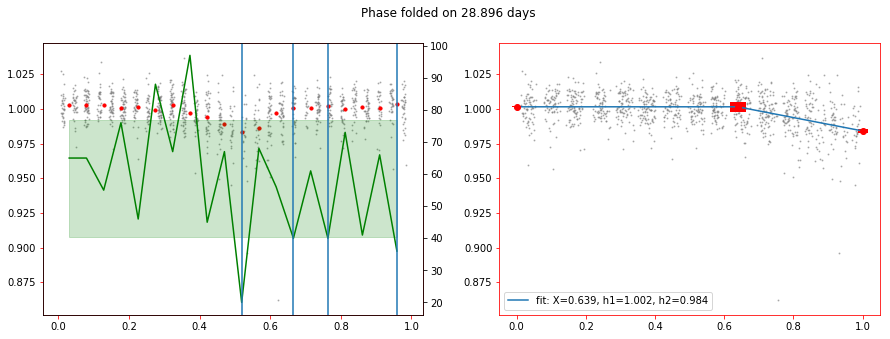

*****
NGTS Object NG2142+0826_21387 (CYCLE1807)
Ratio above RMS: 1.134 ❌
RMS ratio after turning point 1.255 ❌
RMS ratio when folding in half 0.914 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.44 -> 0.52) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.00
------
OBJECT MOON DETERMINATION: True ❌


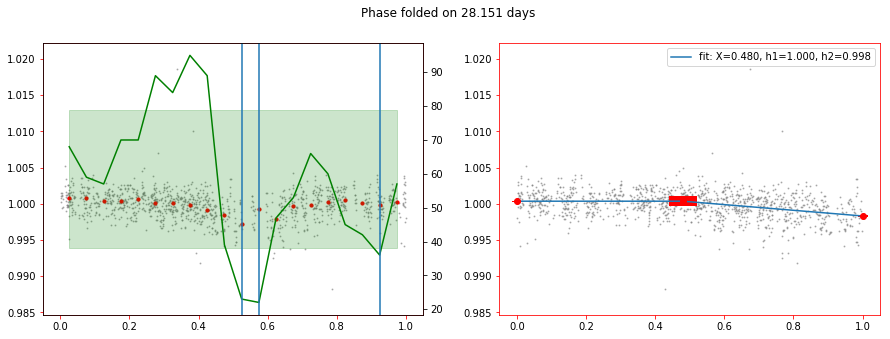

*****
NGTS Object NG2142+0826_4494 (CYCLE1807)
Ratio above RMS: 1.183 ❌
RMS ratio after turning point 1.374 ❌
RMS ratio when folding in half 1.104 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.82 -> 0.87) ✅
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.05
------
OBJECT MOON DETERMINATION: True ❌


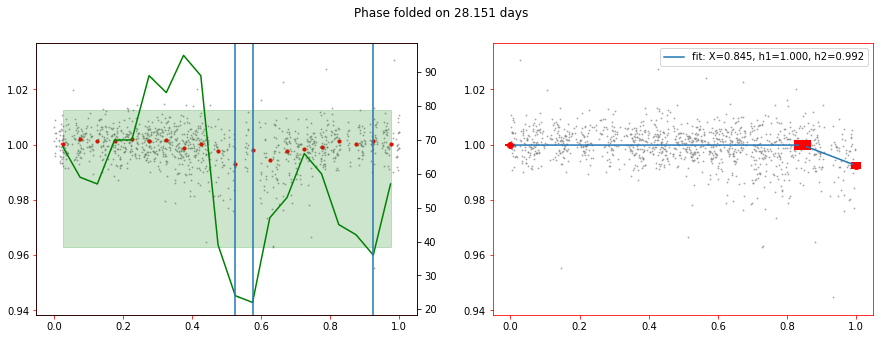

*****
NGTS Object NG2142+0826_12189 (CYCLE1807)
Ratio above RMS: 2.395 ❌
RMS ratio after turning point 1.548 ❌
RMS ratio when folding in half 1.108 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.65 -> 0.68) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.14
------
OBJECT MOON DETERMINATION: True ❌


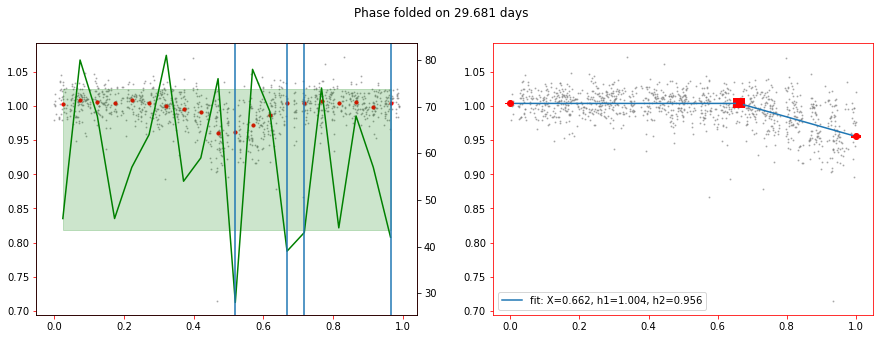

*****
NGTS Object NG2142+0826_10158 (CYCLE1807)
Ratio above RMS: 1.641 ❌
RMS ratio after turning point 1.462 ❌
RMS ratio when folding in half 1.161 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.79 -> 0.83) ✅
Empty bins around full moon: ❌
Data missing around full moon: ✅
Gradient -0.11
------
OBJECT MOON DETERMINATION: True ❌


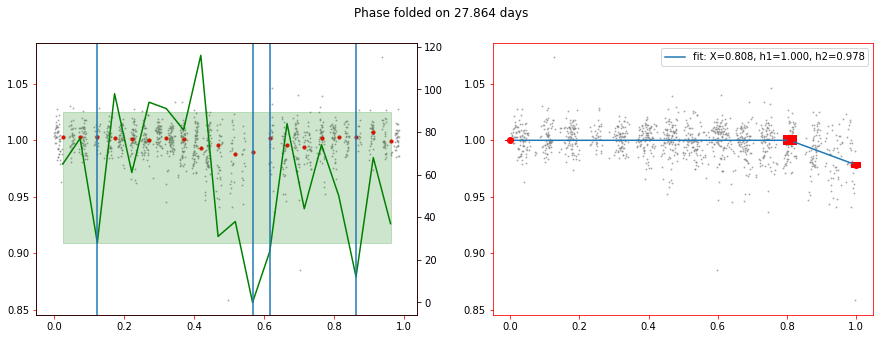

*****
NGTS Object NG2142+0826_19379 (CYCLE1807)
Ratio above RMS: 2.101 ❌
RMS ratio after turning point 1.672 ❌
RMS ratio when folding in half 1.016 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.54 -> 0.58) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.07
------
OBJECT MOON DETERMINATION: True ❌


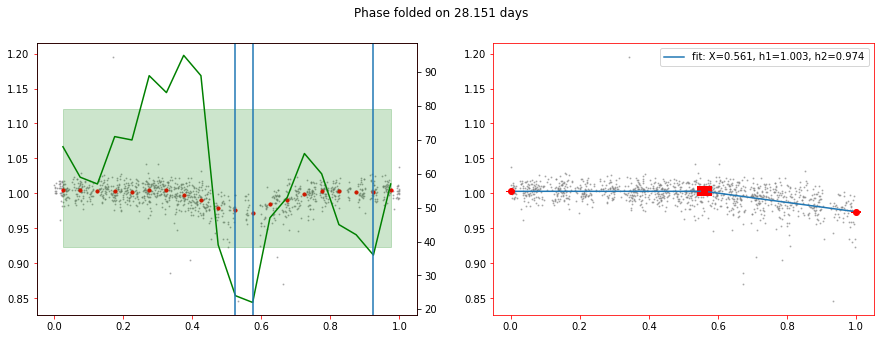

*****
NGTS Object NG2142+0826_17055 (CYCLE1807)
Ratio above RMS: 1.015 ❌
RMS ratio after turning point 1.409 ❌
RMS ratio when folding in half 1.073 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.60 -> 0.69) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.03
------
OBJECT MOON DETERMINATION: True ❌


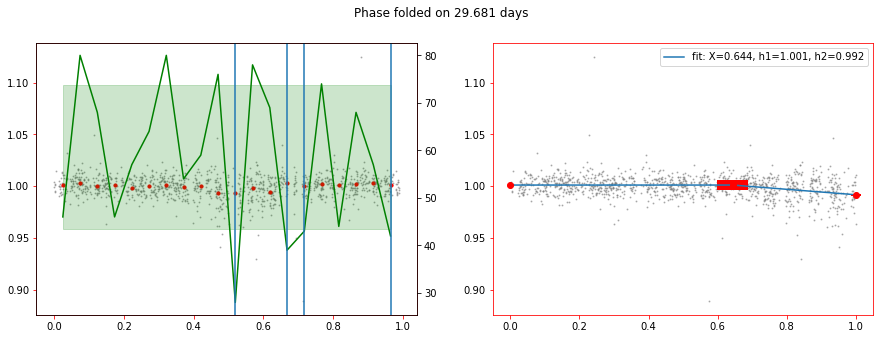

*****
NGTS Object NG2142+0826_8640 (CYCLE1807)
Ratio above RMS: 1.096 ❌
RMS ratio after turning point 1.134 ❌
RMS ratio when folding in half 1.017 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.07 -> 0.26) ✅
Empty bins around full moon: ❌
Data missing around full moon: ❌
Gradient -0.00
------
OBJECT MOON DETERMINATION: True ❌


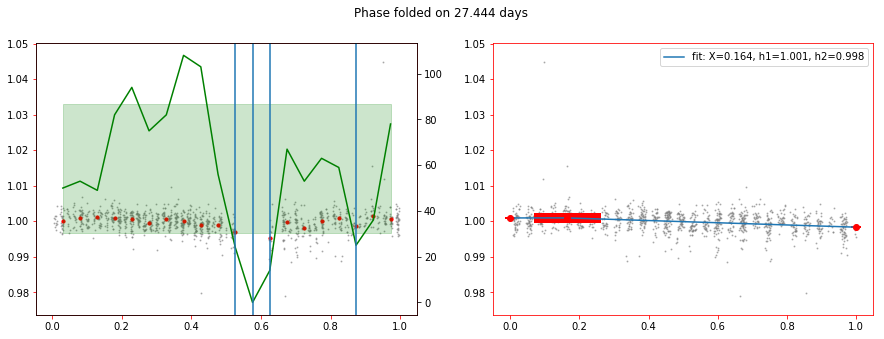

*****
NGTS Object NG2142+0826_5057 (CYCLE1807)
Ratio above RMS: 1.361 ❌
RMS ratio after turning point 1.373 ❌
RMS ratio when folding in half 1.157 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.80 -> 0.85) ✅
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.06
------
OBJECT MOON DETERMINATION: True ❌


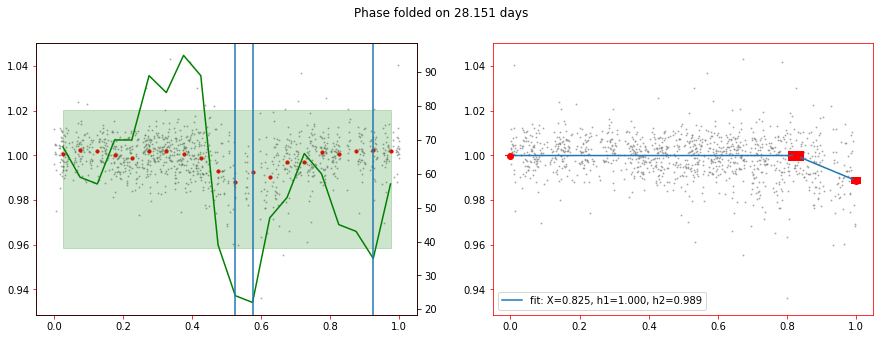

*****
NGTS Object NG2142+0826_5572 (CYCLE1807)
Ratio above RMS: 1.486 ❌
RMS ratio after turning point 1.531 ❌
RMS ratio when folding in half 1.117 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.59 -> 0.65) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.04
------
OBJECT MOON DETERMINATION: True ❌


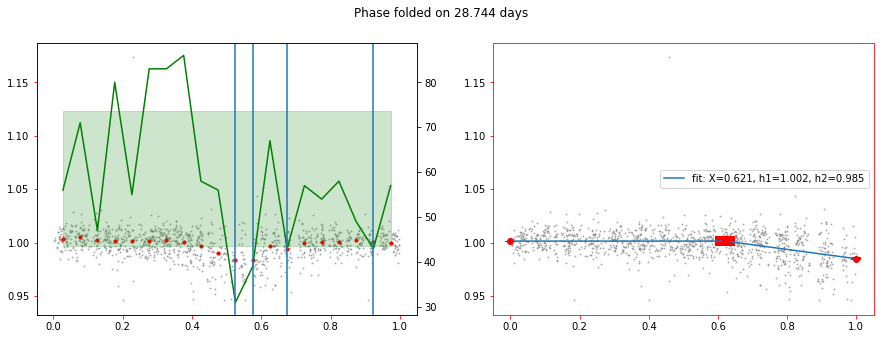

*****
NGTS Object NG2142+0826_7110 (CYCLE1807)
Ratio above RMS: 1.859 ❌
RMS ratio after turning point 1.370 ❌
RMS ratio when folding in half 1.086 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.59 -> 0.64) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.06
------
OBJECT MOON DETERMINATION: True ❌


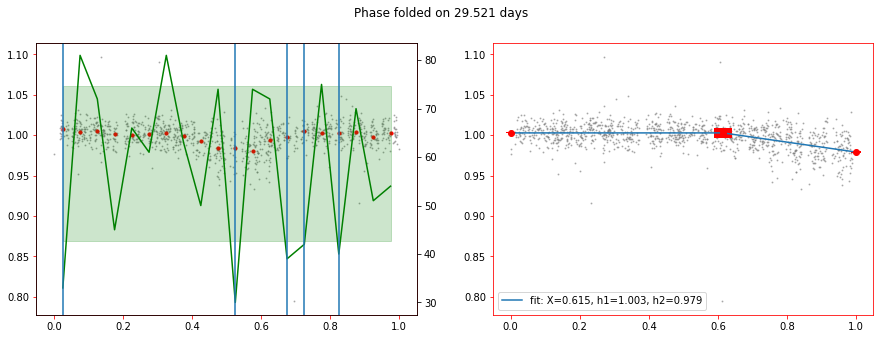

*****
NGTS Object NG2142+0826_17871 (CYCLE1807)
Ratio above RMS: 1.576 ❌
RMS ratio after turning point 1.362 ❌
RMS ratio when folding in half 0.980 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.41 -> 0.50) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.03
------
OBJECT MOON DETERMINATION: True ❌


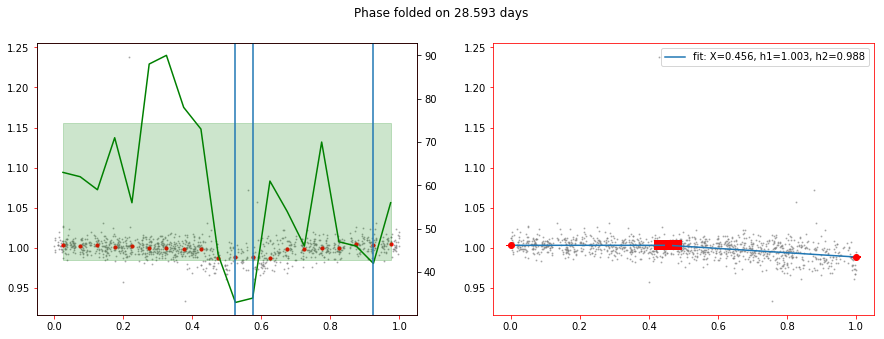

*****
NGTS Object NG2142+0826_22487 (CYCLE1807)
Ratio above RMS: 1.989 ❌
RMS ratio after turning point 1.345 ❌
RMS ratio when folding in half 0.988 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.42 -> 0.47) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.05
------
OBJECT MOON DETERMINATION: True ❌


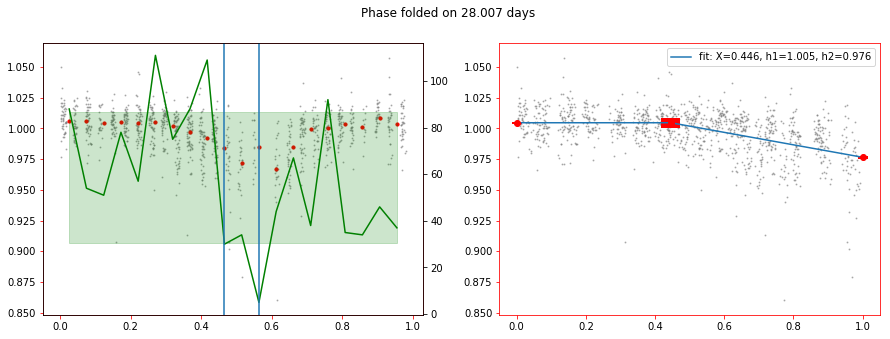

*****
NGTS Object NG2142+0826_15836 (CYCLE1807)
Ratio above RMS: 1.503 ❌
RMS ratio after turning point 1.223 ❌
RMS ratio when folding in half 1.059 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.81 -> 0.85) ✅
Empty bins around full moon: ❌
Data missing around full moon: ❌
Gradient -0.14
------
OBJECT MOON DETERMINATION: True ❌


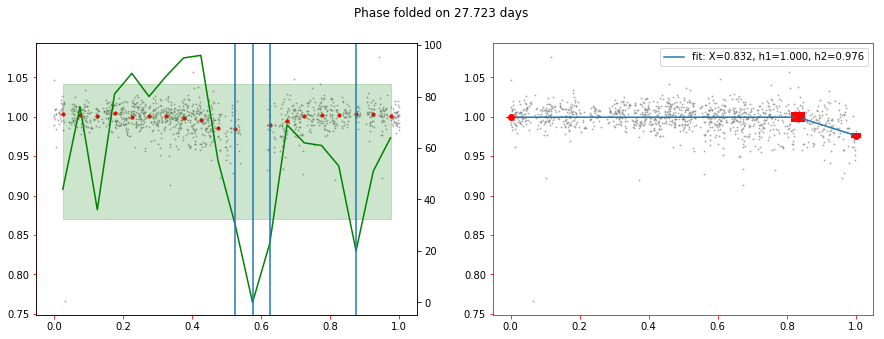

*****
NGTS Object NG2142+0826_7649 (CYCLE1807)
Ratio above RMS: 1.665 ❌
RMS ratio after turning point 1.833 ❌
RMS ratio when folding in half 1.274 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.62 -> 0.68) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.04
------
OBJECT MOON DETERMINATION: True ❌


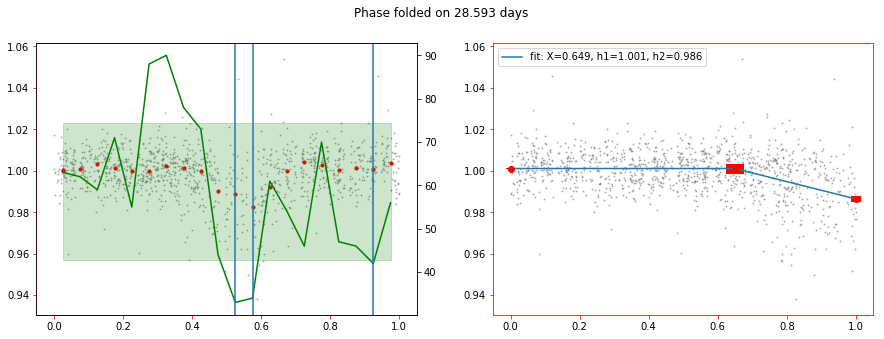

*****
NGTS Object NG2142+0826_30696 (CYCLE1807)
Ratio above RMS: 2.156 ❌
RMS ratio after turning point 1.193 ❌
RMS ratio when folding in half 1.109 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.64 -> 0.68) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.10
------
OBJECT MOON DETERMINATION: True ❌


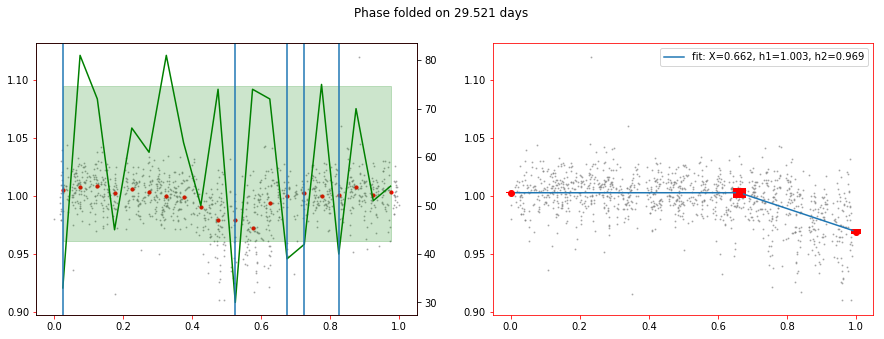

*****
NGTS Object NG2142+0826_14316 (CYCLE1807)
Ratio above RMS: 2.901 ❌
RMS ratio after turning point 1.747 ❌
RMS ratio when folding in half 1.059 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.50 -> 0.53) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.12
------
OBJECT MOON DETERMINATION: True ❌


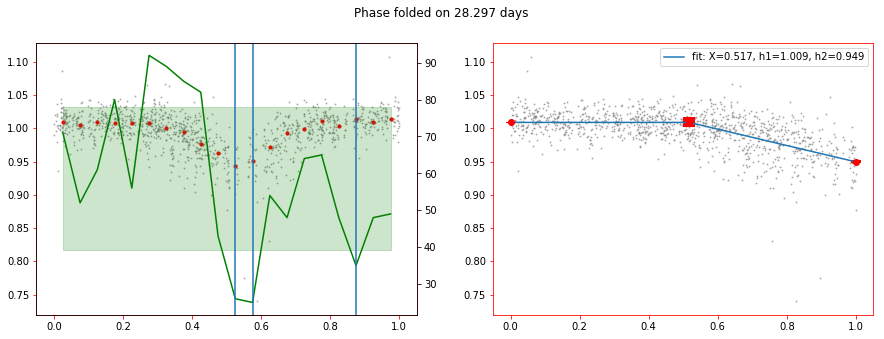

*****
NGTS Object NG2142+0826_7152 (CYCLE1807)
Ratio above RMS: 1.086 ❌
RMS ratio after turning point 1.366 ❌
RMS ratio when folding in half 1.189 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.57 -> 0.66) ❌
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.02
------
OBJECT MOON DETERMINATION: True ❌


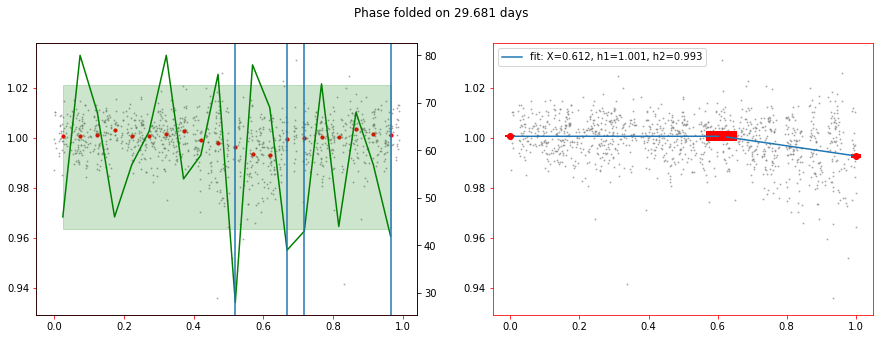

*****
NGTS Object NG2142+0826_8186 (CYCLE1807)
Ratio above RMS: 1.360 ❌
RMS ratio after turning point 1.390 ❌
RMS ratio when folding in half 0.962 ❌
Model significant (ends don't overlap): ❌
Turnover point in range (0.49 -> 0.56) ❌
Empty bins around full moon: ✅
Data missing around full moon: ❌
Gradient -0.07
------
OBJECT MOON DETERMINATION: True ❌


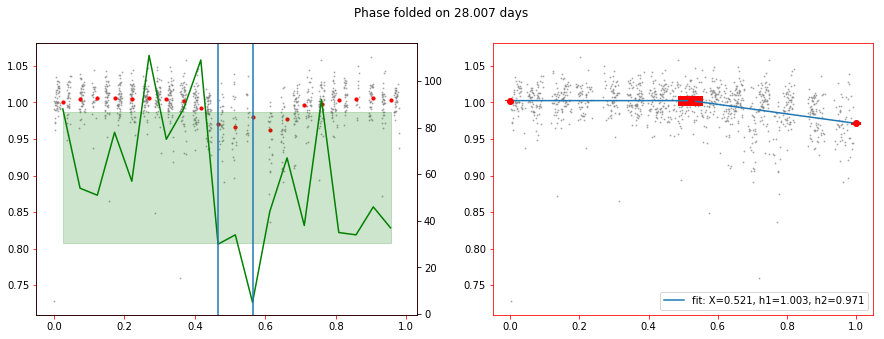

*****
NGTS Object NG2142+0826_16891 (CYCLE1807)
Ratio above RMS: 0.825 ✅
RMS ratio after turning point 1.293 ❌
RMS ratio when folding in half 1.032 ❌
Model significant (ends don't overlap): ❌
Turnover point not in range (0.34 -> 0.47) ✅
Empty bins around full moon: ✅
Data missing around full moon: ✅
Gradient -0.03
------
OBJECT MOON DETERMINATION: False ✅


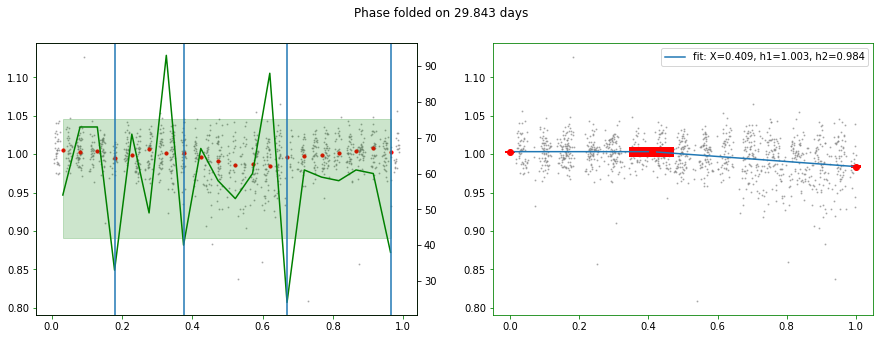

In [57]:
turnover_bottom_limit = 0.4 # in half phase (so 0.4 = 0.2 in phase)
turnover_top_limit = 0.8 # in half phase (so 0.8 = 0.4 in phase)
new_moon_epoch = 944.9544201602376
xs, h1s, h2s, rmss = [],[],[],[]
pre_rms, post_rms = [], []
gradients = []
diff_vs_rms = []
i = 0
steal = 0
for obj in field:
    try:
        t = obj.timeseries_binned
        f = obj.flux_binned
        p = obj_periods[i]
        if steal == 0:
            t = np.linspace(min(t), max(t), len(t))
            f = np.sin(((t+50) * (2 * np.pi)) / p) * 0.1 + (np.random.rand(len(t)) * 0.05) + 1
        if steal == 1:
            t = np.linspace(min(t), max(t), len(t))
            f = np.ones(len(t)) + (np.random.rand(len(t)) * 0.05)
        steal += 1
        phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
        binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
        
        hist, edges = np.histogram(phase_app, bins=np.linspace(0,1,len(binned_phase_app) + 1))
        mean_pts = np.mean(hist)
        stdev_pts = np.std(hist)
        
        empty_moon_bins = False
        min_bin = np.inf
        min_bin_in = False
        nmissing_in = nmissing_out = 0
        bins_with_low_points = []
        for pv, hv in zip(binned_phase_app, hist):
            lim_check = (0.4 < pv < 0.6)
            if hv < min_bin:
                min_bin = hv
                if lim_check:
                    min_bin_in = True
                else:
                    min_bin_in = False
            if lim_check and hv == 0:
                empty_moon_bins = True
            if hv < (mean_pts - stdev_pts):
                bins_with_low_points.append(pv)
                if lim_check:
                    nmissing_in += 1
                else:
                    nmissing_out += 1
                    
        missing_moon_data = min_bin_in and (nmissing_in >= nmissing_out)
        
        
        half_phase_app = np.array(fold_phase_in_half(phase_app))
        popt, pcov = curve_fit(define_fit_function, half_phase_app, data_app, [0.8, 1.0, 1.0], 
                               bounds=(0, [1, max(data_app), max(data_app)]))
        perr = np.sqrt(np.diag(pcov))
        xs.append(popt[0])
        h1s.append(popt[1])
        h2s.append(popt[2])
        rmss.append(split_and_compute_rms(phase_app, data_app, 0, 0.05))
        
        pre_rms.append(split_and_compute_rms(half_phase_app[half_phase_app < xs[i]], 
                                             data_app[half_phase_app < xs[i]], 0, 0.05))
        post_rms.append(split_and_compute_rms(half_phase_app[half_phase_app >= xs[i]], 
                                             data_app[half_phase_app >= xs[i]], 0, 0.05))
        
        diff_vs_rms.append(abs(h1s[i] - h2s[i]) / rmss[i])
        s2n = diff_vs_rms[i]
        RMS_change = post_rms[i] / pre_rms[i]
        RMS_fold = np.mean([pre_rms[i], post_rms[i]]) / rmss[i]
        bottom_tp = xs[i] - perr[0]
        top_tp = xs[i] + perr[0]
        
        in_range = ((turnover_bottom_limit < bottom_tp < turnover_top_limit) and
                    (turnover_bottom_limit < top_tp    < turnover_top_limit))
        
        gradients.append( (h2s[i]-h1s[i]) / (1 - xs[i]) )
        
        max_height = max(h2s[i], h1s[i])
        if max_height == h2s[i]:
            max_second = True
        else:
            max_second = False
        # if either point in this region => points overlap, not significant
        lower_overlap = h2s[i] - perr[2] if max_second else h1s[i] - perr[1]
        upper_overlap = h1s[i] + perr[1] if max_second else h2s[i] + perr[2]
        
        ends_overlap = False
        for h in [h1s[i], h2s[i]]:
            if lower_overlap < h < upper_overlap:
                ends_overlap = True
        
        print '*****'
        print obj
        print 'Ratio above RMS: {:.3f} {}'.format(s2n, '❌' if s2n > 1 else '✅')
        print 'RMS ratio after turning point {:.3f} {}'.format(RMS_change, '❌' if RMS_change > 1 else '✅')
        print 'RMS ratio when folding in half {:.3f} {}'.format(RMS_fold, '❌' if RMS_fold < 1.5 else '✅')
        print 'Model significant (ends don\'t overlap): {}'.format('❌' if not ends_overlap else '✅')
        print 'Turnover point {} range ({:.2f} -> {:.2f}) {}'.format('in' if in_range else 'not in',
                                                             bottom_tp, top_tp,
                                                             '❌' if in_range else '✅')
        print 'Empty bins around full moon: {}'.format('❌' if empty_moon_bins else '✅')
        print 'Data missing around full moon: {}'.format('❌' if missing_moon_data else '✅')
        print 'Gradient {:.2f}'.format(gradients[i])
        
        is_moon = (in_range and RMS_change > 1 and RMS_fold < 1.5) or empty_moon_bins or missing_moon_data
        
        print '------'
        
        print 'OBJECT MOON DETERMINATION:', is_moon, '❌' if is_moon else '✅'
        
        fig, (ax1, ax) = plt.subplots(1, 2, figsize=(15,5))
        ax1.scatter(phase_app, data_app, s=1, c='gray', alpha=0.5)
        ax1.scatter(binned_phase_app, binned_data_app, s=10, c='r')
        
        ax1h = ax1.twinx()
        ax1h.plot(binned_phase_app, hist, c='g')
        pts_ys = np.zeros(len(binned_phase_app)) + mean_pts
        ax1h.fill_between(binned_phase_app, pts_ys-stdev_pts, pts_ys+stdev_pts, color='g', alpha=0.2)
        for pp in bins_with_low_points:
            ax1h.axvline(x=pp)
        
        
        fig.suptitle('Phase folded on {} days'.format(p))
        ax.scatter(half_phase_app, data_app, s=1, c='gray', alpha=0.5)
        ts = np.linspace(0, 1, 100)
        ax.plot(ts, define_fit_function(ts, *popt), label='fit: X=%5.3f, h1=%5.3f, h2=%5.3f' % tuple(popt))
        
        ax.errorbar(0, popt[1], yerr=perr[1], c='r', fmt='o', capthick=2, elinewidth=10)
        ax.errorbar(1, popt[2], yerr=perr[2], c='r', fmt='o', capthick=2, elinewidth=10)
        ax.errorbar(popt[0], popt[1], xerr=perr[0], c='r', fmt='o', capthick=2, elinewidth=10)
        
        limits=popt[1:]
        ax.legend()
        
        color = 'red' if is_moon else 'green'
        
        for a in [ax, ax1]:
            plt.setp(a.spines.values(), color=color)
            plt.setp([a.get_xticklines(), a.get_yticklines()], color=color)
        
        plt.show()
        
        
    except TypeError as e:
        raise e
    i += 1

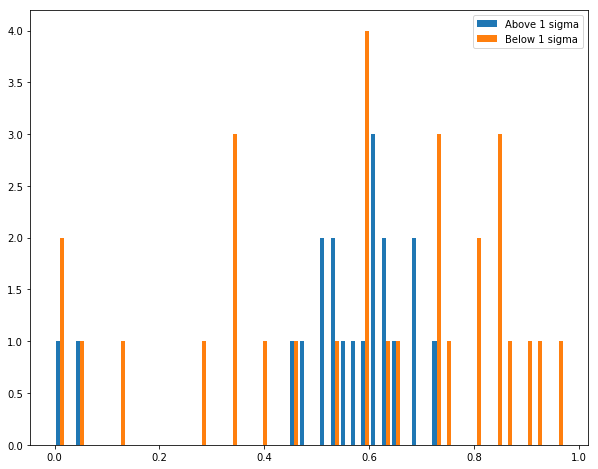

In [52]:
idx_above, idx_below = [], []
for i, rms in enumerate(diff_vs_rms):
    if rms > 1.0:
        idx_above.append(i)
    else:
        idx_below.append(i)
        
turnover_above = np.array(xs)[idx_above]
turnover_below = np.array(xs)[idx_below]
plt.figure(figsize=(10,8))
plt.hist([turnover_above, turnover_below], bins=50, label=['Above 1 sigma', 'Below 1 sigma'])
plt.legend()
plt.show()

# calculate slope: (h1-h2) / turnover - 1
# work in 2d space of turnover and slope from model.
# try rebinning data to remove weights / lack of points. Same weights in all points. May need more than 20 bins.
# are the flags all at 0.5 phase?




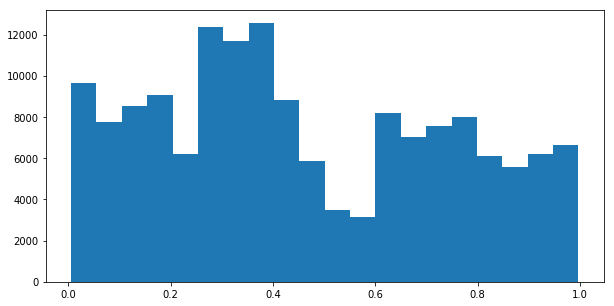

In [23]:
# flags test - doesn't really work due to removal of bad data.
# try plotting points density in each bin instead?
i = 0
for obj in field:
    t = obj.timeseries
#     f = [(1 if f != 0 else 0) for f in obj.flags]
    f = obj.flags
    p = obj_periods[i]
    phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
    fig, ax = plt.subplots(figsize=(10,5))
#     ax.scatter(phase_app, data_app)
    hist = plt.hist(phase_app, bins=20)
    plt.show()
    break
    i += 1

In [26]:
len(hist[0])

20

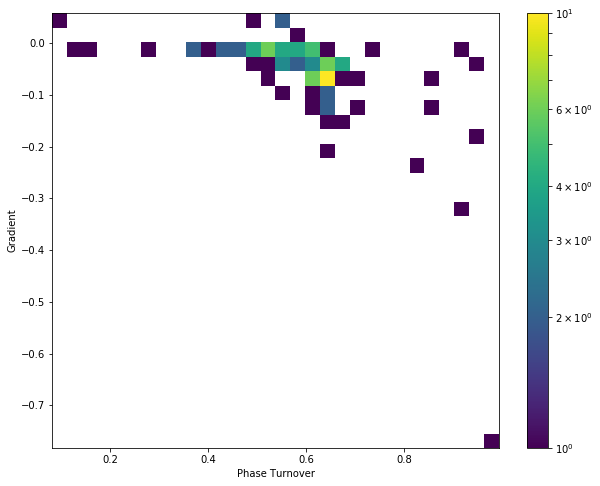

In [31]:
plt.figure(figsize=(10,8))
# plt.hist(xs, bins=20)
# plt.title('Distribution of turnover point in Phase')
# plt.show()
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
# ax1.hist(h1s, bins=20)
# ax1.set_title('Distribution of low phase median')
# ax2.hist(h2s, bins=20)
# ax2.set_title('Distribution of high phase median')
# plt.show()
hist = plt.hist2d(xs, gradients, bins=(30, 30), cmap=plt.cm.viridis, norm=mpl.colors.LogNorm())
plt.xlabel('Phase Turnover')
plt.ylabel('Gradient')
cb = plt.colorbar()
plt.show()


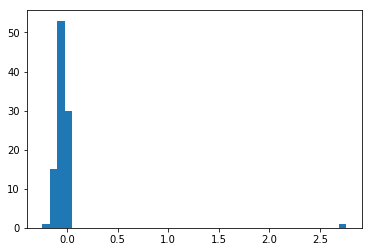

In [52]:
plt.hist(gradients, bins=40)
plt.show()

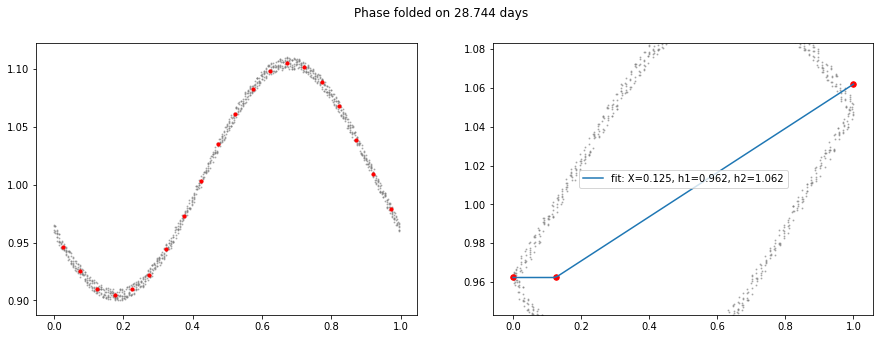

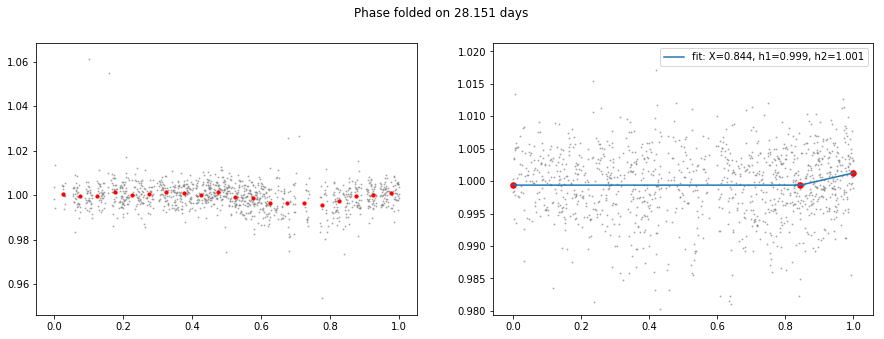

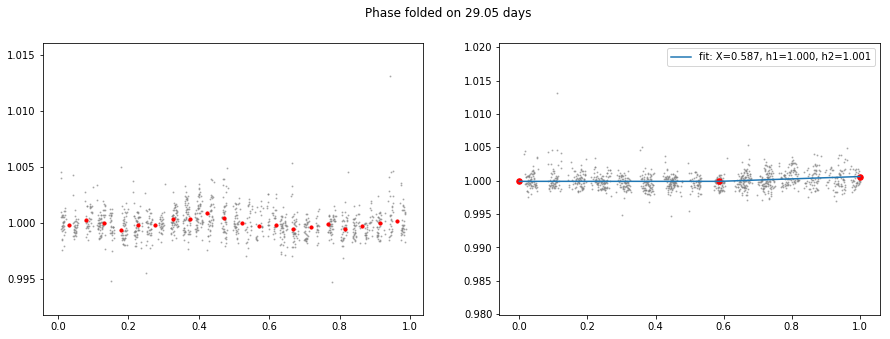

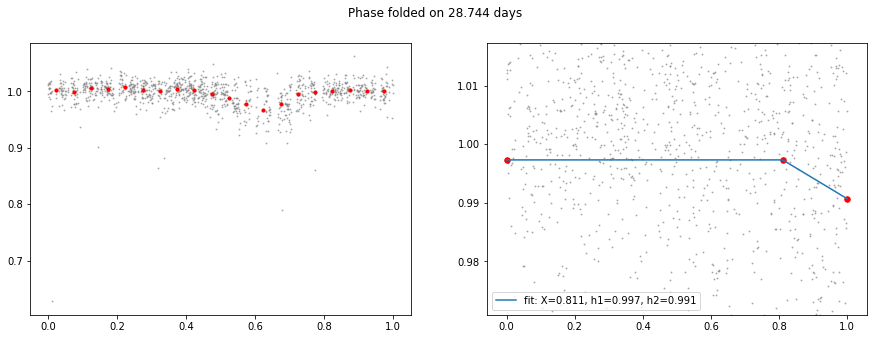

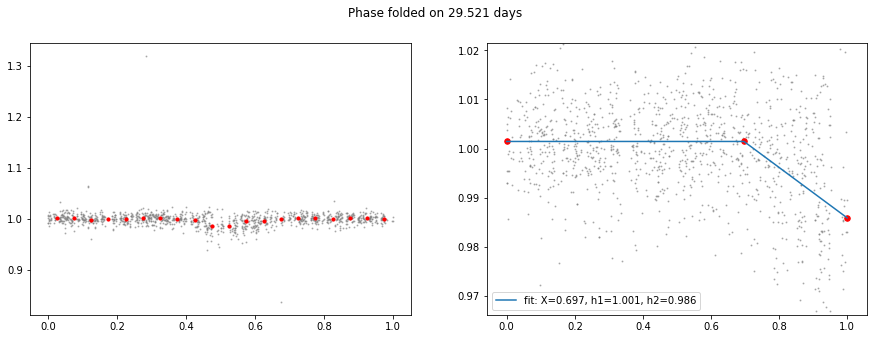

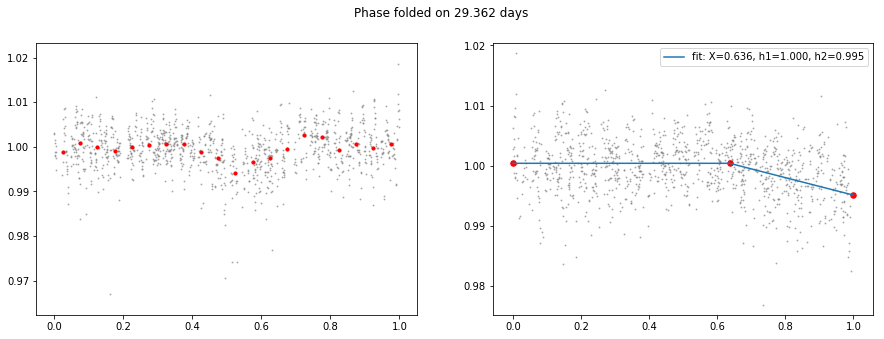

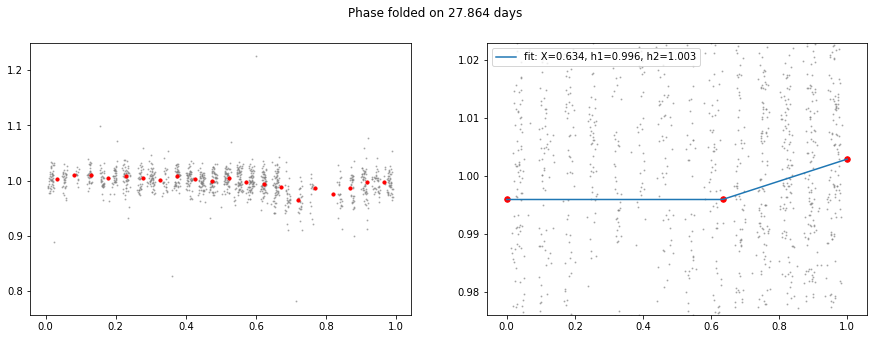

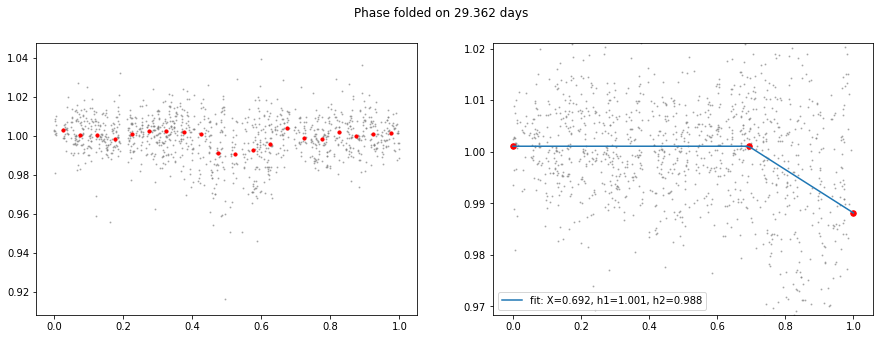

In [67]:
i = 0
steal = 0
for obj in field:
    if np.random.rand() > 0.8:
        fig, (ax1, ax) = plt.subplots(1, 2, figsize=(15,5))
        t = obj.timeseries_binned
        f = obj.flux_binned
        p = obj_periods[i]
        if steal == 0:
            t = np.linspace(min(t), max(t), len(t))
            f = np.sin((t + new_moon_epoch) * (2 * np.pi) / p) * 0.1 + (np.random.rand(len(t)) * 0.01) + 1
            steal = 1
        phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
        binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
        
        ax1.scatter(phase_app, data_app, s=1, c='gray', alpha=0.5)
        ax1.scatter(binned_phase_app, binned_data_app, s=10, c='r')
        half_phase_app = fold_phase_in_half(phase_app)
        popt, pcov = curve_fit(define_fit_function, half_phase_app, data_app, [0.8, 1.0, 1.0], 
                               bounds=(0, [1, max(data_app), max(data_app)]))

        fig.suptitle('Phase folded on {} days'.format(p))
        ax.scatter(half_phase_app, data_app, s=1, c='gray', alpha=0.5)
        ts = np.linspace(0, 1, 100)
        ax.plot(ts, define_fit_function(ts, *popt), label='fit: X=%5.3f, h1=%5.3f, h2=%5.3f' % tuple(popt))
        ax.scatter(0, popt[1], c='r', s=30)
        ax.scatter(1, popt[2], c='r', s=30)
        ax.scatter(popt[0], popt[1], c='r', s=30)
        
        limits=popt[1:]
        ax.legend()
        ax.set_ylim([min(limits) * 0.98, max(limits) * 1.02])
        plt.show()
    i += 1
    

In [32]:
np.linspace(0,1,21)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])